# Import all libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
import statsmodels.tsa.seasonal as smt
import numpy as np 
import pandas as pd 
import random
import math
import datetime as dt
from sklearn import linear_model 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import plotly
import tensorflow as tf
import tensorflow_addons as tfa
from math import sqrt
print(tf.__version__)

2.3.1


# Functions

In [645]:
def making_scaled_training_val_test_data(df,train_start_num,val_start_num,test_start_num,test_end_num):
    train_start = train_start_num
    train_end = val_start_num
    train_data = df.loc[train_start:train_end-1]

    val_start = val_start_num
    val_end = test_start_num
    val_data = df.loc[val_start:val_end-1]

    test_start = test_start_num
    test_end = test_end_num
    test_data = df.loc[test_start:test_end-1]

    sc = MinMaxScaler()
    train_sc = sc.fit_transform(train_data)
    val_sc = sc.transform(val_data)
    test_sc = sc.transform(test_data) 
    return train_sc,val_sc,test_sc

def making_train_val(train_data,val_data,windows_size):
    X_train = []
    y_train = []
    X_val = []
    y_val = []

    for i in range(windows_size,train_data.shape[0]):
        X_train.append(train_data[i-windows_size:i])
        y_train.append(train_data[i][0])
    X_train,y_train = np.array(X_train),np.array(y_train)
  
    for i in range(windows_size,val_data.shape[0]):
        X_val.append(val_data[i-windows_size:i])
        y_val.append(val_data[i][0])
    X_val,y_val = np.array(X_val),np.array(y_val)
   
    return X_train,y_train,X_val,y_val

def making_test(test_data,windows_size):
    X_test = []
    y_test = []
    for i in range(windows_size,test_sc.shape[0]):
        X_test.append(test_data[i-windows_size:i])
        y_test.append(test_data[i][0])
    X_test,y_test = np.array(X_test),np.array(y_test) 
    return X_test,y_test

#Evaluation
def MAPE(y_true,y_pred):
    together=0
    leng=len(y_true)
    for i in range(leng):
        together+=np.abs(y_true[i]-y_pred[i])/y_true[i]
    return together/leng
def making_y_pred(model,X_test):
    y_pred= model.predict(X_test)
    y_pred=y_pred.ravel()
    return y_pred
def Evalu(model,X_test,y_test,y_pred):
    mse = mean_squared_error(y_test,y_pred)
    rmse = sqrt(mse)
    r = r2_score(y_test,y_pred)
    mape=MAPE(y_test,y_pred)
    print('MSE:',mse,' RMSE:',rmse, 'R^2 score:',r, 'MAPE:', mape)
    return mse,rmse,r,mape

def testset_plot(y_test,y_pred):
    plt.plot(y_test,c = 'r')
    plt.plot(y_pred,c = 'b')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('stock price')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

# Preprocessing and Loading datasets

In [9]:
def Highlow_Openclose(dataset):
    dataset['H-L']=dataset['High']-dataset['Low']
    dataset['O-C']=dataset['Close']-dataset['Open']
    dataset['H-O']=dataset['High']-dataset['Open']
    dataset['O-L']=dataset['Open']-dataset['Low']
#https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/standard-deviation
import math
def std_dev(dataset,days):
    n=days
    dataset['{} DAYS STD DEV'.format(days)]=0
    dataset['sq(C-MA)']=(dataset['Close']-dataset['{} DAYS MA'.format(n)])**2
    for i in range(len(dataset)):
        dataset['{} DAYS STD DEV'.format(n)].iloc[i]=math.sqrt(sum(dataset['sq(C-MA)'].iloc[i-n:i])/n)
    dataset.drop('sq(C-MA)', axis=1,inplace=True)
#https://www.investopedia.com/terms/m/movingaverage.asp
def MA(dataset,days):
    n=days
    dataset['{} DAYS MA'.format(n)]=0
    for i in range(len(dataset)):
        dataset['{} DAYS MA'.format(n)].iloc[i]=sum(dataset['Close'].iloc[i-n:i])/n
'''
'https://school.stockcharts.com/doku.php?id=technical_indicators:relative_strength_index_rsi'
The very first calculations for average gain and average loss are simple 14-period averages:

First Average Gain = Sum of Gains over the past 14 periods / 14.
First Average Loss = Sum of Losses over the past 14 periods / 14
The second, and subsequent, calculations are based on the prior averages and the current gain loss:

Average Gain = [(previous Average Gain) x 13 + current Gain] / 14.
Average Loss = [(previous Average Loss) x 13 + current Loss] / 14.
'''

def RSI(dataset):
    dataset['Change'] = dataset['Close'].diff()
    dataset['Gain']=dataset['Change'].where(dataset['Change']>0,0.0)
    dataset['Loss']=abs(dataset['Change'].where(dataset['Change']<0,0.0))
    dataset['AG']=0
    dataset['AL']=0
    for i in range(len(dataset)):
        dataset['AG'].iloc[i]=sum(dataset['Gain'].iloc[i-14:i])/14
        dataset['AL'].iloc[i]=sum(dataset['Loss'].iloc[i-14:i])/14
    dataset['RS']=dataset['AG']/dataset['AL']
    dataset['RSI']=100-100/(1+dataset['RS'])
    dataset.drop(['Change','Gain','Loss','AG','AL','RS'],axis=1,inplace=True)
#https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
def EMA(dataset,days):
    dataset['{} DAYS EMA'.format(days)]=dataset['Close'].ewm(span=days,adjust=False).mean()
def MACD(dataset,day1=12,day2=26):
    EMA(dataset,day1)
    EMA(dataset,day2)
    dataset['MACD']=dataset['{} DAYS EMA'.format(day1)]-dataset['{} DAYS EMA'.format(day2)]
    dataset.drop(columns=['{} DAYS EMA'.format(day1),'{} DAYS EMA'.format(day2)],axis=1,inplace=True)
#Psychological Line
def PSY(dataset,days):

    dataset['Change'] = dataset['Close'].diff()
    dataset['Change'] = dataset['Change'].fillna(0)
    n=days
    dataset['{} DAYS PSY'.format(n)]=0
    dataset['tmp']=0
    dataset.loc[dataset['Change'] > 0, 'tmp'] = 1
    for i in range(len(dataset)):
        dataset['{} DAYS PSY'.format(n)].iloc[i]=(dataset['tmp'].iloc[i+1-n:i+1].sum()/n)*100
    dataset.drop(['Change','tmp'], axis=1,inplace=True)
#Aroon (AR)
def AR(dataset,days):
    n=days
    dataset['{} DAYS AR'.format(n)]=0
    for i in range(len(dataset)):
        dataset['{} DAYS AR'.format(n)].iloc[i]=dataset['H-O'].iloc[i+1-n:i+1].sum()/dataset['O-L'].iloc[i+1-n:i+1].sum()
    dataset['{} DAYS AR'.format(n)] = dataset['{} DAYS AR'.format(n)].fillna(0)
#BR
def BR(dataset,days):
    #create two col for cal BR
    dataset['dif_High_previousClose']=0
    dataset['dif_previousClose_Low']=0
    for i in range(len(dataset)):
        dataset['dif_High_previousClose'].iloc[i]=dataset['High'].iloc[i]-dataset['Close'].iloc[i-1]
        dataset['dif_previousClose_Low'].iloc[i]=dataset['Close'].iloc[i-1]-dataset['Low'].iloc[i]
    dataset['dif_High_previousClose'].iloc[0]=0
    dataset['dif_previousClose_Low'].iloc[0]=0
    
    #BR
    n=days
    dataset['{} DAYS BR'.format(n)]=0
    for i in range(len(dataset)):
        dataset['{} DAYS BR'.format(n)].iloc[i]=dataset['dif_High_previousClose'].iloc[i+1-n:i+1].sum()/dataset['dif_previousClose_Low'].iloc[i+1-n:i+1].sum()
    dataset['{} DAYS BR'.format(n)] = dataset['{} DAYS BR'.format(n)].fillna(0)
    dataset.drop(['dif_High_previousClose','dif_previousClose_Low'], axis=1,inplace=True)
#Williams rate (WMS)
def WMS(dataset,days):
    n=days
    dataset['{} DAYS WMS'.format(n)]=0
    for i in range(len(dataset)):
        nHigh = dataset['High'].iloc[i+1-n:i+1].max()
        nLow = dataset['Low'].iloc[i+1-n:i+1].min()
        dataset['{} DAYS WMS'.format(n)].iloc[i]=(nHigh-dataset['Close'].iloc[i])/(nHigh-nLow)*100
    dataset['{} DAYS WMS'.format(n)] = dataset['{} DAYS WMS'.format(n)].fillna(0)
df=pd.read_csv("AMD.csv")
Highlow_Openclose(df)
MA(df,7)
MA(df,14)
MA(df,21)
std_dev(df,7)
EMA(df,10)
EMA(df,20)
RSI(df)   
MACD(df)
PSY(df,6)
AR(df,24)
BR(df,5)
WMS(df,6)
AMD=df.copy()

C:\Users\oukle\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\oukle\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\oukle\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\oukle\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning:


In [6]:
AMD.to_csv('AMD_indicators.csv',index=False)

# Features' correlation

In [10]:
AMD_corr=AMD.corr()

<Figure size 1080x648 with 0 Axes>

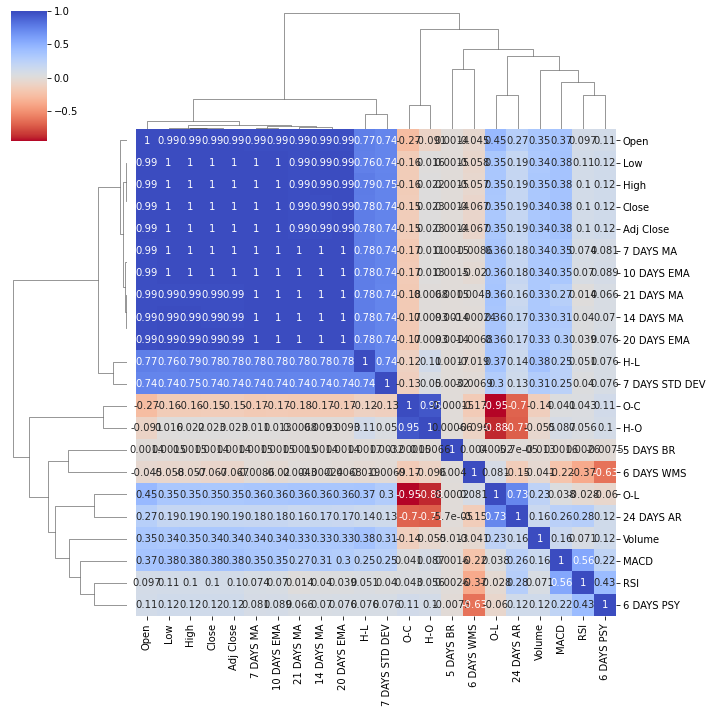

In [11]:
import seaborn as sns
plt.figure(figsize=(15,9))
sns.clustermap(AMD_corr,annot=True,cmap='coolwarm_r')

In [22]:
abs(AMD.corr()['Close']).sort_values()

5 DAYS BR         0.001431
H-O               0.023205
6 DAYS WMS        0.066981
RSI               0.104787
6 DAYS PSY        0.123388
O-C               0.152047
24 DAYS AR        0.192599
Volume            0.342009
O-L               0.345807
MACD              0.383841
7 DAYS STD DEV    0.742163
H-L               0.776588
21 DAYS MA        0.988777
14 DAYS MA        0.992347
Open              0.993041
20 DAYS EMA       0.993295
7 DAYS MA         0.995666
10 DAYS EMA       0.996995
Low               0.999468
High              0.999548
Adj Close         1.000000
Close             1.000000
Name: Close, dtype: float64

# Optimization

In [13]:
df_AMD=AMD.copy()

In [269]:
df_AMD_picked = df_AMD[['Close','H-L','O-C','7 DAYS STD DEV','RSI','MACD','Volume']] # Picking the features with high correlation
df_AMD_traditional_picked=df_AMD[['Close','High','Volume']]
windows_size=20

train_sc,val_sc, test_sc=making_scaled_training_val_test_data(df_AMD_picked,4500,9000,9500,10000)
X_train_amd,y_train_amd,X_val_amd,y_val_amd=making_train_val(train_sc,val_sc,windows_size)
X_test_amd,y_test_amd=making_test(test_sc,windows_size)

train_sc_tr,val_sc_tr, test_sc_tr=making_scaled_training_val_test_data(df_AMD_traditional_picked,4500,9000,9500,10000)
X_train_amd_tr,y_train_amd_tr,X_val_amd_tr,y_val_amd_tr=making_train_val(train_sc_tr,val_sc_tr,windows_size)
X_test_amd_tr,y_test_amd_tr=making_test(test_sc_tr,windows_size)

## models

### Single layer

#### Linear

In [95]:
model_amd_6f3l = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[20, 7]),
    tf.keras.layers.Dense(1)
])
model_amd_6f3l.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_amd_6f3l = model_amd_6f3l.fit(X_train_amd,y_train_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0084
Epoch 2/100
70/70 [==============================] - 0s 629us/step - loss: 0.0043 - val_loss: 0.0054
Epoch 3/100
70/70 [==============================] - 0s 615us/step - loss: 0.0034 - val_loss: 0.0046
Epoch 4/100
70/70 [==============================] - 0s 643us/step - loss: 0.0030 - val_loss: 0.0041
Epoch 5/100
70/70 [==============================] - 0s 629us/step - loss: 0.0026 - val_loss: 0.0038
Epoch 6/100
70/70 [==============================] - 0s 643us/step - loss: 0.0024 - val_loss: 0.0035
Epoch 7/100
70/70 [==============================] - 0s 643us/step - loss: 0.0021 - val_loss: 0.0032
Epoch 8/100
70/70 [==============================] - 0s 658us/step - loss: 0.0020 - val_loss: 0.0030
Epoch 9/100
70/70 [==============================] - 0s 643us/step - loss: 0.0018 - val_loss: 0.0028
Epoch 10/100
70/70 [==============================] - 0s 643us/step - loss: 0.0017 - val_loss

70/70 [==============================] - 0s 615us/step - loss: 1.7112e-04 - val_loss: 6.3197e-05
Epoch 78/100
70/70 [==============================] - 0s 643us/step - loss: 1.6220e-04 - val_loss: 6.5578e-05
Epoch 79/100
70/70 [==============================] - 0s 615us/step - loss: 1.5919e-04 - val_loss: 6.4833e-05
Epoch 80/100
70/70 [==============================] - 0s 601us/step - loss: 1.6663e-04 - val_loss: 7.7811e-05
Epoch 81/100
70/70 [==============================] - 0s 615us/step - loss: 1.5125e-04 - val_loss: 5.9911e-05
Epoch 82/100
70/70 [==============================] - 0s 615us/step - loss: 1.5385e-04 - val_loss: 6.6562e-05
Epoch 83/100
70/70 [==============================] - 0s 615us/step - loss: 1.5724e-04 - val_loss: 7.7535e-05
Epoch 84/100
70/70 [==============================] - 0s 615us/step - loss: 1.4548e-04 - val_loss: 6.5816e-05
Epoch 85/100
70/70 [==============================] - 0s 615us/step - loss: 1.5693e-04 - val_loss: 6.5189e-05
Epoch 86/100
70/70 [===

In [96]:
model_amd_6f3l.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 140)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 141       
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

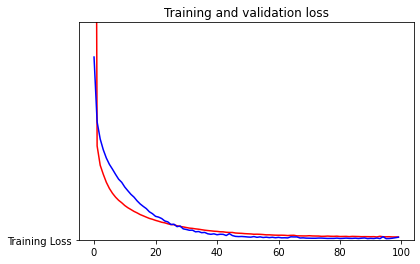

In [97]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


loss_amd_6f3l=history_amd_6f3l.history['loss']
val_loss_amd_6f3l=history_amd_6f3l.history['val_loss']

epochs=range(len(loss_amd_6f3l)) 


plt.plot(epochs, loss_amd_6f3l, 'r', "Training Loss")
plt.plot(epochs, val_loss_amd_6f3l, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [98]:
y_pred_amd_6f3l=making_y_pred(model_amd_6f3l,X_test_amd)
mse_amd_6f3l,rmse_amd_6f3l,r_amd_6f3l,mape_amd_6f3l=Evalu(model_amd_6f3l,X_test_amd,y_test_amd,y_pred_amd_6f3l)

MSE: 0.0008312846295598503  RMSE: 0.02883200703315415 R^2 score: 0.970844667008151 MAPE: 0.05212014345656429


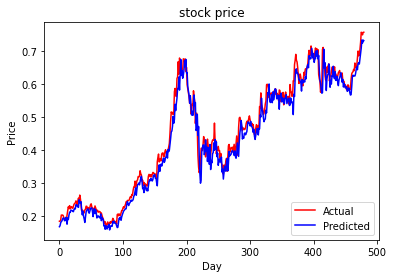

In [99]:
testset_plot(y_test_amd,y_pred_amd_6f3l)

#### simpleRNN

In [100]:
model_amd_6f3l = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[20, 7]),
    tf.keras.layers.Dense(1)
])
model_amd_6f3l.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_amd_6f3l = model_amd_6f3l.fit(X_train_amd,y_train_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/100
70/70 [==============================] - 0s 4ms/step - loss: 0.0349 - val_loss: 0.0108
Epoch 2/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.0100
Epoch 3/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.0092
Epoch 4/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0084
Epoch 5/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0076
Epoch 6/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0205 - val_loss: 0.0081
Epoch 7/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0193 - val_loss: 0.0072
Epoch 8/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0183 - val_loss: 0.0074
Epoch 9/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0174 - val_loss: 0.0069
Epoch 10/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0165 - val_loss: 0.0069
Epoch 11/

70/70 [==============================] - 0s 2ms/step - loss: 1.2593e-04 - val_loss: 5.8655e-05
Epoch 81/100
70/70 [==============================] - 0s 2ms/step - loss: 1.2547e-04 - val_loss: 5.9606e-05
Epoch 82/100
70/70 [==============================] - 0s 2ms/step - loss: 1.2427e-04 - val_loss: 6.0390e-05
Epoch 83/100
70/70 [==============================] - 0s 2ms/step - loss: 1.2264e-04 - val_loss: 5.7576e-05
Epoch 84/100
70/70 [==============================] - 0s 2ms/step - loss: 1.2188e-04 - val_loss: 5.7349e-05
Epoch 85/100
70/70 [==============================] - 0s 2ms/step - loss: 1.2142e-04 - val_loss: 5.6768e-05
Epoch 86/100
70/70 [==============================] - 0s 2ms/step - loss: 1.1976e-04 - val_loss: 5.4998e-05
Epoch 87/100
70/70 [==============================] - 0s 2ms/step - loss: 1.1868e-04 - val_loss: 5.5032e-05
Epoch 88/100
70/70 [==============================] - 0s 2ms/step - loss: 1.1831e-04 - val_loss: 5.6845e-05
Epoch 89/100
70/70 [=====================

In [101]:
model_amd_6f3l.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 1)                 9         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 2         
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

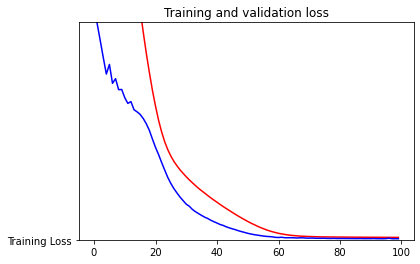

In [102]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


loss_amd_6f3l=history_amd_6f3l.history['loss']
val_loss_amd_6f3l=history_amd_6f3l.history['val_loss']

epochs=range(len(loss_amd_6f3l)) 


plt.plot(epochs, loss_amd_6f3l, 'r', "Training Loss")
plt.plot(epochs, val_loss_amd_6f3l, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [103]:
y_pred_amd_6f3l=making_y_pred(model_amd_6f3l,X_test_amd)
mse_amd_6f3l,rmse_amd_6f3l,r_amd_6f3l,mape_amd_6f3l=Evalu(model_amd_6f3l,X_test_amd,y_test_amd,y_pred_amd_6f3l)

MSE: 0.000371454588381361  RMSE: 0.01927315719806594 R^2 score: 0.9869721130037699 MAPE: 0.03185198561478402


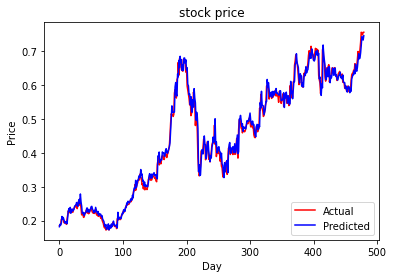

In [104]:
testset_plot(y_test_amd,y_pred_amd_6f3l)

#### Uni-directional LSTM

In [105]:
model_amd_6f3l = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(40,activation = 'relu'),
    tf.keras.layers.Dense(1)
])
model_amd_6f3l.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_amd_6f3l = model_amd_6f3l.fit(X_train_amd,y_train_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/100
70/70 [==============================] - 1s 8ms/step - loss: 0.0047 - val_loss: 4.8165e-04
Epoch 2/100
70/70 [==============================] - 0s 5ms/step - loss: 3.6785e-04 - val_loss: 2.2173e-04
Epoch 3/100
70/70 [==============================] - 0s 5ms/step - loss: 2.9041e-04 - val_loss: 1.8813e-04
Epoch 4/100
70/70 [==============================] - 0s 5ms/step - loss: 2.8080e-04 - val_loss: 1.6035e-04
Epoch 5/100
70/70 [==============================] - 0s 5ms/step - loss: 2.1983e-04 - val_loss: 2.0006e-04
Epoch 6/100
70/70 [==============================] - 0s 5ms/step - loss: 2.0055e-04 - val_loss: 1.2774e-04
Epoch 7/100
70/70 [==============================] - 0s 5ms/step - loss: 2.0215e-04 - val_loss: 1.6634e-04
Epoch 8/100
70/70 [==============================] - 0s 5ms/step - loss: 1.7211e-04 - val_loss: 1.2731e-04
Epoch 9/100
70/70 [==============================] - 0s 5ms/step - loss: 1.6822e-04 - val_loss: 9.3756e-05
Epoch 10/100
70/70 [=====================

Epoch 77/100
70/70 [==============================] - 0s 5ms/step - loss: 9.8792e-05 - val_loss: 4.6848e-05
Epoch 78/100
70/70 [==============================] - 0s 5ms/step - loss: 9.7599e-05 - val_loss: 5.1347e-05
Epoch 79/100
70/70 [==============================] - 0s 5ms/step - loss: 1.1706e-04 - val_loss: 4.5654e-05
Epoch 80/100
70/70 [==============================] - 0s 5ms/step - loss: 1.2057e-04 - val_loss: 4.7280e-05
Epoch 81/100
70/70 [==============================] - 0s 5ms/step - loss: 1.0457e-04 - val_loss: 6.8651e-05
Epoch 82/100
70/70 [==============================] - 0s 5ms/step - loss: 9.6007e-05 - val_loss: 4.9130e-05
Epoch 83/100
70/70 [==============================] - 0s 5ms/step - loss: 9.6399e-05 - val_loss: 4.4065e-05
Epoch 84/100
70/70 [==============================] - 0s 5ms/step - loss: 9.4898e-05 - val_loss: 4.5008e-05
Epoch 85/100
70/70 [==============================] - 0s 5ms/step - loss: 9.3136e-05 - val_loss: 4.4419e-05
Epoch 86/100
70/70 [========

In [106]:
model_amd_6f3l.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 40)                7680      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 41        
Total params: 7,721
Trainable params: 7,721
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

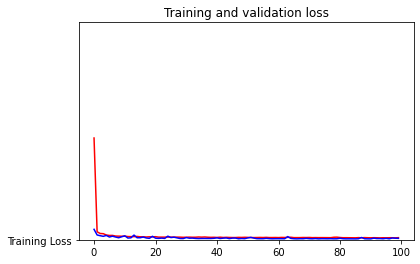

In [107]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


loss_amd_6f3l=history_amd_6f3l.history['loss']
val_loss_amd_6f3l=history_amd_6f3l.history['val_loss']

epochs=range(len(loss_amd_6f3l)) 


plt.plot(epochs, loss_amd_6f3l, 'r', "Training Loss")
plt.plot(epochs, val_loss_amd_6f3l, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [108]:
y_pred_amd_6f3l=making_y_pred(model_amd_6f3l,X_test_amd)
mse_amd_6f3l,rmse_amd_6f3l,r_amd_6f3l,mape_amd_6f3l=Evalu(model_amd_6f3l,X_test_amd,y_test_amd,y_pred_amd_6f3l)

MSE: 0.0006105879289155509  RMSE: 0.024710077476923276 R^2 score: 0.9785850793394771 MAPE: 0.041035793288934946


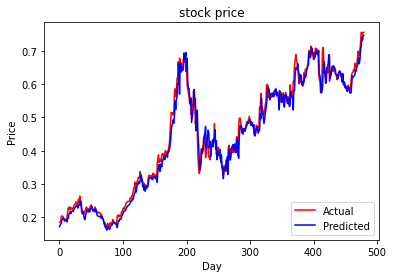

In [109]:
testset_plot(y_test_amd,y_pred_amd_6f3l)

#### Bidirectional LSTM

In [111]:
model_amd_6f3l = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6,input_shape = (20,7),return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
model_amd_6f3l.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_amd_6f3l = model_amd_6f3l.fit(X_train_amd,y_train_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/100
70/70 [==============================] - 1s 11ms/step - loss: 0.0155 - val_loss: 0.0014
Epoch 2/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 6.7203e-04
Epoch 3/100
70/70 [==============================] - 0s 5ms/step - loss: 8.3552e-04 - val_loss: 5.0513e-04
Epoch 4/100
70/70 [==============================] - 0s 5ms/step - loss: 7.0296e-04 - val_loss: 4.3953e-04
Epoch 5/100
70/70 [==============================] - 0s 5ms/step - loss: 6.1098e-04 - val_loss: 3.9810e-04
Epoch 6/100
70/70 [==============================] - 0s 5ms/step - loss: 5.8567e-04 - val_loss: 3.5783e-04
Epoch 7/100
70/70 [==============================] - 0s 5ms/step - loss: 5.3403e-04 - val_loss: 3.4851e-04
Epoch 8/100
70/70 [==============================] - 0s 5ms/step - loss: 5.0035e-04 - val_loss: 3.1748e-04
Epoch 9/100
70/70 [==============================] - 0s 5ms/step - loss: 4.7196e-04 - val_loss: 2.9967e-04
Epoch 10/100
70/70 [============================

70/70 [==============================] - 0s 5ms/step - loss: 1.3310e-04 - val_loss: 9.4948e-05
Epoch 78/100
70/70 [==============================] - 0s 5ms/step - loss: 1.2642e-04 - val_loss: 9.9894e-05
Epoch 79/100
70/70 [==============================] - 0s 5ms/step - loss: 1.2368e-04 - val_loss: 9.2335e-05
Epoch 80/100
70/70 [==============================] - 0s 5ms/step - loss: 1.2518e-04 - val_loss: 9.7237e-05
Epoch 81/100
70/70 [==============================] - 0s 5ms/step - loss: 1.2460e-04 - val_loss: 1.1208e-04
Epoch 82/100
70/70 [==============================] - 0s 5ms/step - loss: 1.2695e-04 - val_loss: 9.2263e-05
Epoch 83/100
70/70 [==============================] - 0s 5ms/step - loss: 1.2717e-04 - val_loss: 9.8810e-05
Epoch 84/100
70/70 [==============================] - 0s 5ms/step - loss: 1.2113e-04 - val_loss: 9.8231e-05
Epoch 85/100
70/70 [==============================] - 0s 5ms/step - loss: 1.2284e-04 - val_loss: 8.7171e-05
Epoch 86/100
70/70 [=====================

In [112]:
model_amd_6f3l.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 20, 12)            672       
_________________________________________________________________
flatten_10 (Flatten)         (None, 240)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 241       
Total params: 913
Trainable params: 913
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

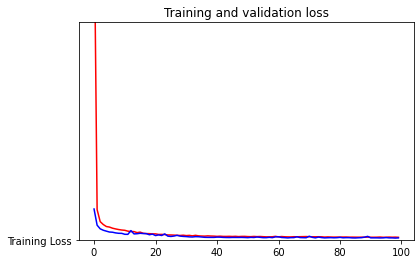

In [113]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


loss_amd_6f3l=history_amd_6f3l.history['loss']
val_loss_amd_6f3l=history_amd_6f3l.history['val_loss']

epochs=range(len(loss_amd_6f3l)) 


plt.plot(epochs, loss_amd_6f3l, 'r', "Training Loss")
plt.plot(epochs, val_loss_amd_6f3l, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [114]:
y_pred_amd_6f3l=making_y_pred(model_amd_6f3l,X_test_amd)
mse_amd_6f3l,rmse_amd_6f3l,r_amd_6f3l,mape_amd_6f3l=Evalu(model_amd_6f3l,X_test_amd,y_test_amd,y_pred_amd_6f3l)

MSE: 0.0010180818211100286  RMSE: 0.03190739445818208 R^2 score: 0.9642931994025593 MAPE: 0.04926056528379397


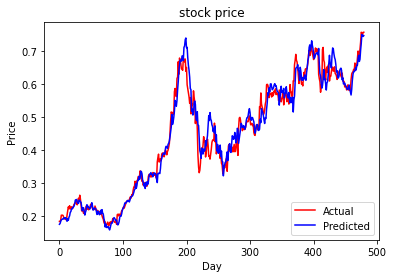

In [115]:
testset_plot(y_test_amd,y_pred_amd_6f3l)

#### Conv1d+Bidirectional LSTM

In [116]:
model_amd_6f3l = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(7,kernel_size=1,input_shape=(20,7)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
model_amd_6f3l.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_amd_6f3l = model_amd_6f3l.fit(X_train_amd,y_train_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/100
70/70 [==============================] - 1s 10ms/step - loss: 0.0080 - val_loss: 0.0029
Epoch 2/100
70/70 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 3/100
70/70 [==============================] - 0s 6ms/step - loss: 9.7675e-04 - val_loss: 6.5639e-04
Epoch 4/100
70/70 [==============================] - 0s 6ms/step - loss: 7.4075e-04 - val_loss: 5.6759e-04
Epoch 5/100
70/70 [==============================] - 0s 6ms/step - loss: 6.1107e-04 - val_loss: 4.1672e-04
Epoch 6/100
70/70 [==============================] - 0s 6ms/step - loss: 5.3799e-04 - val_loss: 4.8281e-04
Epoch 7/100
70/70 [==============================] - 0s 6ms/step - loss: 4.8804e-04 - val_loss: 3.7698e-04
Epoch 8/100
70/70 [==============================] - 0s 6ms/step - loss: 4.2250e-04 - val_loss: 4.2139e-04
Epoch 9/100
70/70 [==============================] - 0s 6ms/step - loss: 3.9295e-04 - val_loss: 3.4439e-04
Epoch 10/100
70/70 [==============================] 

70/70 [==============================] - 0s 6ms/step - loss: 1.3531e-04 - val_loss: 8.9247e-05
Epoch 78/100
70/70 [==============================] - 0s 6ms/step - loss: 1.2759e-04 - val_loss: 7.1057e-05
Epoch 79/100
70/70 [==============================] - 0s 6ms/step - loss: 1.2366e-04 - val_loss: 7.5377e-05
Epoch 80/100
70/70 [==============================] - 0s 6ms/step - loss: 1.2649e-04 - val_loss: 7.3628e-05
Epoch 81/100
70/70 [==============================] - 0s 6ms/step - loss: 1.1607e-04 - val_loss: 5.9607e-05
Epoch 82/100
70/70 [==============================] - 0s 6ms/step - loss: 1.1844e-04 - val_loss: 8.2506e-05
Epoch 83/100
70/70 [==============================] - 0s 6ms/step - loss: 1.2137e-04 - val_loss: 6.0175e-05
Epoch 84/100
70/70 [==============================] - 0s 6ms/step - loss: 1.2129e-04 - val_loss: 7.4848e-05
Epoch 85/100
70/70 [==============================] - 0s 6ms/step - loss: 1.2200e-04 - val_loss: 6.4362e-05
Epoch 86/100
70/70 [=====================

In [117]:
model_amd_6f3l.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 20, 7)             56        
_________________________________________________________________
bidirectional_2 (Bidirection (None, 20, 12)            672       
_________________________________________________________________
flatten_11 (Flatten)         (None, 240)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 241       
Total params: 969
Trainable params: 969
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

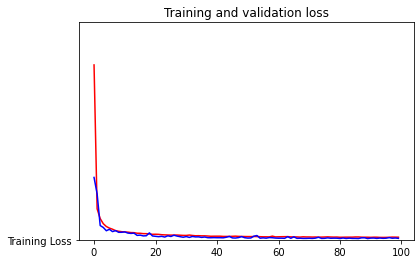

In [118]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


loss_amd_6f3l=history_amd_6f3l.history['loss']
val_loss_amd_6f3l=history_amd_6f3l.history['val_loss']

epochs=range(len(loss_amd_6f3l)) 


plt.plot(epochs, loss_amd_6f3l, 'r', "Training Loss")
plt.plot(epochs, val_loss_amd_6f3l, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [119]:
y_pred_amd_6f3l=making_y_pred(model_amd_6f3l,X_test_amd)
mse_amd_6f3l,rmse_amd_6f3l,r_amd_6f3l,mape_amd_6f3l=Evalu(model_amd_6f3l,X_test_amd,y_test_amd,y_pred_amd_6f3l)

MSE: 0.0007896338009621083  RMSE: 0.028100423501472505 R^2 score: 0.972305470845937 MAPE: 0.042132959688312


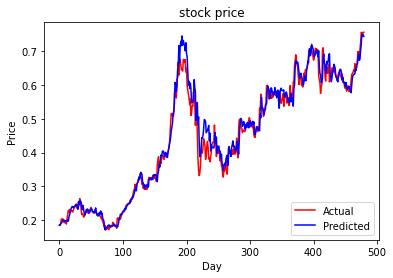

In [120]:
testset_plot(y_test_amd,y_pred_amd_6f3l)

#### Conclusion

In [121]:
model_selection=pd.DataFrame(columns=(['Linear','simpleRNN','uni-LSTM','bi-LSTM','Conv-bi-LSTM']),
                     index=(['RMSE','MAPE']))

In [123]:
model_selection.iloc[0,0]=0.02883200703315415  
model_selection.iloc[0,1]=0.01927315719806594
model_selection.iloc[0,2]=0.024710077476923276   
model_selection.iloc[0,3]=0.03190739445818208   
model_selection.iloc[0,4]=0.028100423501472505 
model_selection.iloc[1,0]=0.05212014345656429
model_selection.iloc[1,1]=0.03185198561478402
model_selection.iloc[1,2]=0.041035793288934946  
model_selection.iloc[1,3]=0.04926056528379397
model_selection.iloc[1,4]=0.042132959688312

In [124]:
model_selection

Linear  simpleRNN   uni-LSTM    bi-LSTM Conv-bi-LSTM
RMSE   0.028832  0.0192732  0.0247101  0.0319074    0.0281004
MAPE  0.0521201   0.031852  0.0410358  0.0492606     0.042133

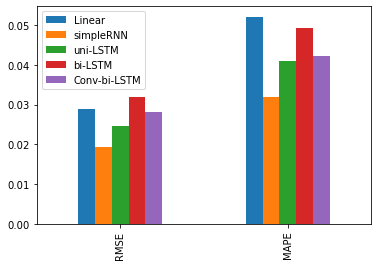

In [130]:
model_selection.plot(kind='bar')

### Multiple layers

#### Linear

In [6]:
# grid search for learning rate
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers

model_amd_linear = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[20, 7]),
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-5)
model_amd_linear.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mean_squared_error'])
history_amd_linear = model_amd_linear.fit(X_train_amd,y_train_amd, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
140/140 [==============================] - 0s 486us/step - loss: 0.0295 - mean_squared_error: 0.0590
Epoch 2/100
140/140 [==============================] - 0s 485us/step - loss: 0.0232 - mean_squared_error: 0.0463
Epoch 3/100
140/140 [==============================] - 0s 470us/step - loss: 0.0190 - mean_squared_error: 0.0381
Epoch 4/100
140/140 [==============================] - 0s 508us/step - loss: 0.0162 - mean_squared_error: 0.0324
Epoch 5/100
140/140 [==============================] - 0s 469us/step - loss: 0.0140 - mean_squared_error: 0.0279
Epoch 6/100
140/140 [==============================] - 0s 465us/step - loss: 0.0121 - mean_squared_error: 0.0242
Epoch 7/100
140/140 [==============================] - 0s 493us/step - loss: 0.0106 - mean_squared_error: 0.0212
Epoch 8/100
140/140 [==============================] - 0s 486us/step - loss: 0.0094 - mean_squared_error: 0.0187
Epoch 9/100
140/140 [==============================] - 0s 486us/step - loss: 0.0084 - mean_squar

140/140 [==============================] - 0s 458us/step - loss: 0.0090 - mean_squared_error: 0.0181
Epoch 72/100
140/140 [==============================] - 0s 472us/step - loss: 0.0013 - mean_squared_error: 0.0026
Epoch 73/100
140/140 [==============================] - 0s 472us/step - loss: 6.2180e-04 - mean_squared_error: 0.0012
Epoch 74/100
140/140 [==============================] - 0s 465us/step - loss: 0.0012 - mean_squared_error: 0.0024
Epoch 75/100
140/140 [==============================] - 0s 479us/step - loss: 0.0222 - mean_squared_error: 0.0445
Epoch 76/100
140/140 [==============================] - 0s 450us/step - loss: 8.5955e-04 - mean_squared_error: 0.0017
Epoch 77/100
140/140 [==============================] - 0s 458us/step - loss: 0.0134 - mean_squared_error: 0.0267
Epoch 78/100
140/140 [==============================] - 0s 443us/step - loss: 0.0101 - mean_squared_error: 0.0202
Epoch 79/100
140/140 [==============================] - 0s 450us/step - loss: 0.0140 - mean_s

(1e-05, 10.0, 0.0, 0.011)

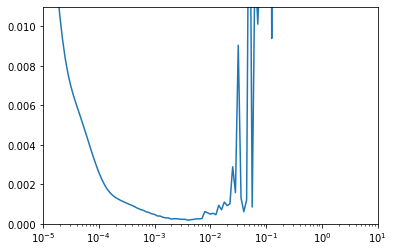

In [7]:
plt.semilogx(history_amd_linear.history["lr"], history_amd_linear.history["loss"])
plt.axis([1e-5, 10, 0, 0.011])

In [270]:
model_amd_linear = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[20, 7]),
    tf.keras.layers.Dense(1)
])

model_amd_linear.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.001), loss = tf.keras.losses.Huber())

history_amd_linear = model_amd_linear.fit(X_train_amd,y_train_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0262
Epoch 2/100
70/70 [==============================] - 0s 672us/step - loss: 0.0220 - val_loss: 0.0252
Epoch 3/100
70/70 [==============================] - 0s 658us/step - loss: 0.0215 - val_loss: 0.0243
Epoch 4/100
70/70 [==============================] - 0s 643us/step - loss: 0.0213 - val_loss: 0.0238
Epoch 5/100
70/70 [==============================] - 0s 658us/step - loss: 0.0211 - val_loss: 0.0234
Epoch 6/100
70/70 [==============================] - 0s 658us/step - loss: 0.0209 - val_loss: 0.0231
Epoch 7/100
70/70 [==============================] - 0s 658us/step - loss: 0.0209 - val_loss: 0.0230
Epoch 8/100
70/70 [==============================] - 0s 672us/step - loss: 0.0207 - val_loss: 0.0228
Epoch 9/100
70/70 [==============================] - 0s 672us/step - loss: 0.0207 - val_loss: 0.0227
Epoch 10/100
70/70 [==============================] - 0s 658us/step - loss: 0.0206 - val_loss

70/70 [==============================] - 0s 658us/step - loss: 0.0202 - val_loss: 0.0223
Epoch 82/100
70/70 [==============================] - 0s 658us/step - loss: 0.0202 - val_loss: 0.0223
Epoch 83/100
70/70 [==============================] - 0s 643us/step - loss: 0.0202 - val_loss: 0.0223
Epoch 84/100
70/70 [==============================] - 0s 643us/step - loss: 0.0202 - val_loss: 0.0223
Epoch 85/100
70/70 [==============================] - 0s 643us/step - loss: 0.0202 - val_loss: 0.0223
Epoch 86/100
70/70 [==============================] - 0s 629us/step - loss: 0.0202 - val_loss: 0.0223
Epoch 87/100
70/70 [==============================] - 0s 658us/step - loss: 0.0202 - val_loss: 0.0223
Epoch 88/100
70/70 [==============================] - 0s 629us/step - loss: 0.0202 - val_loss: 0.0223
Epoch 89/100
70/70 [==============================] - 0s 686us/step - loss: 0.0202 - val_loss: 0.0223
Epoch 90/100
70/70 [==============================] - 0s 629us/step - loss: 0.0202 - val_loss: 

In [5]:
model_amd_linear.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 120)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 121       
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

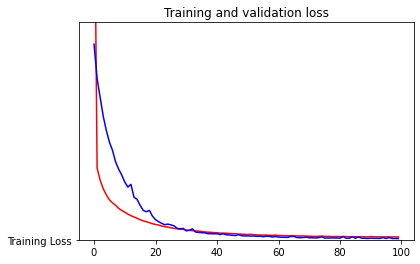

In [6]:
%matplotlib inline
loss_amd_linear=history_amd_linear.history['loss']
val_loss_amd_linear=history_amd_linear.history['val_loss']

epochs=range(len(loss_amd_linear)) 

plt.plot(epochs, loss_amd_linear, 'r', "Training Loss")
plt.plot(epochs, val_loss_amd_linear, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [7]:
y_pred_amd_linear=making_y_pred(model_amd_linear,X_test_amd)
mse_amd_linear,rmase_amd_linear,r_amd_linear,mape_amd_linear=Evalu(model_amd_linear,X_test_amd,y_test_amd,y_pred_amd_linear)

MSE: 0.0004884349896427695  RMSE: 0.022100565369301516 R^2 score: 0.982869303411221 MAPE: 0.03546908124523461


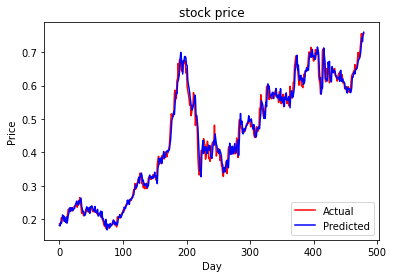

In [8]:
testset_plot(y_test_amd,y_pred_amd_linear)

#### simpleRNN

In [271]:
model_amd_simpleRNN = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[20, 7])
])

model_amd_simpleRNN.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_amd_simpleRNN = model_amd_simpleRNN.fit(X_train_amd,y_train_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/100
70/70 [==============================] - 0s 4ms/step - loss: 0.1100 - val_loss: 0.1029
Epoch 2/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0822 - val_loss: 0.0830
Epoch 3/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0633 - val_loss: 0.0626
Epoch 4/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0504
Epoch 5/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0456
Epoch 6/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0398
Epoch 7/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0355
Epoch 8/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.0338
Epoch 9/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0309
Epoch 10/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0282 - val_loss: 0.0295
Epoch 11/

70/70 [==============================] - 0s 2ms/step - loss: 0.0203 - val_loss: 0.0223
Epoch 84/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0203 - val_loss: 0.0223
Epoch 85/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0203 - val_loss: 0.0223
Epoch 86/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0202 - val_loss: 0.0223
Epoch 87/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0202 - val_loss: 0.0223
Epoch 88/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0202 - val_loss: 0.0223
Epoch 89/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0202 - val_loss: 0.0223
Epoch 90/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0202 - val_loss: 0.0223
Epoch 91/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0202 - val_loss: 0.0223
Epoch 92/100
70/70 [==============================] - 0s 2ms/step - loss: 0.0202 - val_loss: 0.0223
Epoch 93/100


In [10]:
model_amd_simpleRNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1)                 8         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

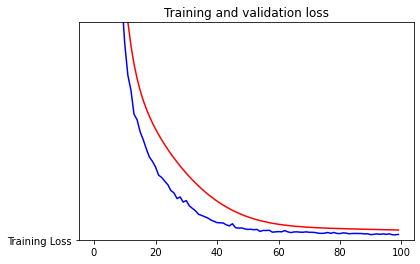

In [11]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_amd_simpleRNN=history_amd_simpleRNN.history['loss']
val_loss_amd_simpleRNN=history_amd_simpleRNN.history['val_loss']

epochs=range(len(loss_amd_simpleRNN)) 

plt.plot(epochs, loss_amd_simpleRNN, 'r', "Training Loss")
plt.plot(epochs, val_loss_amd_simpleRNN, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [12]:
y_pred_amd_simpleRNN=making_y_pred(model_amd_simpleRNN,X_test_amd)
mse_amd_simpleRNN,rmse_amd_simpleRNN,r_amd_simpleRNN,mape_amd_simpleRNN=Evalu(model_amd_simpleRNN,X_test_amd,y_test_amd,y_pred_amd_simpleRNN)

MSE: 0.0011487271048288708  RMSE: 0.03389287690398782 R^2 score: 0.9597111265298126 MAPE: 0.06550389442172808


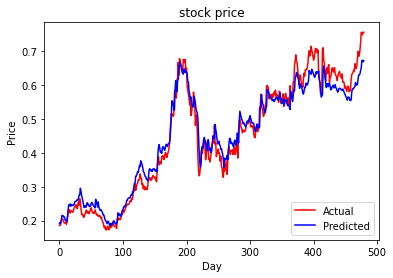

In [13]:
testset_plot(y_test_amd,y_pred_amd_simpleRNN)

#### uni-directional LSTM

In [14]:
model_amd_6f3l = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(6,input_shape = (20,7),return_sequences = True,
               activation = 'relu'),
    tf.keras.layers.LSTM(40,activation = 'relu',return_sequences = True),
    tf.keras.layers.LSTM(40,activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
model_amd_6f3l.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_amd_6f3l = model_amd_6f3l.fit(X_train_amd,y_train_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/100
70/70 [==============================] - 1s 17ms/step - loss: 0.0188 - val_loss: 0.0053
Epoch 2/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0061 - val_loss: 0.0098
Epoch 3/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0025 - val_loss: 0.0097
Epoch 4/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0018 - val_loss: 0.0058
Epoch 5/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 6/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 7/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0013 - val_loss: 4.7719e-04
Epoch 8/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0011 - val_loss: 6.6349e-04
Epoch 9/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0010 - val_loss: 4.3951e-04
Epoch 10/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0010 - val_

Epoch 77/100
70/70 [==============================] - 1s 12ms/step - loss: 5.4638e-04 - val_loss: 1.9437e-04
Epoch 78/100
70/70 [==============================] - 1s 12ms/step - loss: 5.0846e-04 - val_loss: 2.1011e-04
Epoch 79/100
70/70 [==============================] - 1s 12ms/step - loss: 4.6718e-04 - val_loss: 1.0169e-04
Epoch 80/100
70/70 [==============================] - 1s 12ms/step - loss: 4.8224e-04 - val_loss: 1.7801e-04
Epoch 81/100
70/70 [==============================] - 1s 12ms/step - loss: 4.5272e-04 - val_loss: 1.2028e-04
Epoch 82/100
70/70 [==============================] - 1s 12ms/step - loss: 5.3526e-04 - val_loss: 1.1411e-04
Epoch 83/100
70/70 [==============================] - 1s 12ms/step - loss: 4.9354e-04 - val_loss: 1.0349e-04
Epoch 84/100
70/70 [==============================] - 1s 12ms/step - loss: 4.9163e-04 - val_loss: 1.0204e-04
Epoch 85/100
70/70 [==============================] - 1s 12ms/step - loss: 4.7923e-04 - val_loss: 1.2559e-04
Epoch 86/100
70/70 

In [15]:
model_amd_6f3l.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 6)             312       
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 40)            7520      
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 41        
Total params: 20,833
Trainable params: 20,833
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

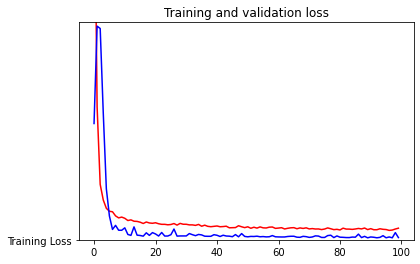

In [16]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


loss_amd_6f3l=history_amd_6f3l.history['loss']
val_loss_amd_6f3l=history_amd_6f3l.history['val_loss']

epochs=range(len(loss_amd_6f3l)) 


plt.plot(epochs, loss_amd_6f3l, 'r', "Training Loss")
plt.plot(epochs, val_loss_amd_6f3l, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [17]:
y_pred_amd_6f3l=making_y_pred(model_amd_6f3l,X_test_amd)
mse_amd_6f3l,rmse_amd_6f3l,r_amd_6f3l,mape_amd_6f3l=Evalu(model_amd_6f3l,X_test_amd,y_test_amd,y_pred_amd_6f3l)

MSE: 0.001224217423674122  RMSE: 0.03498881855213351 R^2 score: 0.9570634829847137 MAPE: 0.05442407988557649


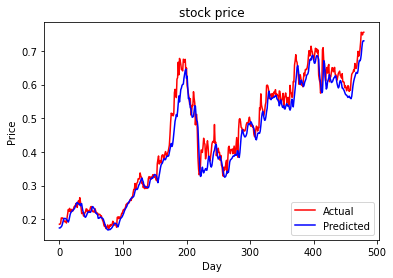

In [18]:
testset_plot(y_test_amd,y_pred_amd_6f3l)

#### Bi-directional LSTM

In [21]:
model_amd_6f3lbi = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6,input_shape = (20,7),return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_amd_6f3lbi.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_amd_6f3lbi = model_amd_6f3lbi.fit(X_train_amd,y_train_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/100
70/70 [==============================] - 3s 42ms/step - loss: 0.0054 - val_loss: 0.0020
Epoch 2/100
70/70 [==============================] - 1s 16ms/step - loss: 0.0011 - val_loss: 5.1137e-04
Epoch 3/100
70/70 [==============================] - 1s 15ms/step - loss: 8.9690e-04 - val_loss: 3.8077e-04
Epoch 4/100
70/70 [==============================] - 1s 15ms/step - loss: 7.5792e-04 - val_loss: 1.4092e-04
Epoch 5/100
70/70 [==============================] - 1s 15ms/step - loss: 6.9250e-04 - val_loss: 1.2773e-04
Epoch 6/100
70/70 [==============================] - 1s 15ms/step - loss: 6.3885e-04 - val_loss: 2.0322e-04
Epoch 7/100
70/70 [==============================] - 1s 16ms/step - loss: 6.2311e-04 - val_loss: 2.4750e-04
Epoch 8/100
70/70 [==============================] - 1s 16ms/step - loss: 6.5917e-04 - val_loss: 2.1899e-04
Epoch 9/100
70/70 [==============================] - 1s 15ms/step - loss: 5.1959e-04 - val_loss: 1.4957e-04
Epoch 10/100
70/70 [====================

In [22]:
model_amd_6f3lbi.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 20, 12)            624       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20, 80)            16960     
_________________________________________________________________
lstm_5 (LSTM)                (None, 40)                19360     
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 41        
Total params: 36,985
Trainable params: 36,985
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

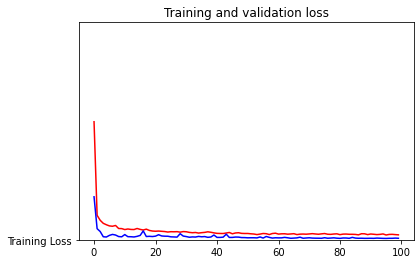

In [23]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


loss_amd_6f3lbi=history_amd_6f3lbi.history['loss']
val_loss_amd_6f3lbi=history_amd_6f3lbi.history['val_loss']

epochs=range(len(loss_amd_6f3lbi)) 


plt.plot(epochs, loss_amd_6f3lbi, 'r', "Training Loss")
plt.plot(epochs, val_loss_amd_6f3lbi, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [24]:
y_pred_amd_6f3lbi=making_y_pred(model_amd_6f3lbi,X_test_amd)
mse_amd_6f3lbi,rmse_amd_6f3lbi,r_amd_6f3lbi,mape_amd_6f3lbi=Evalu(model_amd_6f3lbi,X_test_amd,y_test_amd,y_pred_amd_6f3lbi)

MSE: 0.0008746779935580635  RMSE: 0.02957495551235984 R^2 score: 0.9693227478819977 MAPE: 0.04709533920684883


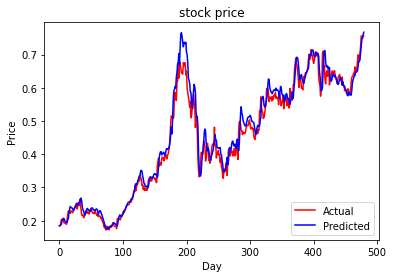

In [25]:
testset_plot(y_test_amd,y_pred_amd_6f3lbi)

#### Conv1d+ bidirectional LSTM

In [26]:
model_amd_6fc13lbi = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(6,kernel_size=2,input_shape=(20,7)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_amd_6fc13lbi.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_amd_6fc13lbi = model_amd_6fc13lbi.fit(X_train_amd,y_train_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/100
70/70 [==============================] - 2s 31ms/step - loss: 0.0050 - val_loss: 4.3901e-04
Epoch 2/100
70/70 [==============================] - 1s 16ms/step - loss: 0.0010 - val_loss: 4.0169e-04
Epoch 3/100
70/70 [==============================] - 1s 15ms/step - loss: 7.9440e-04 - val_loss: 2.8966e-04
Epoch 4/100
70/70 [==============================] - 1s 15ms/step - loss: 7.7483e-04 - val_loss: 2.5744e-04
Epoch 5/100
70/70 [==============================] - 1s 15ms/step - loss: 6.8303e-04 - val_loss: 3.6438e-04
Epoch 6/100
70/70 [==============================] - 1s 15ms/step - loss: 5.7718e-04 - val_loss: 2.5188e-04
Epoch 7/100
70/70 [==============================] - 1s 15ms/step - loss: 6.7401e-04 - val_loss: 1.6272e-04
Epoch 8/100
70/70 [==============================] - 1s 15ms/step - loss: 6.2280e-04 - val_loss: 4.6270e-04
Epoch 9/100
70/70 [==============================] - 1s 15ms/step - loss: 5.5263e-04 - val_loss: 1.3009e-04
Epoch 10/100
70/70 [================

In [27]:
model_amd_6fc13lbi.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 19, 6)             78        
_________________________________________________________________
bidirectional_2 (Bidirection (None, 19, 12)            624       
_________________________________________________________________
bidirectional_3 (Bidirection (None, 19, 80)            16960     
_________________________________________________________________
lstm_8 (LSTM)                (None, 40)                19360     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 41        
Total params: 37,063
Trainable params: 37,063
Non-trainable params: 0
__________________________________________________

Text(0.5, 1.0, 'Training and validation loss')

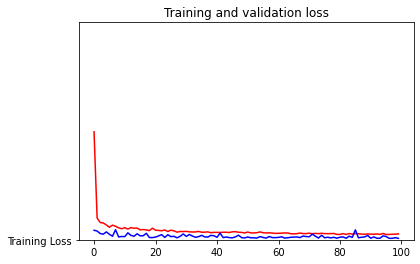

In [28]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


loss_amd_6fc13lbi=history_amd_6fc13lbi.history['loss']
val_loss_amd_6fc13lbi=history_amd_6fc13lbi.history['val_loss']

epochs=range(len(loss_amd_6fc13lbi)) 


plt.plot(epochs, loss_amd_6fc13lbi, 'r', "Training Loss")
plt.plot(epochs, val_loss_amd_6fc13lbi, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [29]:
y_pred_amd_6fc13lbi=making_y_pred(model_amd_6fc13lbi,X_test_amd)
mse_amd_6fc13lbi,rmse_amd_6fc13lbi,r_amd_6fc13lbi,mape_amd_6fc13lbi=Evalu(model_amd_6fc13lbi,X_test_amd,y_test_amd,y_pred_amd_6fc13lbi)

MSE: 0.0007241313526387734  RMSE: 0.026909688824636627 R^2 score: 0.9746028135667563 MAPE: 0.043865686660068216


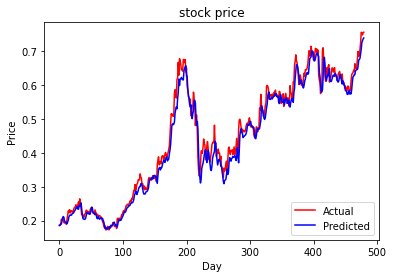

In [30]:
testset_plot(y_test_amd,y_pred_amd_6fc13lbi)

#### 1 conv1d+3 bi-LSTM+ 3DNN

In [297]:
model_amd_testing_windowsize = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(7,kernel_size=2,input_shape=(20,7)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1)
    
])
model_amd_testing_windowsize.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_amd_testing_windowsize = model_amd_testing_windowsize.fit(X_train_amd,y_train_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/100
70/70 [==============================] - 4s 61ms/step - loss: 0.0052 - val_loss: 1.3069e-04
Epoch 2/100
70/70 [==============================] - 1s 18ms/step - loss: 7.6144e-04 - val_loss: 8.9926e-04
Epoch 3/100
70/70 [==============================] - 1s 18ms/step - loss: 6.1948e-04 - val_loss: 0.0012
Epoch 4/100
70/70 [==============================] - 1s 18ms/step - loss: 5.1260e-04 - val_loss: 5.5327e-04
Epoch 5/100
70/70 [==============================] - 1s 18ms/step - loss: 5.9938e-04 - val_loss: 9.7586e-04
Epoch 6/100
70/70 [==============================] - 1s 18ms/step - loss: 4.2883e-04 - val_loss: 4.1363e-04
Epoch 7/100
70/70 [==============================] - 1s 18ms/step - loss: 5.1208e-04 - val_loss: 6.0846e-04
Epoch 8/100
70/70 [==============================] - 1s 18ms/step - loss: 4.4201e-04 - val_loss: 4.6900e-04
Epoch 9/100
70/70 [==============================] - 1s 18ms/step - loss: 4.4296e-04 - val_loss: 4.1095e-04
Epoch 10/100
70/70 [================

70/70 [==============================] - 1s 18ms/step - loss: 2.7555e-04 - val_loss: 8.0100e-05
Epoch 77/100
70/70 [==============================] - 1s 18ms/step - loss: 3.0304e-04 - val_loss: 2.1599e-04
Epoch 78/100
70/70 [==============================] - 1s 18ms/step - loss: 2.9769e-04 - val_loss: 2.0386e-04
Epoch 79/100
70/70 [==============================] - 1s 18ms/step - loss: 2.7264e-04 - val_loss: 1.5291e-04
Epoch 80/100
70/70 [==============================] - 1s 18ms/step - loss: 2.4783e-04 - val_loss: 1.2628e-04
Epoch 81/100
70/70 [==============================] - 1s 18ms/step - loss: 2.9095e-04 - val_loss: 1.3853e-04
Epoch 82/100
70/70 [==============================] - 1s 18ms/step - loss: 2.7610e-04 - val_loss: 1.0577e-04
Epoch 83/100
70/70 [==============================] - 1s 18ms/step - loss: 3.0927e-04 - val_loss: 1.0817e-04
Epoch 84/100
70/70 [==============================] - 1s 18ms/step - loss: 2.9412e-04 - val_loss: 5.8328e-05
Epoch 85/100
70/70 [============

MSE: 0.001287071865922088  RMSE: 0.03587578383704094 R^2 score: 0.9548590127845047 MAPE: 0.060495752581874104


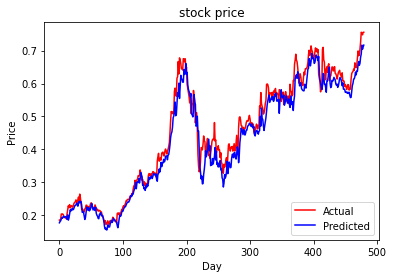

In [298]:
y_pred_amd_testing_windowsize=making_y_pred(model_amd_testing_windowsize,X_test_amd)
mse_amd_testing_windowsize,rmse_amd_testing_windowsize,r_amd_testing_windowsize,mape_amd_testing_windowsize=Evalu(model_amd_testing_windowsize,X_test_amd,y_test_amd,y_pred_amd_testing_windowsize)
testset_plot(y_test_amd,y_pred_amd_testing_windowsize)

#### 3CNN+ 3bi-LSTM

In [299]:
model_amd_testing_windowsize = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(7,kernel_size=2,input_shape=(20,7)),
    tf.keras.layers.Conv1D(64,kernel_size=2),
    tf.keras.layers.Conv1D(128,kernel_size=2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(128),
#     tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1)
    
])
model_amd_testing_windowsize.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_amd_testing_windowsize = model_amd_testing_windowsize.fit(X_train_amd,y_train_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/100
70/70 [==============================] - 2s 34ms/step - loss: 0.0046 - val_loss: 9.4465e-04
Epoch 2/100
70/70 [==============================] - 1s 18ms/step - loss: 9.1190e-04 - val_loss: 3.0500e-04
Epoch 3/100
70/70 [==============================] - 1s 18ms/step - loss: 8.0069e-04 - val_loss: 3.1466e-04
Epoch 4/100
70/70 [==============================] - 1s 18ms/step - loss: 7.5328e-04 - val_loss: 1.3489e-04
Epoch 5/100
70/70 [==============================] - 1s 18ms/step - loss: 6.6604e-04 - val_loss: 4.8045e-04
Epoch 6/100
70/70 [==============================] - 1s 18ms/step - loss: 6.8651e-04 - val_loss: 2.1908e-04
Epoch 7/100
70/70 [==============================] - 1s 18ms/step - loss: 6.1828e-04 - val_loss: 3.7289e-04
Epoch 8/100
70/70 [==============================] - 1s 18ms/step - loss: 6.4447e-04 - val_loss: 4.5076e-04
Epoch 9/100
70/70 [==============================] - 1s 18ms/step - loss: 6.2069e-04 - val_loss: 1.2933e-04
Epoch 10/100
70/70 [============

70/70 [==============================] - 1s 18ms/step - loss: 2.9401e-04 - val_loss: 8.1286e-05
Epoch 77/100
70/70 [==============================] - 1s 18ms/step - loss: 2.5589e-04 - val_loss: 6.6758e-05
Epoch 78/100
70/70 [==============================] - 1s 18ms/step - loss: 2.4980e-04 - val_loss: 9.8012e-05
Epoch 79/100
70/70 [==============================] - 1s 18ms/step - loss: 2.6833e-04 - val_loss: 8.1963e-05
Epoch 80/100
70/70 [==============================] - 1s 18ms/step - loss: 2.4538e-04 - val_loss: 6.3352e-05
Epoch 81/100
70/70 [==============================] - 1s 18ms/step - loss: 2.6645e-04 - val_loss: 8.6560e-05
Epoch 82/100
70/70 [==============================] - 1s 18ms/step - loss: 2.5695e-04 - val_loss: 5.4827e-05
Epoch 83/100
70/70 [==============================] - 1s 18ms/step - loss: 2.8242e-04 - val_loss: 5.8845e-05
Epoch 84/100
70/70 [==============================] - 1s 18ms/step - loss: 2.8258e-04 - val_loss: 7.2182e-05
Epoch 85/100
70/70 [============

MSE: 0.0008194435371221185  RMSE: 0.028625924214287272 R^2 score: 0.9712599651872983 MAPE: 0.046607060878968036


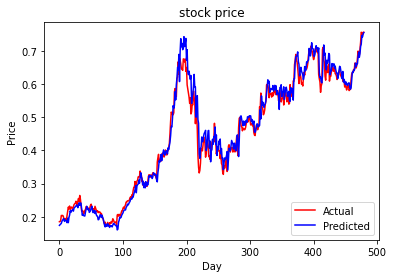

In [300]:
y_pred_amd_testing_windowsize=making_y_pred(model_amd_testing_windowsize,X_test_amd)
mse_amd_testing_windowsize,rmse_amd_testing_windowsize,r_amd_testing_windowsize,mape_amd_testing_windowsize=Evalu(model_amd_testing_windowsize,X_test_amd,y_test_amd,y_pred_amd_testing_windowsize)
testset_plot(y_test_amd,y_pred_amd_testing_windowsize)

#### 3CNN+3 bi-LSTM+3DNN

In [301]:
model_amd_testing_windowsize = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(7,kernel_size=1,input_shape=(20,7)),
    tf.keras.layers.Conv1D(64,kernel_size=2),
    tf.keras.layers.Conv1D(128,kernel_size=2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1)
    
])
model_amd_testing_windowsize.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_amd_testing_windowsize = model_amd_testing_windowsize.fit(X_train_amd,y_train_amd,epochs = 20 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/100
70/70 [==============================] - 5s 69ms/step - loss: 0.0051 - val_loss: 0.0053
Epoch 2/100
70/70 [==============================] - 1s 20ms/step - loss: 9.5293e-04 - val_loss: 0.0019
Epoch 3/100
70/70 [==============================] - 1s 20ms/step - loss: 8.4937e-04 - val_loss: 0.0011
Epoch 4/100
70/70 [==============================] - 1s 20ms/step - loss: 8.2651e-04 - val_loss: 6.0277e-04
Epoch 5/100
70/70 [==============================] - 1s 20ms/step - loss: 7.3322e-04 - val_loss: 0.0011
Epoch 6/100
70/70 [==============================] - 1s 20ms/step - loss: 5.5849e-04 - val_loss: 7.3767e-04
Epoch 7/100
70/70 [==============================] - 1s 20ms/step - loss: 5.0429e-04 - val_loss: 5.2371e-04
Epoch 8/100
70/70 [==============================] - 1s 20ms/step - loss: 6.0644e-04 - val_loss: 4.3114e-04
Epoch 9/100
70/70 [==============================] - 1s 20ms/step - loss: 5.0767e-04 - val_loss: 3.8782e-04
Epoch 10/100
70/70 [============================

70/70 [==============================] - 1s 20ms/step - loss: 2.8626e-04 - val_loss: 9.1544e-05
Epoch 77/100
70/70 [==============================] - 1s 20ms/step - loss: 2.4813e-04 - val_loss: 9.1602e-05
Epoch 78/100
70/70 [==============================] - 1s 20ms/step - loss: 2.6894e-04 - val_loss: 6.0708e-05
Epoch 79/100
70/70 [==============================] - 1s 20ms/step - loss: 2.4741e-04 - val_loss: 6.1810e-05
Epoch 80/100
70/70 [==============================] - 1s 20ms/step - loss: 2.8520e-04 - val_loss: 7.2888e-05
Epoch 81/100
70/70 [==============================] - 1s 20ms/step - loss: 3.3346e-04 - val_loss: 1.7125e-04
Epoch 82/100
70/70 [==============================] - 1s 20ms/step - loss: 2.8434e-04 - val_loss: 1.1398e-04
Epoch 83/100
70/70 [==============================] - 1s 19ms/step - loss: 2.4397e-04 - val_loss: 6.2113e-05
Epoch 84/100
70/70 [==============================] - 1s 20ms/step - loss: 2.8210e-04 - val_loss: 1.1662e-04
Epoch 85/100
70/70 [============

MSE: 0.0006865925625435948  RMSE: 0.02620291133717005 R^2 score: 0.975919397425543 MAPE: 0.044481973776564966


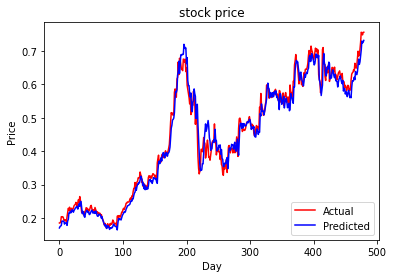

In [302]:
y_pred_amd_testing_windowsize=making_y_pred(model_amd_testing_windowsize,X_test_amd)
mse_amd_testing_windowsize,rmse_amd_testing_windowsize,r_amd_testing_windowsize,mape_amd_testing_windowsize=Evalu(model_amd_testing_windowsize,X_test_amd,y_test_amd,y_pred_amd_testing_windowsize)
testset_plot(y_test_amd,y_pred_amd_testing_windowsize)

#### Wavenet

In [31]:
model_amd_wave = tf.keras.models.Sequential()
model_amd_wave.add(tf.keras.layers.Conv1D(6,kernel_size=2,input_shape=(20,7)))
for rate in (1, 2, 4, 8) * 2:
    model_amd_wave.add(tf.keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model_amd_wave.add(tf.keras.layers.Conv1D(filters=10, kernel_size=1))
model_amd_wave.add(tf.keras.layers.LSTM(1))
model_amd_wave.add(tf.keras.layers.Dense(100))
model_amd_wave.add(tf.keras.layers.Dense(1))
model_amd_wave.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_amd_wave = model_amd_wave.fit(X_train_amd,y_train_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/100
70/70 [==============================] - 1s 17ms/step - loss: 0.0156 - val_loss: 0.0022
Epoch 2/100
70/70 [==============================] - 1s 10ms/step - loss: 0.0013 - val_loss: 3.8488e-04
Epoch 3/100
70/70 [==============================] - 1s 10ms/step - loss: 8.3117e-04 - val_loss: 2.6118e-04
Epoch 4/100
70/70 [==============================] - 1s 10ms/step - loss: 5.5942e-04 - val_loss: 2.7069e-04
Epoch 5/100
70/70 [==============================] - 1s 10ms/step - loss: 5.2093e-04 - val_loss: 2.3369e-04
Epoch 6/100
70/70 [==============================] - 1s 10ms/step - loss: 4.4983e-04 - val_loss: 2.3468e-04
Epoch 7/100
70/70 [==============================] - 1s 10ms/step - loss: 4.3138e-04 - val_loss: 2.4220e-04
Epoch 8/100
70/70 [==============================] - 1s 10ms/step - loss: 3.7297e-04 - val_loss: 2.0193e-04
Epoch 9/100
70/70 [==============================] - 1s 10ms/step - loss: 3.7704e-04 - val_loss: 3.0565e-04
Epoch 10/100
70/70 [====================

In [32]:
model_amd_wave.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 19, 6)             78        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 19, 20)            260       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 19, 20)            820       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 19, 20)            820       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 19, 20)            820       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 19, 20)            820       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 19, 20)           

MSE: 0.0011028149032199272  RMSE: 0.03320865705233994 R^2 score: 0.9613213878996234 MAPE: 0.05155982382188525


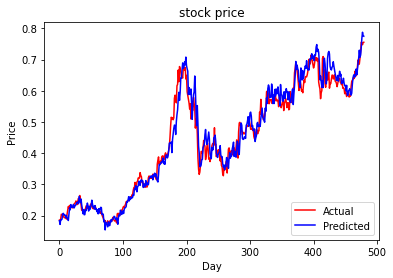

In [33]:
y_pred_amd_wave=making_y_pred(model_amd_wave,X_test_amd)
mse_amd_wave,rmse_amd_wave,r_amd_wave,mape_amd_wave=Evalu(model_amd_wave,X_test_amd,y_test_amd,y_pred_amd_wave)
testset_plot(y_test_amd,y_pred_amd_wave)

#### Conclusion

In [326]:
model_selection=pd.DataFrame(columns=(['Linear','1RNN','uLSTM','bLSTM','C-LSTM','C-LSTM-3D','3C-LSTM','3C-LSTM-3D','Wavenet']),
                     index=(['RMSE','MAPE']))

In [327]:
model_selection.iloc[0,0]=0.022100565369301516 
model_selection.iloc[0,1]=0.03389287690398782 
model_selection.iloc[0,2]=0.03498881855213351     
model_selection.iloc[0,3]=0.02957495551235984   
model_selection.iloc[0,4]=0.026909688824636627 
model_selection.iloc[0,5]=0.03587578383704094 
model_selection.iloc[0,6]=0.028625924214287272   
model_selection.iloc[0,7]=0.02620291133717005 
model_selection.iloc[0,8]=0.03320865705233994 
model_selection.iloc[1,0]=0.03546908124523461
model_selection.iloc[1,1]=0.06550389442172808
model_selection.iloc[1,2]=0.05442407988557649   
model_selection.iloc[1,3]=0.04709533920684883
model_selection.iloc[1,4]=0.043865686660068216
model_selection.iloc[1,5]=0.060495752581874104
model_selection.iloc[1,6]=0.046607060878968036
model_selection.iloc[1,7]=0.044481973776564966
model_selection.iloc[1,8]=0.05155982382188525

In [328]:
model_selection

Linear       1RNN      uLSTM      bLSTM     C-LSTM  C-LSTM-3D  \
RMSE  0.0221006  0.0338929  0.0349888   0.029575  0.0269097  0.0358758   
MAPE  0.0354691  0.0655039  0.0544241  0.0470953  0.0438657  0.0604958   

        3C-LSTM 3C-LSTM-3D    Wavenet  
RMSE  0.0286259  0.0262029  0.0332087  
MAPE  0.0466071   0.044482  0.0515598

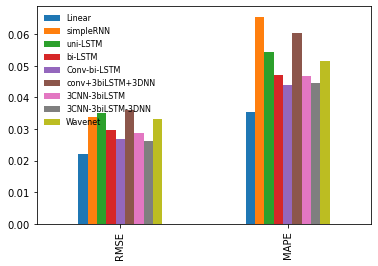

In [322]:
ax=model_selection.plot(kind='bar')
ax.legend(loc='upper left',fontsize=8, framealpha=0.0)

## Number of layers

#### One layer

In [74]:
model_amd_6f3l = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(6,input_shape = (20,7),return_sequences = True,
               activation = 'relu'),
#     tf.keras.layers.LSTM(40,activation = 'relu',return_sequences = True),
#     tf.keras.layers.LSTM(40,activation = 'relu'),
    tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
model_amd_6f3l.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_amd_6f3l = model_amd_6f3l.fit(X_train_amd,y_train_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/100
70/70 [==============================] - 1s 11ms/step - loss: 0.0135 - val_loss: 0.0032
Epoch 2/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0044 - val_loss: 0.0058
Epoch 3/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0035
Epoch 4/100
70/70 [==============================] - 0s 3ms/step - loss: 7.5909e-04 - val_loss: 0.0011
Epoch 5/100
70/70 [==============================] - 0s 3ms/step - loss: 5.8995e-04 - val_loss: 4.5036e-04
Epoch 6/100
70/70 [==============================] - 0s 3ms/step - loss: 5.3254e-04 - val_loss: 2.9148e-04
Epoch 7/100
70/70 [==============================] - 0s 3ms/step - loss: 5.2146e-04 - val_loss: 4.8756e-04
Epoch 8/100
70/70 [==============================] - 0s 3ms/step - loss: 4.6476e-04 - val_loss: 2.4561e-04
Epoch 9/100
70/70 [==============================] - 0s 3ms/step - loss: 4.4108e-04 - val_loss: 2.3361e-04
Epoch 10/100
70/70 [==============================] - 0s 3ms/ste

70/70 [==============================] - 0s 3ms/step - loss: 1.5596e-04 - val_loss: 1.0175e-04
Epoch 78/100
70/70 [==============================] - 0s 3ms/step - loss: 1.5074e-04 - val_loss: 1.1048e-04
Epoch 79/100
70/70 [==============================] - 0s 3ms/step - loss: 1.5896e-04 - val_loss: 9.0321e-05
Epoch 80/100
70/70 [==============================] - 0s 3ms/step - loss: 1.6511e-04 - val_loss: 9.6460e-05
Epoch 81/100
70/70 [==============================] - 0s 3ms/step - loss: 1.5682e-04 - val_loss: 1.3493e-04
Epoch 82/100
70/70 [==============================] - 0s 3ms/step - loss: 1.5337e-04 - val_loss: 1.0137e-04
Epoch 83/100
70/70 [==============================] - 0s 3ms/step - loss: 1.4547e-04 - val_loss: 8.6222e-05
Epoch 84/100
70/70 [==============================] - 0s 3ms/step - loss: 1.6780e-04 - val_loss: 9.1823e-05
Epoch 85/100
70/70 [==============================] - 0s 3ms/step - loss: 1.5165e-04 - val_loss: 8.8526e-05
Epoch 86/100
70/70 [=====================

In [75]:
model_amd_6f3l.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 20, 6)             336       
_________________________________________________________________
flatten_2 (Flatten)          (None, 120)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 121       
Total params: 457
Trainable params: 457
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

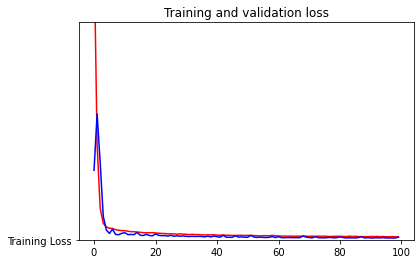

In [76]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


loss_amd_6f3l=history_amd_6f3l.history['loss']
val_loss_amd_6f3l=history_amd_6f3l.history['val_loss']

epochs=range(len(loss_amd_6f3l)) 


plt.plot(epochs, loss_amd_6f3l, 'r', "Training Loss")
plt.plot(epochs, val_loss_amd_6f3l, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [77]:
y_pred_amd_6f3l=making_y_pred(model_amd_6f3l,X_test_amd)
mse_amd_6f3l,rmse_amd_6f3l,r_amd_6f3l,mape_amd_6f3l=Evalu(model_amd_6f3l,X_test_amd,y_test_amd,y_pred_amd_6f3l)

MSE: 0.0013106432365450106  RMSE: 0.03620280702576819 R^2 score: 0.954032302972789 MAPE: 0.06099172427666186


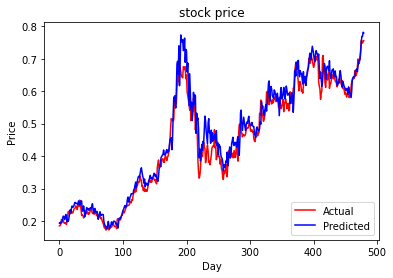

In [78]:
testset_plot(y_test_amd,y_pred_amd_6f3l)

#### Two layers

In [34]:
model_amd_6f3l = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(6,input_shape = (20,7),return_sequences = True,
               activation = 'relu'),
    tf.keras.layers.LSTM(40,activation = 'relu',return_sequences = True),
#     tf.keras.layers.LSTM(40,activation = 'relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
model_amd_6f3l.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_amd_6f3l = model_amd_6f3l.fit(X_train_amd,y_train_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/100
70/70 [==============================] - 1s 11ms/step - loss: 0.0056 - val_loss: 7.4593e-04
Epoch 2/100
70/70 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 3/100
70/70 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 5.9044e-04
Epoch 4/100
70/70 [==============================] - 1s 7ms/step - loss: 9.9628e-04 - val_loss: 3.8813e-04
Epoch 5/100
70/70 [==============================] - 1s 7ms/step - loss: 9.7749e-04 - val_loss: 4.9480e-04
Epoch 6/100
70/70 [==============================] - 1s 7ms/step - loss: 8.2448e-04 - val_loss: 6.8696e-04
Epoch 7/100
70/70 [==============================] - 1s 7ms/step - loss: 7.8638e-04 - val_loss: 5.0659e-04
Epoch 8/100
70/70 [==============================] - 1s 7ms/step - loss: 7.7748e-04 - val_loss: 3.0793e-04
Epoch 9/100
70/70 [==============================] - 1s 7ms/step - loss: 7.1269e-04 - val_loss: 4.2132e-04
Epoch 10/100
70/70 [==============================] 

70/70 [==============================] - 1s 7ms/step - loss: 2.0137e-04 - val_loss: 8.4747e-05
Epoch 78/100
70/70 [==============================] - 1s 7ms/step - loss: 2.0213e-04 - val_loss: 1.4353e-04
Epoch 79/100
70/70 [==============================] - 1s 7ms/step - loss: 2.1173e-04 - val_loss: 7.7670e-05
Epoch 80/100
70/70 [==============================] - 1s 7ms/step - loss: 1.9122e-04 - val_loss: 1.0202e-04
Epoch 81/100
70/70 [==============================] - 1s 7ms/step - loss: 1.8719e-04 - val_loss: 7.5403e-05
Epoch 82/100
70/70 [==============================] - 1s 7ms/step - loss: 1.9581e-04 - val_loss: 8.2631e-05
Epoch 83/100
70/70 [==============================] - 1s 7ms/step - loss: 2.0529e-04 - val_loss: 8.3638e-05
Epoch 84/100
70/70 [==============================] - 1s 7ms/step - loss: 2.0237e-04 - val_loss: 9.5946e-05
Epoch 85/100
70/70 [==============================] - 1s 7ms/step - loss: 2.1090e-04 - val_loss: 1.6026e-04
Epoch 86/100
70/70 [=====================

In [35]:
model_amd_6f3l.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 20, 6)             336       
_________________________________________________________________
lstm_4 (LSTM)                (None, 20, 40)            7520      
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 800)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 801       
Total params: 8,657
Trainable params: 8,657
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

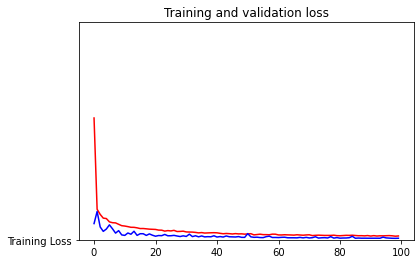

In [36]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


loss_amd_6f3l=history_amd_6f3l.history['loss']
val_loss_amd_6f3l=history_amd_6f3l.history['val_loss']

epochs=range(len(loss_amd_6f3l)) 


plt.plot(epochs, loss_amd_6f3l, 'r', "Training Loss")
plt.plot(epochs, val_loss_amd_6f3l, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [37]:
y_pred_amd_6f3l=making_y_pred(model_amd_6f3l,X_test_amd)
mse_amd_6f3l,rmse_amd_6f3l,r_amd_6f3l,mape_amd_6f3l=Evalu(model_amd_6f3l,X_test_amd,y_test_amd,y_pred_amd_6f3l)

MSE: 0.0022305100485063628  RMSE: 0.047228275942557574 R^2 score: 0.9217701604319315 MAPE: 0.07211678022581824


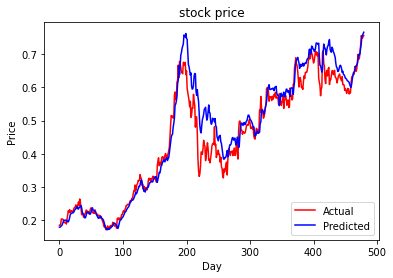

In [38]:
testset_plot(y_test_amd,y_pred_amd_6f3l)

#### Three layers

In [39]:
model_amd_6f3l = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(6,input_shape = (20,7),return_sequences = True,
               activation = 'relu'),
    tf.keras.layers.LSTM(40,activation = 'relu',return_sequences = True),
    tf.keras.layers.LSTM(40,activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
model_amd_6f3l.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_amd_6f3l = model_amd_6f3l.fit(X_train_amd,y_train_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/100
70/70 [==============================] - 1s 21ms/step - loss: 0.0173 - val_loss: 0.0030
Epoch 2/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0025 - val_loss: 7.8417e-04
Epoch 3/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0020 - val_loss: 4.0894e-04
Epoch 4/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0016 - val_loss: 3.4407e-04
Epoch 5/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0014 - val_loss: 2.8692e-04
Epoch 6/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0013 - val_loss: 2.8173e-04
Epoch 7/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0012 - val_loss: 4.9857e-04
Epoch 8/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0011 - val_loss: 7.4975e-04
Epoch 9/100
70/70 [==============================] - 1s 12ms/step - loss: 9.9903e-04 - val_loss: 6.7752e-04
Epoch 10/100
70/70 [==============================] - 1s 12ms/st

Epoch 77/100
70/70 [==============================] - 1s 12ms/step - loss: 5.0268e-04 - val_loss: 1.1546e-04
Epoch 78/100
70/70 [==============================] - 1s 12ms/step - loss: 4.4376e-04 - val_loss: 1.2314e-04
Epoch 79/100
70/70 [==============================] - 1s 12ms/step - loss: 4.6166e-04 - val_loss: 1.3860e-04
Epoch 80/100
70/70 [==============================] - 1s 12ms/step - loss: 4.5996e-04 - val_loss: 1.4838e-04
Epoch 81/100
70/70 [==============================] - 1s 12ms/step - loss: 4.5189e-04 - val_loss: 1.1310e-04
Epoch 82/100
70/70 [==============================] - 1s 12ms/step - loss: 4.6484e-04 - val_loss: 1.1521e-04
Epoch 83/100
70/70 [==============================] - 1s 12ms/step - loss: 4.5262e-04 - val_loss: 1.0476e-04
Epoch 84/100
70/70 [==============================] - 1s 12ms/step - loss: 4.7445e-04 - val_loss: 1.2426e-04
Epoch 85/100
70/70 [==============================] - 1s 12ms/step - loss: 4.5576e-04 - val_loss: 1.0757e-04
Epoch 86/100
70/70 

In [40]:
model_amd_6f3l.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 20, 6)             336       
_________________________________________________________________
lstm_6 (LSTM)                (None, 20, 40)            7520      
_________________________________________________________________
lstm_7 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_4 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 41        
Total params: 20,857
Trainable params: 20,857
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

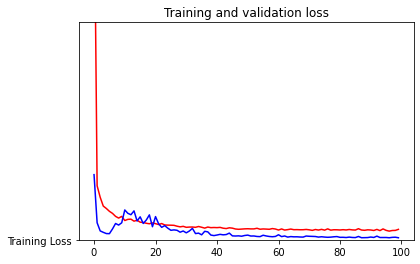

In [41]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


loss_amd_6f3l=history_amd_6f3l.history['loss']
val_loss_amd_6f3l=history_amd_6f3l.history['val_loss']

epochs=range(len(loss_amd_6f3l)) 


plt.plot(epochs, loss_amd_6f3l, 'r', "Training Loss")
plt.plot(epochs, val_loss_amd_6f3l, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [42]:
y_pred_amd_6f3l=making_y_pred(model_amd_6f3l,X_test_amd)
mse_amd_6f3l,rmse_amd_6f3l,r_amd_6f3l,mape_amd_6f3l=Evalu(model_amd_6f3l,X_test_amd,y_test_amd,y_pred_amd_6f3l)

MSE: 0.0009107949855706675  RMSE: 0.030179380138940354 R^2 score: 0.9680560302123242 MAPE: 0.048602815476114704


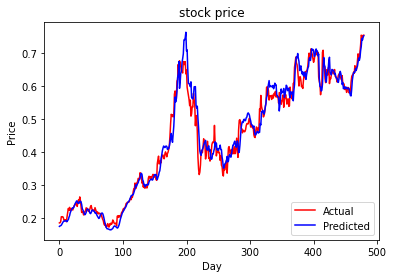

In [43]:
testset_plot(y_test_amd,y_pred_amd_6f3l)

#### Four layers

In [44]:
model_amd_6f3l = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(6,input_shape = (20,7),return_sequences = True,
               activation = 'relu'),
    tf.keras.layers.LSTM(40,activation = 'relu',return_sequences = True),
    tf.keras.layers.LSTM(35,activation = 'relu',return_sequences = True),
    tf.keras.layers.LSTM(35,activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
model_amd_6f3l.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_amd_6f3l = model_amd_6f3l.fit(X_train_amd,y_train_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/100
70/70 [==============================] - 2s 23ms/step - loss: 0.0115 - val_loss: 0.0023
Epoch 2/100
70/70 [==============================] - 1s 16ms/step - loss: 0.0026 - val_loss: 9.2767e-04
Epoch 3/100
70/70 [==============================] - 1s 16ms/step - loss: 0.0021 - val_loss: 6.0690e-04
Epoch 4/100
70/70 [==============================] - 1s 16ms/step - loss: 0.0018 - val_loss: 7.1908e-04
Epoch 5/100
70/70 [==============================] - 1s 16ms/step - loss: 0.0016 - val_loss: 4.0766e-04
Epoch 6/100
70/70 [==============================] - 1s 16ms/step - loss: 0.0016 - val_loss: 6.1680e-04
Epoch 7/100
70/70 [==============================] - 1s 16ms/step - loss: 0.0014 - val_loss: 3.6534e-04
Epoch 8/100
70/70 [==============================] - 1s 16ms/step - loss: 0.0012 - val_loss: 4.1999e-04
Epoch 9/100
70/70 [==============================] - 1s 16ms/step - loss: 0.0013 - val_loss: 4.4706e-04
Epoch 10/100
70/70 [==============================] - 1s 16ms/step -

Epoch 77/100
70/70 [==============================] - 1s 16ms/step - loss: 5.2281e-04 - val_loss: 1.7027e-04
Epoch 78/100
70/70 [==============================] - 1s 16ms/step - loss: 5.2261e-04 - val_loss: 9.9423e-05
Epoch 79/100
70/70 [==============================] - 1s 16ms/step - loss: 5.3147e-04 - val_loss: 1.3363e-04
Epoch 80/100
70/70 [==============================] - 1s 16ms/step - loss: 4.9686e-04 - val_loss: 1.9358e-04
Epoch 81/100
70/70 [==============================] - 1s 16ms/step - loss: 5.5186e-04 - val_loss: 1.0387e-04
Epoch 82/100
70/70 [==============================] - 1s 16ms/step - loss: 5.2003e-04 - val_loss: 1.2915e-04
Epoch 83/100
70/70 [==============================] - 1s 16ms/step - loss: 5.4523e-04 - val_loss: 1.4307e-04
Epoch 84/100
70/70 [==============================] - 1s 16ms/step - loss: 5.1009e-04 - val_loss: 9.8207e-05
Epoch 85/100
70/70 [==============================] - 1s 17ms/step - loss: 5.6747e-04 - val_loss: 1.1435e-04
Epoch 86/100
70/70 

In [45]:
model_amd_6f3l.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 20, 6)             336       
_________________________________________________________________
lstm_9 (LSTM)                (None, 20, 40)            7520      
_________________________________________________________________
lstm_10 (LSTM)               (None, 20, 35)            10640     
_________________________________________________________________
lstm_11 (LSTM)               (None, 35)                9940      
_________________________________________________________________
dropout_5 (Dropout)          (None, 35)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 36        
Total params: 28,472
Trainable params: 28,472
Non-trainable params: 0
__________________________________________________

Text(0.5, 1.0, 'Training and validation loss')

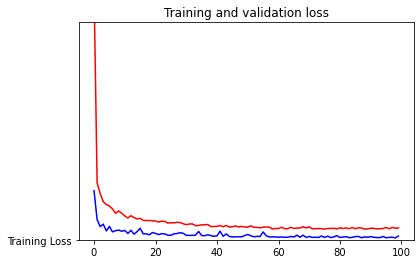

In [46]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


loss_amd_6f3l=history_amd_6f3l.history['loss']
val_loss_amd_6f3l=history_amd_6f3l.history['val_loss']

epochs=range(len(loss_amd_6f3l)) 


plt.plot(epochs, loss_amd_6f3l, 'r', "Training Loss")
plt.plot(epochs, val_loss_amd_6f3l, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [47]:
y_pred_amd_6f3l=making_y_pred(model_amd_6f3l,X_test_amd)
mse_amd_6f3l,rmse_amd_6f3l,r_amd_6f3l,mape_amd_6f3l=Evalu(model_amd_6f3l,X_test_amd,y_test_amd,y_pred_amd_6f3l)

MSE: 0.0011262817044920554  RMSE: 0.03356012074608873 R^2 score: 0.9604983456093976 MAPE: 0.06567297573657777


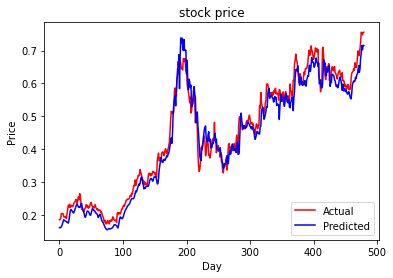

In [48]:
testset_plot(y_test_amd,y_pred_amd_6f3l)

#### Conclusion

In [131]:
model_selection=pd.DataFrame(columns=(['1 Layer','2 Layers','3 Layers','4 Layers']),
                     index=(['RMSE','MAPE']))

In [132]:
model_selection.iloc[0,0]=0.03620280702576819 
model_selection.iloc[0,1]=0.047228275942557574 
model_selection.iloc[0,2]=0.030179380138940354     
model_selection.iloc[0,3]=0.03356012074608873 
model_selection.iloc[1,0]=0.06099172427666186
model_selection.iloc[1,1]=0.07211678022581824
model_selection.iloc[1,2]=0.048602815476114704   
model_selection.iloc[1,3]=0.06567297573657777

In [133]:
model_selection

1 Layer   2 Layers   3 Layers   4 Layers
RMSE  0.0362028  0.0472283  0.0301794  0.0335601
MAPE  0.0609917  0.0721168  0.0486028   0.065673

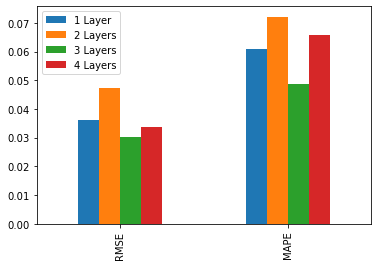

In [134]:
model_selection.plot(kind='bar')

Best one: 3layers R^2 score: 0.9680560302123242 MAPE: 0.048602815476114704

## Units

#### 50-30

In [165]:
%%time

model_amd_6f3l = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(7,input_shape = (20,7),return_sequences = True,
               activation = 'relu'),
    tf.keras.layers.LSTM(50,activation = 'relu',return_sequences = True),
    tf.keras.layers.LSTM(30,activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
model_amd_6f3l.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_amd_6f3l = model_amd_6f3l.fit(X_train_amd,y_train_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/100
70/70 [==============================] - 1s 18ms/step - loss: 0.0138 - val_loss: 0.0020
Epoch 2/100
70/70 [==============================] - 1s 13ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 3/100
70/70 [==============================] - 1s 13ms/step - loss: 0.0024 - val_loss: 6.4187e-04
Epoch 4/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 5/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 6/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0016 - val_loss: 4.8471e-04
Epoch 7/100
70/70 [==============================] - 1s 13ms/step - loss: 0.0015 - val_loss: 8.1087e-04
Epoch 8/100
70/70 [==============================] - 1s 13ms/step - loss: 0.0015 - val_loss: 4.5692e-04
Epoch 9/100
70/70 [==============================] - 1s 13ms/step - loss: 0.0014 - val_loss: 2.9895e-04
Epoch 10/100
70/70 [==============================] - 1s 13ms/step - loss: 0.001

70/70 [==============================] - 1s 13ms/step - loss: 5.8967e-04 - val_loss: 8.8895e-05
Epoch 78/100
70/70 [==============================] - 1s 13ms/step - loss: 6.3803e-04 - val_loss: 9.9895e-05
Epoch 79/100
70/70 [==============================] - 1s 13ms/step - loss: 6.6195e-04 - val_loss: 1.1842e-04
Epoch 80/100
70/70 [==============================] - 1s 13ms/step - loss: 6.2948e-04 - val_loss: 2.2046e-04
Epoch 81/100
70/70 [==============================] - 1s 13ms/step - loss: 6.1338e-04 - val_loss: 1.7086e-04
Epoch 82/100
70/70 [==============================] - 1s 13ms/step - loss: 6.1681e-04 - val_loss: 1.1289e-04
Epoch 83/100
70/70 [==============================] - 1s 13ms/step - loss: 5.7407e-04 - val_loss: 8.6205e-05
Epoch 84/100
70/70 [==============================] - 1s 13ms/step - loss: 5.8398e-04 - val_loss: 1.3833e-04
Epoch 85/100
70/70 [==============================] - 1s 13ms/step - loss: 6.1986e-04 - val_loss: 1.9682e-04
Epoch 86/100
70/70 [============

In [136]:
model_amd_6f3l.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 20, 7)             420       
_________________________________________________________________
lstm_36 (LSTM)               (None, 20, 50)            11600     
_________________________________________________________________
lstm_37 (LSTM)               (None, 30)                9720      
_________________________________________________________________
dropout_12 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 31        
Total params: 21,771
Trainable params: 21,771
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

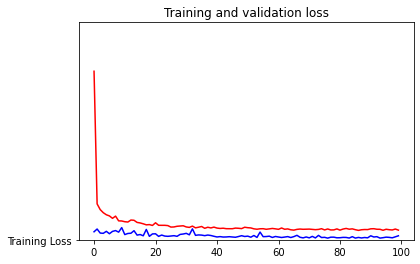

In [137]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


loss_amd_6f3l=history_amd_6f3l.history['loss']
val_loss_amd_6f3l=history_amd_6f3l.history['val_loss']

epochs=range(len(loss_amd_6f3l)) 


plt.plot(epochs, loss_amd_6f3l, 'r', "Training Loss")
plt.plot(epochs, val_loss_amd_6f3l, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [138]:
y_pred_amd_6f3l=making_y_pred(model_amd_6f3l,X_test_amd)
mse_amd_6f3l,rmse_amd_6f3l,r_amd_6f3l,mape_amd_6f3l=Evalu(model_amd_6f3l,X_test_amd,y_test_amd,y_pred_amd_6f3l)

MSE: 0.0008661370277694114  RMSE: 0.029430206043611237 R^2 score: 0.9696223019610524 MAPE: 0.048927276923308


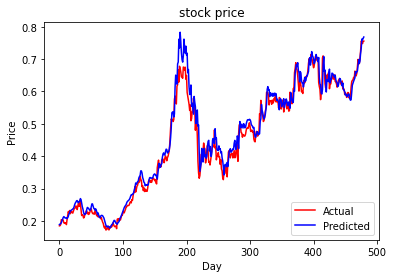

In [139]:
testset_plot(y_test_amd,y_pred_amd_6f3l)

#### 40-40

In [166]:
%%time

model_amd_6f3l = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(7,input_shape = (20,7),return_sequences = True,
               activation = 'relu'),
    tf.keras.layers.LSTM(40,activation = 'relu',return_sequences = True),
    tf.keras.layers.LSTM(40,activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
model_amd_6f3l.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_amd_6f3l = model_amd_6f3l.fit(X_train_amd,y_train_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/100
70/70 [==============================] - 1s 17ms/step - loss: 0.0150 - val_loss: 0.0062
Epoch 2/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0042 - val_loss: 0.0016
Epoch 3/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0017 - val_loss: 2.9513e-04
Epoch 4/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0012 - val_loss: 3.4958e-04
Epoch 5/100
70/70 [==============================] - 1s 12ms/step - loss: 0.0012 - val_loss: 2.4263e-04
Epoch 6/100
70/70 [==============================] - 1s 12ms/step - loss: 9.8598e-04 - val_loss: 2.3511e-04
Epoch 7/100
70/70 [==============================] - 1s 12ms/step - loss: 9.6149e-04 - val_loss: 2.8647e-04
Epoch 8/100
70/70 [==============================] - 1s 12ms/step - loss: 8.9129e-04 - val_loss: 4.0834e-04
Epoch 9/100
70/70 [==============================] - 1s 12ms/step - loss: 9.7978e-04 - val_loss: 2.5942e-04
Epoch 10/100
70/70 [==============================] - 1s

70/70 [==============================] - 1s 12ms/step - loss: 4.6369e-04 - val_loss: 1.0245e-04
Epoch 77/100
70/70 [==============================] - 1s 12ms/step - loss: 5.1526e-04 - val_loss: 1.0883e-04
Epoch 78/100
70/70 [==============================] - 1s 12ms/step - loss: 4.8476e-04 - val_loss: 9.9688e-05
Epoch 79/100
70/70 [==============================] - 1s 12ms/step - loss: 4.9833e-04 - val_loss: 1.0148e-04
Epoch 80/100
70/70 [==============================] - 1s 12ms/step - loss: 4.6854e-04 - val_loss: 1.0893e-04
Epoch 81/100
70/70 [==============================] - 1s 12ms/step - loss: 5.1490e-04 - val_loss: 1.4932e-04
Epoch 82/100
70/70 [==============================] - 1s 12ms/step - loss: 4.9937e-04 - val_loss: 9.5495e-05
Epoch 83/100
70/70 [==============================] - 1s 12ms/step - loss: 4.7258e-04 - val_loss: 1.2242e-04
Epoch 84/100
70/70 [==============================] - 1s 12ms/step - loss: 4.9829e-04 - val_loss: 1.7190e-04
Epoch 85/100
70/70 [============

In [141]:
model_amd_6f3l.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (None, 20, 7)             420       
_________________________________________________________________
lstm_39 (LSTM)               (None, 20, 40)            7680      
_________________________________________________________________
lstm_40 (LSTM)               (None, 40)                12960     
_________________________________________________________________
dropout_13 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 41        
Total params: 21,101
Trainable params: 21,101
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

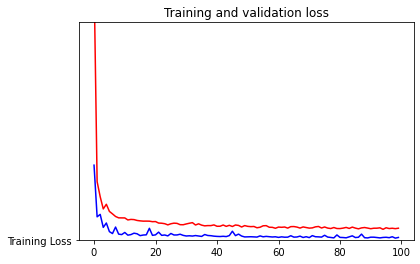

In [142]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


loss_amd_6f3l=history_amd_6f3l.history['loss']
val_loss_amd_6f3l=history_amd_6f3l.history['val_loss']

epochs=range(len(loss_amd_6f3l)) 


plt.plot(epochs, loss_amd_6f3l, 'r', "Training Loss")
plt.plot(epochs, val_loss_amd_6f3l, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [143]:
y_pred_amd_6f3l=making_y_pred(model_amd_6f3l,X_test_amd)
mse_amd_6f3l,rmse_amd_6f3l,r_amd_6f3l,mape_amd_6f3l=Evalu(model_amd_6f3l,X_test_amd,y_test_amd,y_pred_amd_6f3l)

MSE: 0.0007336334624322968  RMSE: 0.02708566894932257 R^2 score: 0.9742695496457068 MAPE: 0.049159491107795605


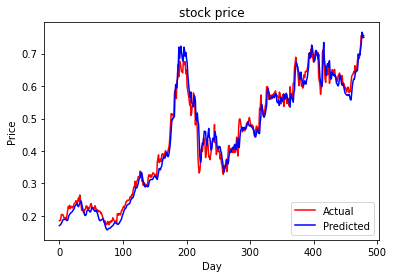

In [144]:
testset_plot(y_test_amd,y_pred_amd_6f3l)

#### 128-64

In [167]:
%%time 

model_amd_6f3l = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(7,input_shape = (20,7),return_sequences = True,
               activation = 'relu'),
    tf.keras.layers.LSTM(128,activation = 'relu',return_sequences = True),
    tf.keras.layers.LSTM(64,activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
model_amd_6f3l.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_amd_6f3l = model_amd_6f3l.fit(X_train_amd,y_train_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/100
70/70 [==============================] - 2s 30ms/step - loss: 0.0124 - val_loss: 5.4391e-04
Epoch 2/100
70/70 [==============================] - 2s 24ms/step - loss: 0.0020 - val_loss: 3.9910e-04
Epoch 3/100
70/70 [==============================] - 2s 24ms/step - loss: 0.0013 - val_loss: 5.1041e-04
Epoch 4/100
70/70 [==============================] - 2s 24ms/step - loss: 0.0012 - val_loss: 2.9982e-04
Epoch 5/100
70/70 [==============================] - 2s 24ms/step - loss: 0.0011 - val_loss: 3.0340e-04
Epoch 6/100
70/70 [==============================] - 2s 24ms/step - loss: 9.4553e-04 - val_loss: 4.4622e-04
Epoch 7/100
70/70 [==============================] - 2s 24ms/step - loss: 9.9736e-04 - val_loss: 4.0400e-04
Epoch 8/100
70/70 [==============================] - 2s 24ms/step - loss: 7.9135e-04 - val_loss: 2.3288e-04
Epoch 9/100
70/70 [==============================] - 2s 24ms/step - loss: 7.8186e-04 - val_loss: 4.9761e-04
Epoch 10/100
70/70 [============================

70/70 [==============================] - 2s 24ms/step - loss: 3.7695e-04 - val_loss: 7.1588e-05
Epoch 77/100
70/70 [==============================] - 2s 24ms/step - loss: 3.8471e-04 - val_loss: 7.1744e-05
Epoch 78/100
70/70 [==============================] - 2s 24ms/step - loss: 3.3802e-04 - val_loss: 7.3802e-05
Epoch 79/100
70/70 [==============================] - 2s 24ms/step - loss: 3.5101e-04 - val_loss: 6.2034e-05
Epoch 80/100
70/70 [==============================] - 2s 24ms/step - loss: 3.6642e-04 - val_loss: 8.2164e-05
Epoch 81/100
70/70 [==============================] - 2s 24ms/step - loss: 3.7356e-04 - val_loss: 2.4447e-04
Epoch 82/100
70/70 [==============================] - 2s 24ms/step - loss: 4.0455e-04 - val_loss: 9.8173e-05
Epoch 83/100
70/70 [==============================] - 2s 24ms/step - loss: 3.6673e-04 - val_loss: 9.1337e-05
Epoch 84/100
70/70 [==============================] - 2s 24ms/step - loss: 3.7355e-04 - val_loss: 6.9146e-05
Epoch 85/100
70/70 [============

In [146]:
model_amd_6f3l.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 20, 7)             420       
_________________________________________________________________
lstm_42 (LSTM)               (None, 20, 128)           69632     
_________________________________________________________________
lstm_43 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 65        
Total params: 119,525
Trainable params: 119,525
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

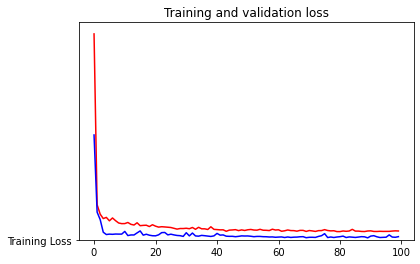

In [147]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


loss_amd_6f3l=history_amd_6f3l.history['loss']
val_loss_amd_6f3l=history_amd_6f3l.history['val_loss']

epochs=range(len(loss_amd_6f3l)) 


plt.plot(epochs, loss_amd_6f3l, 'r', "Training Loss")
plt.plot(epochs, val_loss_amd_6f3l, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [148]:
y_pred_amd_6f3l=making_y_pred(model_amd_6f3l,X_test_amd)
mse_amd_6f3l,rmse_amd_6f3l,r_amd_6f3l,mape_amd_6f3l=Evalu(model_amd_6f3l,X_test_amd,y_test_amd,y_pred_amd_6f3l)

MSE: 0.0007653221359443876  RMSE: 0.027664456183781883 R^2 score: 0.9731581447243813 MAPE: 0.04584388088040543


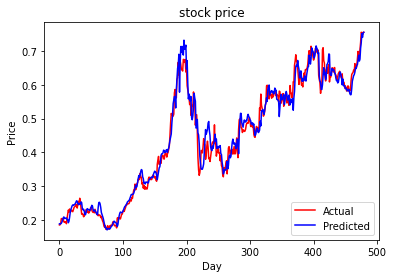

In [149]:
testset_plot(y_test_amd,y_pred_amd_6f3l)

#### 256-128

In [172]:
%%time

model_amd_6f3l = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(7,input_shape = (20,7),return_sequences = True,
               activation = 'relu'),
    tf.keras.layers.LSTM(256,activation = 'relu',return_sequences = True),
    tf.keras.layers.LSTM(128,activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
model_amd_6f3l.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_amd_6f3l = model_amd_6f3l.fit(X_train_amd,y_train_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/100
70/70 [==============================] - 4s 61ms/step - loss: 0.0094 - val_loss: 0.0069
Epoch 2/100
70/70 [==============================] - 4s 56ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 3/100
70/70 [==============================] - 4s 55ms/step - loss: 0.0015 - val_loss: 6.0027e-04
Epoch 4/100
70/70 [==============================] - 4s 55ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 5/100
70/70 [==============================] - 4s 55ms/step - loss: 0.0011 - val_loss: 6.8079e-04
Epoch 6/100
70/70 [==============================] - 4s 55ms/step - loss: 0.0010 - val_loss: 5.9300e-04
Epoch 7/100
70/70 [==============================] - 4s 56ms/step - loss: 9.4576e-04 - val_loss: 5.0729e-04
Epoch 8/100
70/70 [==============================] - 4s 55ms/step - loss: 9.3772e-04 - val_loss: 4.3842e-04
Epoch 9/100
70/70 [==============================] - 4s 55ms/step - loss: 8.7046e-04 - val_loss: 7.2380e-04
Epoch 10/100
70/70 [==============================] - 4s 55ms/st

70/70 [==============================] - 4s 56ms/step - loss: 2.8155e-04 - val_loss: 1.1041e-04
Epoch 77/100
70/70 [==============================] - 4s 56ms/step - loss: 2.7315e-04 - val_loss: 1.0410e-04
Epoch 78/100
70/70 [==============================] - 4s 56ms/step - loss: 2.6573e-04 - val_loss: 8.9937e-05
Epoch 79/100
70/70 [==============================] - 4s 56ms/step - loss: 2.9833e-04 - val_loss: 1.1107e-04
Epoch 80/100
70/70 [==============================] - 4s 56ms/step - loss: 2.9195e-04 - val_loss: 1.5328e-04
Epoch 81/100
70/70 [==============================] - 4s 56ms/step - loss: 2.4719e-04 - val_loss: 8.7939e-05
Epoch 82/100
70/70 [==============================] - 4s 55ms/step - loss: 2.6658e-04 - val_loss: 8.2911e-05
Epoch 83/100
70/70 [==============================] - 4s 55ms/step - loss: 2.6535e-04 - val_loss: 1.9841e-04
Epoch 84/100
70/70 [==============================] - 4s 56ms/step - loss: 2.7750e-04 - val_loss: 8.2866e-05
Epoch 85/100
70/70 [============

In [151]:
model_amd_6f3l.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 20, 7)             420       
_________________________________________________________________
lstm_45 (LSTM)               (None, 20, 256)           270336    
_________________________________________________________________
lstm_46 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 129       
Total params: 468,005
Trainable params: 468,005
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

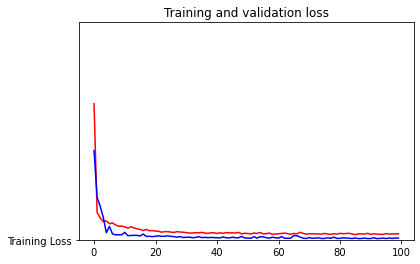

In [152]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


loss_amd_6f3l=history_amd_6f3l.history['loss']
val_loss_amd_6f3l=history_amd_6f3l.history['val_loss']

epochs=range(len(loss_amd_6f3l)) 


plt.plot(epochs, loss_amd_6f3l, 'r', "Training Loss")
plt.plot(epochs, val_loss_amd_6f3l, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [153]:
y_pred_amd_6f3l=making_y_pred(model_amd_6f3l,X_test_amd)
mse_amd_6f3l,rmse_amd_6f3l,r_amd_6f3l,mape_amd_6f3l=Evalu(model_amd_6f3l,X_test_amd,y_test_amd,y_pred_amd_6f3l)

MSE: 0.0006347976579295698  RMSE: 0.025195191166759775 R^2 score: 0.9777359806241311 MAPE: 0.03978263611876478


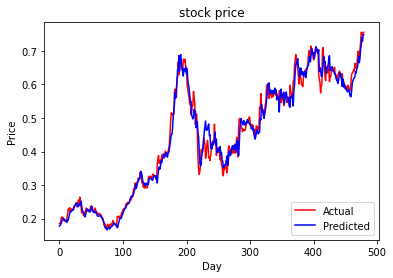

In [154]:
testset_plot(y_test_amd,y_pred_amd_6f3l)

#### 512-256

In [169]:
%%time

model_amd_6f3l = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(7,input_shape = (20,7),return_sequences = True,
               activation = 'relu'),
    tf.keras.layers.LSTM(512,activation = 'relu',return_sequences = True),
    tf.keras.layers.LSTM(256,activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
model_amd_6f3l.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_amd_6f3l = model_amd_6f3l.fit(X_train_amd,y_train_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/100
70/70 [==============================] - 13s 187ms/step - loss: 0.0040 - val_loss: 0.0018
Epoch 2/100
70/70 [==============================] - 13s 181ms/step - loss: 9.4695e-04 - val_loss: 3.0028e-04
Epoch 3/100
70/70 [==============================] - 13s 183ms/step - loss: 7.5806e-04 - val_loss: 2.5839e-04
Epoch 4/100
70/70 [==============================] - 13s 183ms/step - loss: 6.9600e-04 - val_loss: 2.7445e-04
Epoch 5/100
70/70 [==============================] - 13s 182ms/step - loss: 6.2318e-04 - val_loss: 7.9083e-04
Epoch 6/100
70/70 [==============================] - 13s 182ms/step - loss: 5.6069e-04 - val_loss: 4.0960e-04
Epoch 7/100
70/70 [==============================] - 13s 184ms/step - loss: 5.7739e-04 - val_loss: 2.2701e-04
Epoch 8/100
70/70 [==============================] - 13s 184ms/step - loss: 5.9425e-04 - val_loss: 3.6198e-04
Epoch 9/100
70/70 [==============================] - 13s 184ms/step - loss: 5.1315e-04 - val_loss: 4.2871e-04
Epoch 10/100
70/70

Epoch 75/100
70/70 [==============================] - 12s 176ms/step - loss: 2.0782e-04 - val_loss: 1.0475e-04
Epoch 76/100
70/70 [==============================] - 12s 175ms/step - loss: 2.3043e-04 - val_loss: 6.3815e-05
Epoch 77/100
70/70 [==============================] - 12s 176ms/step - loss: 2.2146e-04 - val_loss: 9.1312e-05
Epoch 78/100
70/70 [==============================] - 12s 175ms/step - loss: 2.2353e-04 - val_loss: 7.3062e-05
Epoch 79/100
70/70 [==============================] - 12s 176ms/step - loss: 2.0804e-04 - val_loss: 7.0374e-05
Epoch 80/100
70/70 [==============================] - 12s 175ms/step - loss: 2.1825e-04 - val_loss: 9.2394e-05
Epoch 81/100
70/70 [==============================] - 12s 177ms/step - loss: 2.6051e-04 - val_loss: 5.9848e-05
Epoch 82/100
70/70 [==============================] - 12s 178ms/step - loss: 2.0930e-04 - val_loss: 6.1636e-05
Epoch 83/100
70/70 [==============================] - 12s 175ms/step - loss: 2.1618e-04 - val_loss: 7.7629e-05
E

In [156]:
model_amd_6f3l.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_47 (LSTM)               (None, 20, 7)             420       
_________________________________________________________________
lstm_48 (LSTM)               (None, 20, 512)           1064960   
_________________________________________________________________
lstm_49 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 257       
Total params: 1,853,093
Trainable params: 1,853,093
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

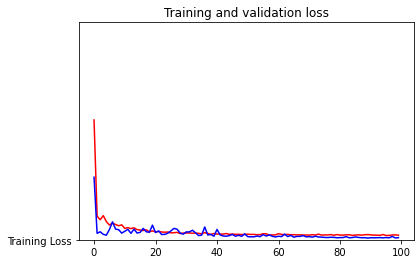

In [157]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


loss_amd_6f3l=history_amd_6f3l.history['loss']
val_loss_amd_6f3l=history_amd_6f3l.history['val_loss']

epochs=range(len(loss_amd_6f3l)) 


plt.plot(epochs, loss_amd_6f3l, 'r', "Training Loss")
plt.plot(epochs, val_loss_amd_6f3l, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [158]:
y_pred_amd_6f3l=making_y_pred(model_amd_6f3l,X_test_amd)
mse_amd_6f3l,rmse_amd_6f3l,r_amd_6f3l,mape_amd_6f3l=Evalu(model_amd_6f3l,X_test_amd,y_test_amd,y_pred_amd_6f3l)

MSE: 0.0011138848932330113  RMSE: 0.03337491413072117 R^2 score: 0.9609331343056422 MAPE: 0.05172765058164044


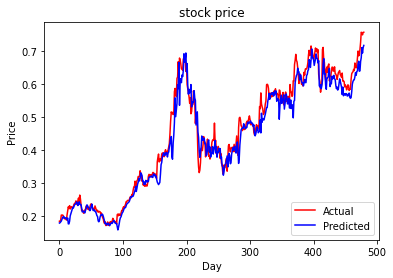

In [159]:
testset_plot(y_test_amd,y_pred_amd_6f3l)

#### 64-256

In [171]:
%%time 

model_amd_6f3l = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(7,input_shape = (20,7),return_sequences = True,
               activation = 'relu'),
    tf.keras.layers.LSTM(64,activation = 'relu',return_sequences = True),
    tf.keras.layers.LSTM(256,activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
model_amd_6f3l.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_amd_6f3l = model_amd_6f3l.fit(X_train_amd,y_train_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/100
70/70 [==============================] - 3s 49ms/step - loss: 0.0053 - val_loss: 0.0044
Epoch 2/100
70/70 [==============================] - 3s 44ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 3/100
70/70 [==============================] - 3s 44ms/step - loss: 0.0010 - val_loss: 9.3806e-04
Epoch 4/100
70/70 [==============================] - 3s 44ms/step - loss: 8.6167e-04 - val_loss: 6.4718e-04
Epoch 5/100
70/70 [==============================] - 3s 44ms/step - loss: 7.5517e-04 - val_loss: 2.7713e-04
Epoch 6/100
70/70 [==============================] - 3s 44ms/step - loss: 6.5228e-04 - val_loss: 2.1928e-04
Epoch 7/100
70/70 [==============================] - 3s 44ms/step - loss: 6.4030e-04 - val_loss: 2.1365e-04
Epoch 8/100
70/70 [==============================] - 3s 44ms/step - loss: 6.0587e-04 - val_loss: 4.0136e-04
Epoch 9/100
70/70 [==============================] - 3s 44ms/step - loss: 6.0287e-04 - val_loss: 2.7178e-04
Epoch 10/100
70/70 [============================

70/70 [==============================] - 3s 43ms/step - loss: 2.1702e-04 - val_loss: 1.1653e-04
Epoch 77/100
70/70 [==============================] - 3s 43ms/step - loss: 2.0173e-04 - val_loss: 8.6564e-05
Epoch 78/100
70/70 [==============================] - 3s 43ms/step - loss: 2.1754e-04 - val_loss: 1.4182e-04
Epoch 79/100
70/70 [==============================] - 3s 44ms/step - loss: 2.1168e-04 - val_loss: 1.4091e-04
Epoch 80/100
70/70 [==============================] - 3s 43ms/step - loss: 2.1027e-04 - val_loss: 1.5719e-04
Epoch 81/100
70/70 [==============================] - 3s 44ms/step - loss: 1.9778e-04 - val_loss: 1.3920e-04
Epoch 82/100
70/70 [==============================] - 3s 43ms/step - loss: 2.1808e-04 - val_loss: 9.9812e-05
Epoch 83/100
70/70 [==============================] - 3s 43ms/step - loss: 2.1770e-04 - val_loss: 1.5529e-04
Epoch 84/100
70/70 [==============================] - 3s 44ms/step - loss: 2.0325e-04 - val_loss: 9.6747e-05
Epoch 85/100
70/70 [============

In [161]:
model_amd_6f3l.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_50 (LSTM)               (None, 20, 7)             420       
_________________________________________________________________
lstm_51 (LSTM)               (None, 20, 64)            18432     
_________________________________________________________________
lstm_52 (LSTM)               (None, 256)               328704    
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 257       
Total params: 347,813
Trainable params: 347,813
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

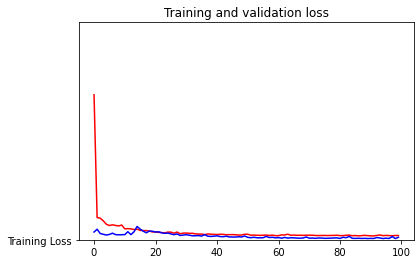

In [162]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


loss_amd_6f3l=history_amd_6f3l.history['loss']
val_loss_amd_6f3l=history_amd_6f3l.history['val_loss']

epochs=range(len(loss_amd_6f3l)) 


plt.plot(epochs, loss_amd_6f3l, 'r', "Training Loss")
plt.plot(epochs, val_loss_amd_6f3l, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

In [163]:
y_pred_amd_6f3l=making_y_pred(model_amd_6f3l,X_test_amd)
mse_amd_6f3l,rmse_amd_6f3l,r_amd_6f3l,mape_amd_6f3l=Evalu(model_amd_6f3l,X_test_amd,y_test_amd,y_pred_amd_6f3l)

MSE: 0.000698565515345338  RMSE: 0.026430389996088554 R^2 score: 0.9754994745574691 MAPE: 0.04867985170278858


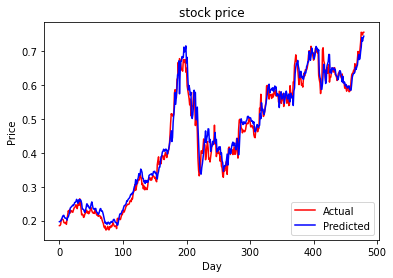

In [164]:
testset_plot(y_test_amd,y_pred_amd_6f3l)

#### Conclusion

In [205]:
model_selection=pd.DataFrame(columns=(['50-30','40-40','128-64','256-128','512-256','64-256']),
                     index=(['RMSE','MAPE','Wall time']))

In [206]:
model_selection.iloc[0,0]=0.029430206043611237 
model_selection.iloc[0,1]=0.02708566894932257 
model_selection.iloc[0,2]=0.027664456183781883     
model_selection.iloc[0,3]=0.025195191166759775   
model_selection.iloc[0,4]=0.03337491413072117 
model_selection.iloc[0,5]=0.026430389996088554 
model_selection.iloc[1,0]=0.048927276923308 
model_selection.iloc[1,1]=0.049159491107795605
model_selection.iloc[1,2]=0.04584388088040543   
model_selection.iloc[1,3]=0.03978263611876478
model_selection.iloc[1,4]=0.05172765058164044
model_selection.iloc[1,5]=0.04867985170278858
model_selection.iloc[2,0]='1:33'
model_selection.iloc[2,1]='1:29'
model_selection.iloc[2,2]='2:52'   
model_selection.iloc[2,3]='6:36'
model_selection.iloc[2,4]='20:59'
model_selection.iloc[2,5]='5:11'

In [207]:
model_selection

50-30      40-40     128-64    256-128    512-256     64-256
RMSE       0.0294302  0.0270857  0.0276645  0.0251952  0.0333749  0.0264304
MAPE       0.0489273  0.0491595  0.0458439  0.0397826  0.0517277  0.0486799
Wall time       1:33       1:29       2:52       6:36      20:59       5:11

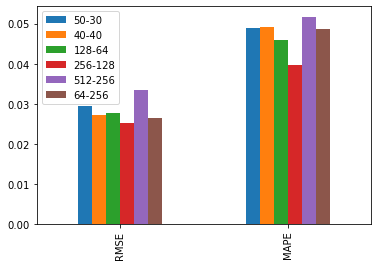

In [208]:
model_selection.iloc[:2,:].plot(kind='bar')

In [209]:
def time_to_sec(time):
    m, s = time.split(':')
    return int(m) * 60 + int(s)

In [210]:
time_array=[]
for i in range(len(model_selection.columns)):
    time_array.append(time_to_sec(model_selection.iloc[2,i]))
model_selection.loc[-1]=time_array
model_selection.rename({-1:'Second'})

50-30      40-40     128-64    256-128    512-256     64-256
RMSE       0.0294302  0.0270857  0.0276645  0.0251952  0.0333749  0.0264304
MAPE       0.0489273  0.0491595  0.0458439  0.0397826  0.0517277  0.0486799
Wall time       1:33       1:29       2:52       6:36      20:59       5:11
Second            93         89        172        396       1259        311

Text(0.5, 1.0, 'Wall time in combinations of unit numbers')

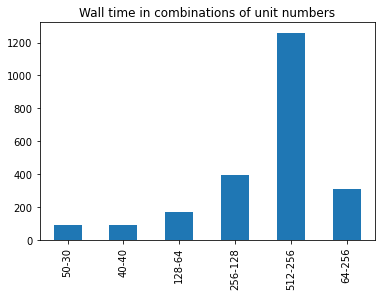

In [211]:
ax=model_selection.iloc[-1].plot(kind='bar')
ax.set_title('Wall time in combinations of unit numbers')

## Window size

#### 100

In [245]:
df_AMD_picked = df_AMD[['Close','H-L','O-C','7 DAYS STD DEV','RSI','MACD','Volume']] 
windows_size=100

train_sc,val_sc, test_sc=making_scaled_training_val_test_data(df_AMD_picked,4500,9000,9500,10000)
X_train_amd,y_train_amd,X_val_amd,y_val_amd=making_train_val(train_sc,val_sc,windows_size)
X_test_amd,y_test_amd=making_test(test_sc,windows_size)

In [259]:
y_train_amd.shape

(4400,)

In [246]:
model_amd_testing_windowsize = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(7,kernel_size=1,input_shape=(100,7)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_amd_testing_windowsize.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_amd_testing_windowsize = model_amd_testing_windowsize.fit(X_train_amd,y_train_amd,epochs = 20 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/20
69/69 [==============================] - 9s 133ms/step - loss: 0.0047 - val_loss: 3.8353e-04
Epoch 2/20
69/69 [==============================] - 8s 118ms/step - loss: 0.0011 - val_loss: 3.6362e-04
Epoch 3/20
69/69 [==============================] - 8s 119ms/step - loss: 9.0316e-04 - val_loss: 2.5152e-04
Epoch 4/20
69/69 [==============================] - 8s 118ms/step - loss: 8.3209e-04 - val_loss: 3.3282e-04
Epoch 5/20
69/69 [==============================] - 8s 117ms/step - loss: 9.8581e-04 - val_loss: 2.2521e-04
Epoch 6/20
69/69 [==============================] - 8s 117ms/step - loss: 7.5843e-04 - val_loss: 2.1104e-04
Epoch 7/20
69/69 [==============================] - 8s 117ms/step - loss: 6.6527e-04 - val_loss: 2.3041e-04
Epoch 8/20
69/69 [==============================] - 8s 117ms/step - loss: 6.5630e-04 - val_loss: 1.9000e-04
Epoch 9/20
69/69 [==============================] - 8s 117ms/step - loss: 5.9684e-04 - val_loss: 2.3641e-04
Epoch 10/20
69/69 [=================

MSE: 0.0017033537608783739  RMSE: 0.041271706541871685 R^2 score: 0.9207779003343401 MAPE: 0.06500318758409372


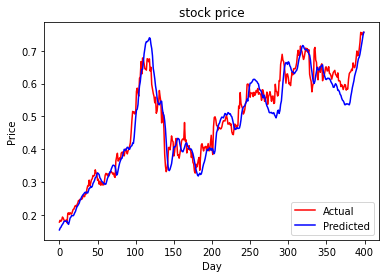

In [247]:
y_pred_amd_testing_windowsize=making_y_pred(model_amd_testing_windowsize,X_test_amd)
mse_amd_testing_windowsize,rmse_amd_testing_windowsize,r_amd_testing_windowsize,mape_amd_testing_windowsize=Evalu(model_amd_testing_windowsize,X_test_amd,y_test_amd,y_pred_amd_testing_windowsize)
testset_plot(y_test_amd,y_pred_amd_testing_windowsize)

#### 50

In [230]:
df_AMD_picked = df_AMD[['Close','H-L','O-C','7 DAYS STD DEV','RSI','MACD','Volume']] # Picking the features with high correlation
windows_size=50

train_sc,val_sc, test_sc=making_scaled_training_val_test_data(df_AMD_picked,4500,9000,9500,10000)
X_train_amd,y_train_amd,X_val_amd,y_val_amd=making_train_val(train_sc,val_sc,windows_size)
X_test_amd,y_test_amd=making_test(test_sc,windows_size)

In [235]:
model_amd_testing_windowsize = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(7,kernel_size=1,input_shape=(50,7)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_amd_testing_windowsize.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_amd_testing_windowsize = model_amd_testing_windowsize.fit(X_train_amd,y_train_amd,epochs = 20 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/20
70/70 [==============================] - 2s 34ms/step - loss: 0.0069 - val_loss: 0.0018
Epoch 2/20
70/70 [==============================] - 1s 19ms/step - loss: 9.0746e-04 - val_loss: 6.4954e-04
Epoch 3/20
70/70 [==============================] - 1s 20ms/step - loss: 8.3650e-04 - val_loss: 2.2075e-04
Epoch 4/20
70/70 [==============================] - 1s 19ms/step - loss: 7.0608e-04 - val_loss: 1.7306e-04
Epoch 5/20
70/70 [==============================] - 1s 19ms/step - loss: 6.1513e-04 - val_loss: 1.3644e-04
Epoch 6/20
70/70 [==============================] - 1s 19ms/step - loss: 6.2241e-04 - val_loss: 3.4345e-04
Epoch 7/20
70/70 [==============================] - 1s 19ms/step - loss: 5.5697e-04 - val_loss: 1.9429e-04
Epoch 8/20
70/70 [==============================] - 1s 19ms/step - loss: 5.3268e-04 - val_loss: 2.1442e-04
Epoch 9/20
70/70 [==============================] - 1s 19ms/step - loss: 4.7635e-04 - val_loss: 1.3147e-04
Epoch 10/20
70/70 [==========================

MSE: 0.0011429041511133511  RMSE: 0.03380686544347688 R^2 score: 0.9599153527942414 MAPE: 0.05642090247828744


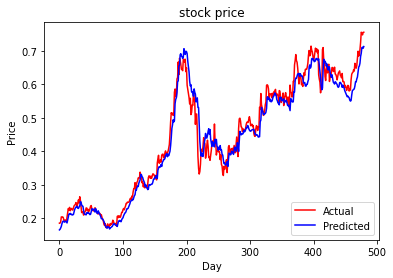

In [236]:
y_pred_amd_testing_windowsize=making_y_pred(model_amd_testing_windowsize,X_test_amd)
mse_amd_testing_windowsize,rmse_amd_testing_windowsize,r_amd_testing_windowsize,mape_amd_testing_windowsize=Evalu(model_amd_testing_windowsize,X_test_amd,y_test_amd,y_pred_amd_testing_windowsize)
testset_plot(y_test_amd,y_pred_amd_testing_windowsize)

#### 20

In [237]:
df_AMD_picked = df_AMD[['Close','H-L','O-C','7 DAYS STD DEV','RSI','MACD','Volume']] # Picking the features with high correlation
windows_size=20

train_sc,val_sc, test_sc=making_scaled_training_val_test_data(df_AMD_picked,4500,9000,9500,10000)
X_train_amd,y_train_amd,X_val_amd,y_val_amd=making_train_val(train_sc,val_sc,windows_size)
X_test_amd,y_test_amd=making_test(test_sc,windows_size)

In [238]:
model_amd_testing_windowsize = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(7,kernel_size=1,input_shape=(20,7)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_amd_testing_windowsize.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_amd_testing_windowsize = model_amd_testing_windowsize.fit(X_train_amd,y_train_amd,epochs = 20 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/20
70/70 [==============================] - 2s 35ms/step - loss: 0.0073 - val_loss: 3.7672e-04
Epoch 2/20
70/70 [==============================] - 1s 20ms/step - loss: 0.0011 - val_loss: 3.6880e-04
Epoch 3/20
70/70 [==============================] - 1s 20ms/step - loss: 8.4625e-04 - val_loss: 5.0553e-04
Epoch 4/20
70/70 [==============================] - 1s 20ms/step - loss: 8.7189e-04 - val_loss: 6.3485e-04
Epoch 5/20
70/70 [==============================] - 1s 20ms/step - loss: 6.6113e-04 - val_loss: 2.8074e-04
Epoch 6/20
70/70 [==============================] - 1s 20ms/step - loss: 6.1573e-04 - val_loss: 1.6654e-04
Epoch 7/20
70/70 [==============================] - 1s 20ms/step - loss: 6.0467e-04 - val_loss: 4.0711e-04
Epoch 8/20
70/70 [==============================] - 1s 20ms/step - loss: 6.4996e-04 - val_loss: 1.4235e-04
Epoch 9/20
70/70 [==============================] - 1s 20ms/step - loss: 5.0672e-04 - val_loss: 3.3733e-04
Epoch 10/20
70/70 [==========================

MSE: 0.0011402626674059198  RMSE: 0.03376777557681169 R^2 score: 0.9600079965582955 MAPE: 0.06923700243294


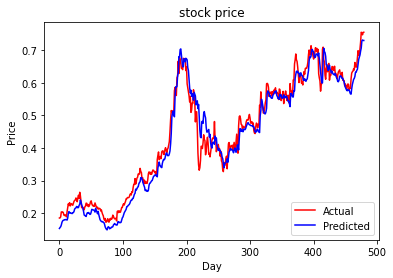

In [239]:
y_pred_amd_testing_windowsize=making_y_pred(model_amd_testing_windowsize,X_test_amd)
mse_amd_testing_windowsize,rmse_amd_testing_windowsize,r_amd_testing_windowsize,mape_amd_testing_windowsize=Evalu(model_amd_testing_windowsize,X_test_amd,y_test_amd,y_pred_amd_testing_windowsize)
testset_plot(y_test_amd,y_pred_amd_testing_windowsize)

#### 10

In [240]:
df_AMD_picked = df_AMD[['Close','H-L','O-C','7 DAYS STD DEV','RSI','MACD','Volume']] # Picking the features with high correlation
windows_size=10

train_sc,val_sc, test_sc=making_scaled_training_val_test_data(df_AMD_picked,4500,9000,9500,10000)
X_train_amd,y_train_amd,X_val_amd,y_val_amd=making_train_val(train_sc,val_sc,windows_size)
X_test_amd,y_test_amd=making_test(test_sc,windows_size)

In [241]:
model_amd_testing_windowsize = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(7,kernel_size=1,input_shape=(10,7)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_amd_testing_windowsize.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_amd_testing_windowsize = model_amd_testing_windowsize.fit(X_train_amd,y_train_amd,epochs = 20 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/20
71/71 [==============================] - 2s 30ms/step - loss: 0.0066 - val_loss: 0.0072
Epoch 2/20
71/71 [==============================] - 1s 15ms/step - loss: 0.0014 - val_loss: 3.3179e-04
Epoch 3/20
71/71 [==============================] - 1s 15ms/step - loss: 7.3111e-04 - val_loss: 1.5750e-04
Epoch 4/20
71/71 [==============================] - 1s 15ms/step - loss: 6.5693e-04 - val_loss: 1.3695e-04
Epoch 5/20
71/71 [==============================] - 1s 14ms/step - loss: 5.9052e-04 - val_loss: 1.9665e-04
Epoch 6/20
71/71 [==============================] - 1s 14ms/step - loss: 5.2400e-04 - val_loss: 1.4932e-04
Epoch 7/20
71/71 [==============================] - 1s 14ms/step - loss: 5.4428e-04 - val_loss: 2.8901e-04
Epoch 8/20
71/71 [==============================] - 1s 14ms/step - loss: 4.7766e-04 - val_loss: 2.0797e-04
Epoch 9/20
71/71 [==============================] - 1s 14ms/step - loss: 4.4971e-04 - val_loss: 1.4708e-04
Epoch 10/20
71/71 [==============================

Text(0.5, 1.0, 'Training and validation loss')

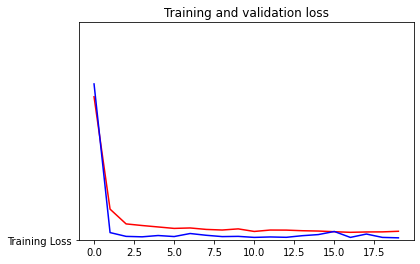

In [244]:
%matplotlib inline
loss_amd_testing_windowsize=history_amd_testing_windowsize.history['loss']
val_loss_amd_testing_windowsize=history_amd_testing_windowsize.history['val_loss']

epochs=range(len(loss_amd_testing_windowsize)) 

plt.plot(epochs, loss_amd_testing_windowsize, 'r', "Training Loss")
plt.plot(epochs, val_loss_amd_testing_windowsize, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

MSE: 0.001182879005154999  RMSE: 0.034393008085292553 R^2 score: 0.959551153319332 MAPE: 0.05772040880777216


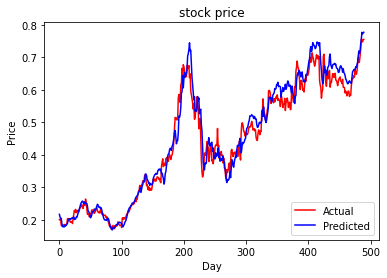

In [242]:
y_pred_amd_testing_windowsize=making_y_pred(model_amd_testing_windowsize,X_test_amd)
mse_amd_testing_windowsize,rmse_amd_testing_windowsize,r_amd_testing_windowsize,mape_amd_testing_windowsize=Evalu(model_amd_testing_windowsize,X_test_amd,y_test_amd,y_pred_amd_testing_windowsize)
testset_plot(y_test_amd,y_pred_amd_testing_windowsize)

#### Conclusion

In [272]:
model_selection=pd.DataFrame(columns=(['100','50','20','10']),
                     index=(['RMSE','MAPE']))

In [273]:
model_selection.iloc[0,0]=0.041271706541871685 
model_selection.iloc[0,1]=0.03380686544347688 
model_selection.iloc[0,2]=0.03376777557681169    
model_selection.iloc[0,3]=0.034393008085292553   
model_selection.iloc[1,0]=0.06500318758409372 
model_selection.iloc[1,1]=0.05642090247828744
model_selection.iloc[1,2]=0.06923700243294   
model_selection.iloc[1,3]=0.05772040880777216

In [274]:
model_selection

100         50         20         10
RMSE  0.0412717  0.0338069  0.0337678   0.034393
MAPE  0.0650032  0.0564209   0.069237  0.0577204

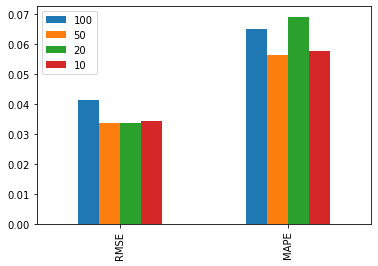

In [275]:
model_selection.iloc[:2,:].plot(kind='bar')

## Finding optimal window size and model

#### window_size 10

In [697]:
df_AMD_picked = df_AMD[['Close','H-L','O-C','7 DAYS STD DEV','RSI','MACD','Volume']] # Picking the features with high correlation
windows_size=10

train_sc,val_sc, test_sc=making_scaled_training_val_test_data(df_AMD_picked,6000,9500,10200,10254)
X_train_amd,y_train_amd,X_val_amd,y_val_amd=making_train_val(train_sc,val_sc,windows_size)
X_test_amd,y_test_amd=making_test(test_sc,windows_size)

##### 3CNN+LSTM+3DNN

In [698]:
model_amd = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(7,kernel_size=2,input_shape=(10,7)),
    tf.keras.layers.Conv1D(64,kernel_size=2),
    tf.keras.layers.Conv1D(128,kernel_size=2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1)
    
])
model_amd.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_amd = model_amd.fit(X_train_amd,y_train_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/100
55/55 [==============================] - 2s 34ms/step - loss: 0.0047 - val_loss: 0.0278
Epoch 2/100
55/55 [==============================] - 1s 14ms/step - loss: 6.8605e-04 - val_loss: 0.0063
Epoch 3/100
55/55 [==============================] - 1s 14ms/step - loss: 5.4834e-04 - val_loss: 0.0074
Epoch 4/100
55/55 [==============================] - 1s 14ms/step - loss: 4.4140e-04 - val_loss: 0.0053
Epoch 5/100
55/55 [==============================] - 1s 14ms/step - loss: 4.5567e-04 - val_loss: 0.0165
Epoch 6/100
55/55 [==============================] - 1s 14ms/step - loss: 4.8998e-04 - val_loss: 0.0052
Epoch 7/100
55/55 [==============================] - 1s 14ms/step - loss: 3.5957e-04 - val_loss: 0.0057
Epoch 8/100
55/55 [==============================] - 1s 14ms/step - loss: 3.5674e-04 - val_loss: 0.0108
Epoch 9/100
55/55 [==============================] - 1s 14ms/step - loss: 3.4493e-04 - val_loss: 0.0068
Epoch 10/100
55/55 [==============================] - 1s 14ms/step -

55/55 [==============================] - 1s 13ms/step - loss: 2.7493e-04 - val_loss: 0.0130
Epoch 80/100
55/55 [==============================] - 1s 13ms/step - loss: 1.8966e-04 - val_loss: 0.0093
Epoch 81/100
55/55 [==============================] - 1s 13ms/step - loss: 2.8299e-04 - val_loss: 0.0108
Epoch 82/100
55/55 [==============================] - 1s 13ms/step - loss: 2.2053e-04 - val_loss: 0.0093
Epoch 83/100
55/55 [==============================] - 1s 13ms/step - loss: 2.1488e-04 - val_loss: 0.0090
Epoch 84/100
55/55 [==============================] - 1s 13ms/step - loss: 2.3054e-04 - val_loss: 0.0100
Epoch 85/100
55/55 [==============================] - 1s 13ms/step - loss: 2.0105e-04 - val_loss: 0.0093
Epoch 86/100
55/55 [==============================] - 1s 13ms/step - loss: 2.0054e-04 - val_loss: 0.0118
Epoch 87/100
55/55 [==============================] - 1s 14ms/step - loss: 2.2709e-04 - val_loss: 0.0101
Epoch 88/100
55/55 [==============================] - 1s 13ms/step -

In [699]:
model_amd.summary()

Model: "sequential_152"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_226 (Conv1D)          (None, 9, 7)              105       
_________________________________________________________________
conv1d_227 (Conv1D)          (None, 8, 64)             960       
_________________________________________________________________
conv1d_228 (Conv1D)          (None, 7, 128)            16512     
_________________________________________________________________
bidirectional_239 (Bidirecti (None, 7, 80)             54080     
_________________________________________________________________
bidirectional_240 (Bidirecti (None, 7, 80)             38720     
_________________________________________________________________
lstm_423 (LSTM)              (None, 40)                19360     
_________________________________________________________________
dropout_139 (Dropout)        (None, 40)             

Text(0.5, 1.0, 'Training and validation loss')

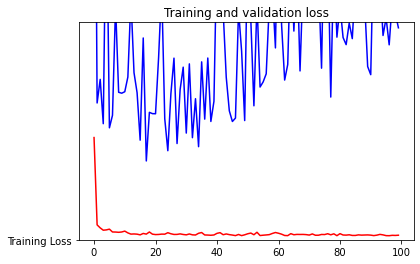

In [700]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_amd=history_amd.history['loss']
val_loss_amd=history_amd.history['val_loss']

epochs=range(len(loss_amd)) 

plt.plot(epochs, loss_amd, 'r', "Training Loss")
plt.plot(epochs, val_loss_amd, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

MSE: 0.019498051039366766  RMSE: 0.13963542186482183 R^2 score: 0.887067529189386 MAPE: 0.06327042541348868


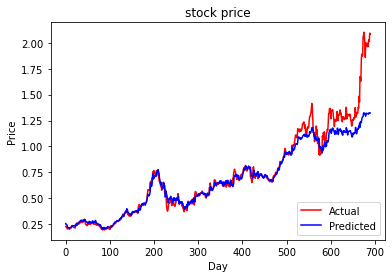

In [701]:
y_pred_amd=making_y_pred(model_amd,X_val_amd)
mse_amd,rmse_amd,r_amd,mape_amd=Evalu(model_amd,X_val_amd,y_val_amd,y_pred_amd)
testset_plot(y_val_amd,y_pred_amd)

##### Conv1d+LSTM

In [702]:
model_amd = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(7,kernel_size=2,input_shape=(10,7)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_amd.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_amd = model_amd.fit(X_train_amd,y_train_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/100
55/55 [==============================] - 2s 34ms/step - loss: 0.0060 - val_loss: 0.0082
Epoch 2/100
55/55 [==============================] - 1s 14ms/step - loss: 7.0820e-04 - val_loss: 0.0078
Epoch 3/100
55/55 [==============================] - 1s 14ms/step - loss: 5.9906e-04 - val_loss: 0.0064
Epoch 4/100
55/55 [==============================] - 1s 14ms/step - loss: 5.1619e-04 - val_loss: 0.0073
Epoch 5/100
55/55 [==============================] - 1s 14ms/step - loss: 4.3759e-04 - val_loss: 0.0048
Epoch 6/100
55/55 [==============================] - 1s 14ms/step - loss: 4.2279e-04 - val_loss: 0.0031
Epoch 7/100
55/55 [==============================] - 1s 14ms/step - loss: 3.8247e-04 - val_loss: 0.0054
Epoch 8/100
55/55 [==============================] - 1s 14ms/step - loss: 4.1279e-04 - val_loss: 0.0052
Epoch 9/100
55/55 [==============================] - 1s 14ms/step - loss: 4.4703e-04 - val_loss: 0.0019
Epoch 10/100
55/55 [==============================] - 1s 14ms/step -

55/55 [==============================] - 1s 14ms/step - loss: 1.9161e-04 - val_loss: 0.0022
Epoch 80/100
55/55 [==============================] - 1s 14ms/step - loss: 2.2700e-04 - val_loss: 0.0025
Epoch 81/100
55/55 [==============================] - 1s 14ms/step - loss: 1.8844e-04 - val_loss: 0.0035
Epoch 82/100
55/55 [==============================] - 1s 14ms/step - loss: 1.9007e-04 - val_loss: 0.0029
Epoch 83/100
55/55 [==============================] - 1s 14ms/step - loss: 2.3541e-04 - val_loss: 0.0026
Epoch 84/100
55/55 [==============================] - 1s 14ms/step - loss: 2.0971e-04 - val_loss: 0.0029
Epoch 85/100
55/55 [==============================] - 1s 14ms/step - loss: 1.9868e-04 - val_loss: 0.0027
Epoch 86/100
55/55 [==============================] - 1s 14ms/step - loss: 1.8666e-04 - val_loss: 0.0019
Epoch 87/100
55/55 [==============================] - 1s 14ms/step - loss: 1.8817e-04 - val_loss: 0.0038
Epoch 88/100
55/55 [==============================] - 1s 14ms/step -

Text(0.5, 1.0, 'svmaining and validation loss')

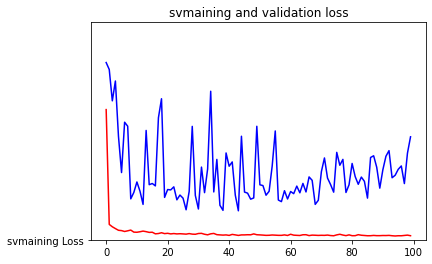

In [703]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_amd=history_amd.history['loss']
val_loss_amd=history_amd.history['val_loss']

epochs=range(len(loss_amd)) 

plt.plot(epochs, loss_amd, 'r', "svmaining Loss")
plt.plot(epochs, val_loss_amd, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('svmaining and validation loss')

MSE: 0.009473840617085094  RMSE: 0.09733365613745891 R^2 score: 0.9451276321518892 MAPE: 0.07148137748082684


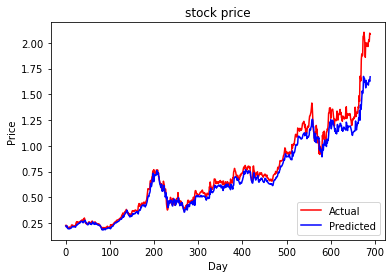

In [704]:
y_pred_amd=making_y_pred(model_amd,X_val_amd)
mse_amd,rmse_amd,r_amd,mape_amd=Evalu(model_amd,X_val_amd,y_val_amd,y_pred_amd)
testset_plot(y_val_amd,y_pred_amd)

#### window_size 50

In [705]:
df_AMD_picked = df_AMD[['Close','H-L','O-C','7 DAYS STD DEV','RSI','MACD','Volume']] 
windows_size=50

train_sc,val_sc, test_sc=making_scaled_training_val_test_data(df_AMD_picked,6000,9500,10200,10254)
X_train_amd,y_train_amd,X_val_amd,y_val_amd=making_train_val(train_sc,val_sc,windows_size)
X_test_amd,y_test_amd=making_test(test_sc,windows_size)

##### 3CNN+LSTM+3DNN

In [706]:
model_amd = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(7,kernel_size=2,input_shape=(50,7)),
    tf.keras.layers.Conv1D(64,kernel_size=2),
    tf.keras.layers.Conv1D(128,kernel_size=2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1)
    
])
model_amd.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_amd = model_amd.fit(X_train_amd,y_train_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/100
54/54 [==============================] - 5s 88ms/step - loss: 0.0059 - val_loss: 0.0318
Epoch 2/100
54/54 [==============================] - 4s 67ms/step - loss: 0.0011 - val_loss: 0.0119
Epoch 3/100
54/54 [==============================] - 4s 67ms/step - loss: 6.6978e-04 - val_loss: 0.0112
Epoch 4/100
54/54 [==============================] - 4s 67ms/step - loss: 5.4248e-04 - val_loss: 0.0205
Epoch 5/100
54/54 [==============================] - 4s 67ms/step - loss: 5.3478e-04 - val_loss: 0.0083
Epoch 6/100
54/54 [==============================] - 4s 67ms/step - loss: 5.3844e-04 - val_loss: 0.0081
Epoch 7/100
54/54 [==============================] - 4s 67ms/step - loss: 4.2215e-04 - val_loss: 0.0055
Epoch 8/100
54/54 [==============================] - 4s 66ms/step - loss: 4.8758e-04 - val_loss: 0.0083
Epoch 9/100
54/54 [==============================] - 4s 66ms/step - loss: 4.4881e-04 - val_loss: 0.0042
Epoch 10/100
54/54 [==============================] - 4s 66ms/step - los

54/54 [==============================] - 4s 67ms/step - loss: 2.3033e-04 - val_loss: 0.0069
Epoch 80/100
54/54 [==============================] - 4s 66ms/step - loss: 2.2652e-04 - val_loss: 0.0100
Epoch 81/100
54/54 [==============================] - 4s 66ms/step - loss: 2.6647e-04 - val_loss: 0.0060
Epoch 82/100
54/54 [==============================] - 4s 68ms/step - loss: 2.1099e-04 - val_loss: 0.0075
Epoch 83/100
54/54 [==============================] - 4s 67ms/step - loss: 1.9632e-04 - val_loss: 0.0073
Epoch 84/100
54/54 [==============================] - 4s 67ms/step - loss: 2.2127e-04 - val_loss: 0.0079
Epoch 85/100
54/54 [==============================] - 4s 67ms/step - loss: 2.7029e-04 - val_loss: 0.0085
Epoch 86/100
54/54 [==============================] - 4s 67ms/step - loss: 2.2061e-04 - val_loss: 0.0068
Epoch 87/100
54/54 [==============================] - 4s 66ms/step - loss: 2.5055e-04 - val_loss: 0.0085
Epoch 88/100
54/54 [==============================] - 4s 66ms/step -

Text(0.5, 1.0, 'svmaining and validation loss')

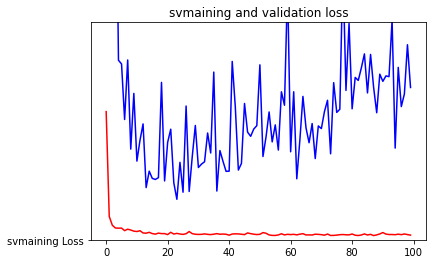

In [707]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_amd=history_amd.history['loss']
val_loss_amd=history_amd.history['val_loss']

epochs=range(len(loss_amd)) 

plt.plot(epochs, loss_amd, 'r', "svmaining Loss")
plt.plot(epochs, val_loss_amd, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('svmaining and validation loss')

MSE: 0.014010526547794683  RMSE: 0.11836607008680605 R^2 score: 0.9165954453901314 MAPE: 0.05543689140661533


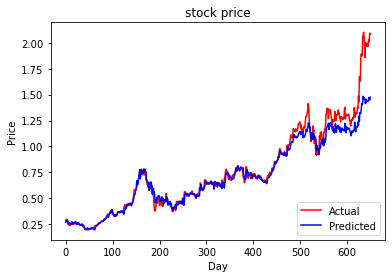

In [708]:
y_pred_amd=making_y_pred(model_amd,X_val_amd)
mse_amd,rmse_amd,r_amd,mape_amd=Evalu(model_amd,X_val_amd,y_val_amd,y_pred_amd)
testset_plot(y_val_amd,y_pred_amd)

##### Conv1d+LSTM

In [709]:
model_amd = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(7,kernel_size=2,input_shape=(50,7)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_amd.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_amd = model_amd.fit(X_train_amd,y_train_amd,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_amd, y_val_amd),verbose = 1)

Epoch 1/100
54/54 [==============================] - 5s 84ms/step - loss: 0.0041 - val_loss: 0.0149
Epoch 2/100
54/54 [==============================] - 3s 64ms/step - loss: 7.6579e-04 - val_loss: 0.0056
Epoch 3/100
54/54 [==============================] - 3s 64ms/step - loss: 5.1178e-04 - val_loss: 0.0057
Epoch 4/100
54/54 [==============================] - 3s 64ms/step - loss: 5.7667e-04 - val_loss: 0.0035
Epoch 5/100
54/54 [==============================] - 3s 64ms/step - loss: 5.0845e-04 - val_loss: 0.0051
Epoch 6/100
54/54 [==============================] - 3s 64ms/step - loss: 5.6079e-04 - val_loss: 0.0054
Epoch 7/100
54/54 [==============================] - 3s 64ms/step - loss: 5.1645e-04 - val_loss: 0.0060
Epoch 8/100
54/54 [==============================] - 3s 65ms/step - loss: 4.9966e-04 - val_loss: 0.0101
Epoch 9/100
54/54 [==============================] - 3s 64ms/step - loss: 4.2024e-04 - val_loss: 0.0036
Epoch 10/100
54/54 [==============================] - 3s 64ms/step -

54/54 [==============================] - 3s 65ms/step - loss: 1.8816e-04 - val_loss: 0.0031
Epoch 80/100
54/54 [==============================] - 4s 65ms/step - loss: 1.7997e-04 - val_loss: 0.0026
Epoch 81/100
54/54 [==============================] - 3s 64ms/step - loss: 2.1037e-04 - val_loss: 0.0026
Epoch 82/100
54/54 [==============================] - 4s 65ms/step - loss: 1.9991e-04 - val_loss: 0.0026
Epoch 83/100
54/54 [==============================] - 3s 65ms/step - loss: 1.9515e-04 - val_loss: 0.0022
Epoch 84/100
54/54 [==============================] - 3s 65ms/step - loss: 1.7499e-04 - val_loss: 0.0028
Epoch 85/100
54/54 [==============================] - 3s 64ms/step - loss: 2.0508e-04 - val_loss: 0.0022
Epoch 86/100
54/54 [==============================] - 3s 64ms/step - loss: 2.1624e-04 - val_loss: 0.0026
Epoch 87/100
54/54 [==============================] - 3s 64ms/step - loss: 1.7080e-04 - val_loss: 0.0031
Epoch 88/100
54/54 [==============================] - 3s 64ms/step -

Text(0.5, 1.0, 'svmaining and validation loss')

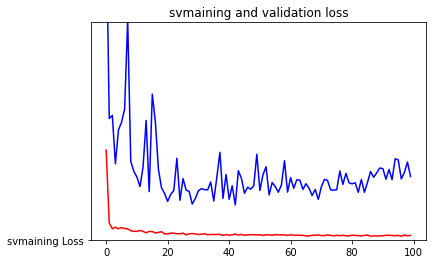

In [710]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_amd=history_amd.history['loss']
val_loss_amd=history_amd.history['val_loss']

epochs=range(len(loss_amd)) 

plt.plot(epochs, loss_amd, 'r', "svmaining Loss")
plt.plot(epochs, val_loss_amd, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('svmaining and validation loss')

MSE: 0.005823658380302301  RMSE: 0.07631289786335138 R^2 score: 0.9653318073555489 MAPE: 0.0488629636199725


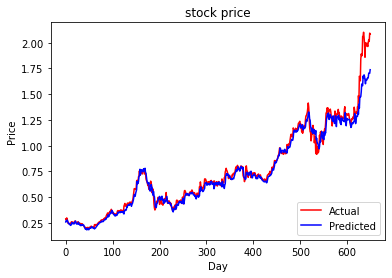

In [711]:
y_pred_amd=making_y_pred(model_amd,X_val_amd)
mse_amd,rmse_amd,r_amd,mape_amd=Evalu(model_amd,X_val_amd,y_val_amd,y_pred_amd)
testset_plot(y_val_amd,y_pred_amd)

#### Conclusion

In [712]:
model_selection=pd.DataFrame(columns=(['10','50']),
                     index=(['Conv-LSTM','3CNN-LSTM-3DNN']))

In [713]:
model_selection.iloc[0,0]=0.09733365613745891  
model_selection.iloc[0,1]=0.07631289786335138  
model_selection.iloc[1,0]=0.13963542186482183  
model_selection.iloc[1,1]=0.11836607008680605 

In [714]:
model_selection

10         50
Conv-LSTM       0.0973337  0.0763129
3CNN-LSTM-3DNN   0.139635   0.118366

# Applying model into 3 different companies


## Correlation

In [369]:
msft_corr=df_msft.corr()
intc_corr=df_intc.corr()
nvda_corr=df_nvda.corr()

<Figure size 1080x648 with 0 Axes>

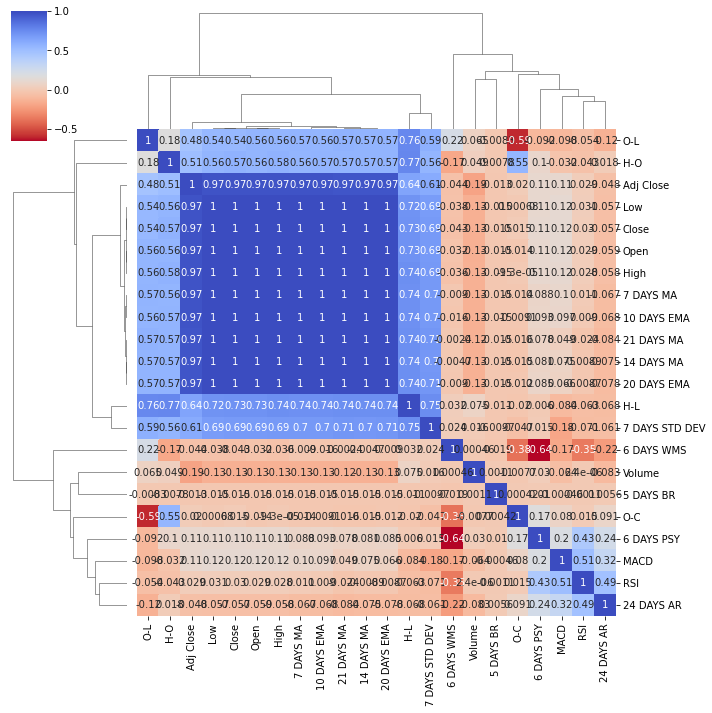

In [370]:
import seaborn as sns
plt.figure(figsize=(15,9))
sns.clustermap(intc_corr,annot=True,cmap='coolwarm_r')

In [374]:
abs(df_intc.corr()['Close']).sort_values()

5 DAYS BR         0.014710
O-C               0.015487
RSI               0.029707
6 DAYS WMS        0.043376
24 DAYS AR        0.056727
6 DAYS PSY        0.114065
MACD              0.123174
Volume            0.131203
O-L               0.543636
H-O               0.574516
7 DAYS STD DEV    0.688826
H-L               0.729052
Adj Close         0.969558
21 DAYS MA        0.995301
14 DAYS MA        0.996820
20 DAYS EMA       0.997229
7 DAYS MA         0.998209
10 DAYS EMA       0.998729
Open              0.999566
High              0.999763
Low               0.999780
Close             1.000000
Name: Close, dtype: float64

<Figure size 1080x648 with 0 Axes>

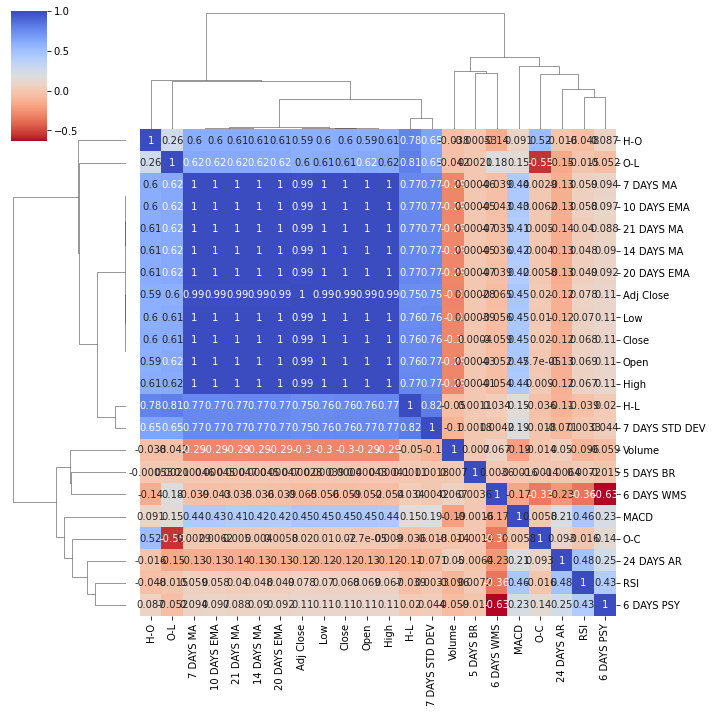

In [371]:
import seaborn as sns
plt.figure(figsize=(15,9))
sns.clustermap(msft_corr,annot=True,cmap='coolwarm_r')

In [375]:
abs(df_msft.corr()['Close']).sort_values()

5 DAYS BR         0.000399
O-C               0.019998
6 DAYS WMS        0.058682
RSI               0.068439
6 DAYS PSY        0.108668
24 DAYS AR        0.123162
Volume            0.295045
MACD              0.447899
H-O               0.604869
O-L               0.607201
H-L               0.762109
7 DAYS STD DEV    0.764596
Adj Close         0.994156
21 DAYS MA        0.998339
14 DAYS MA        0.998796
20 DAYS EMA       0.999040
7 DAYS MA         0.999273
10 DAYS EMA       0.999509
Open              0.999798
High              0.999881
Low               0.999896
Close             1.000000
Name: Close, dtype: float64

<Figure size 1080x648 with 0 Axes>

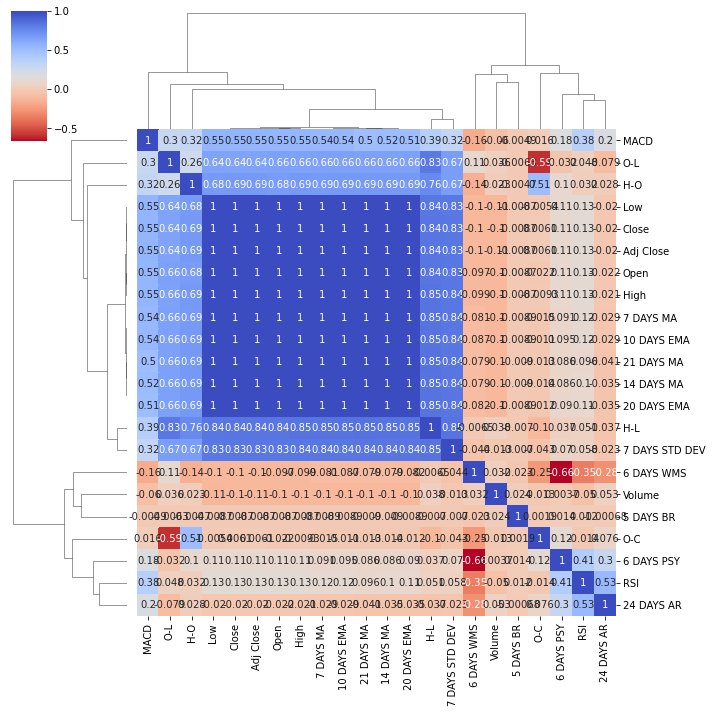

In [372]:
import seaborn as sns
plt.figure(figsize=(15,9))
sns.clustermap(nvda_corr,annot=True,cmap='coolwarm_r')

In [376]:
abs(df_nvda.corr()['Close']).sort_values()

O-C               0.006115
5 DAYS BR         0.008692
24 DAYS AR        0.020206
6 DAYS WMS        0.104205
Volume            0.104795
6 DAYS PSY        0.109205
RSI               0.128422
MACD              0.553646
O-L               0.644713
H-O               0.692984
7 DAYS STD DEV    0.833881
H-L               0.840419
21 DAYS MA        0.996937
14 DAYS MA        0.997777
20 DAYS EMA       0.998113
7 DAYS MA         0.998633
10 DAYS EMA       0.999089
Open              0.999614
High              0.999807
Low               0.999841
Adj Close         0.999984
Close             1.000000
Name: Close, dtype: float64

## Loading datasets

In [363]:
df_intc=pd.read_csv("INTC_indicators.csv")
df_msft=pd.read_csv("MSFT_indicators.csv")
df_nvda=pd.read_csv("NVDA_indicators.csv")

## Training the datasets with different feature combinations

### INTC

#### window_size 10

In [648]:
#Traning:2010-01-04 to 2018-01-03, Validation: 2018-01-04 to 2020-01-02, testing: 2020-01-03

df_intc_picked_tr = df_intc[['Close','Open','High','Low','Volume']]
df_intc_picked_corr = df_intc[['Close','H-O','7 DAYS STD DEV','Volume','MACD']]
df_intc_picked_svm = df_intc[['Close','6 DAYS WMS','MACD','21 DAYS MA']]
windows_size=10

train_sc_tr,val_sc_tr,test_sc_tr=making_scaled_training_val_test_data(df_intc_picked_tr,7519,9534,10036,10261)
X_train_intc_tr,y_train_intc_tr,X_val_intc_tr,y_val_intc_tr=making_train_val(train_sc_tr,val_sc_tr,windows_size)
X_test_intc_tr,y_test_intc_tr=making_test(test_sc_tr,windows_size)

train_sc_corr,val_sc_corr,test_sc_corr=making_scaled_training_val_test_data(df_intc_picked_corr,7519,9534,10036,10261)
X_train_intc_corr,y_train_intc_corr,X_val_intc_corr,y_val_intc_corr=making_train_val(train_sc_corr,val_sc_corr,windows_size)
X_test_intc_corr,y_test_intc_corr=making_test(test_sc_corr,windows_size)

train_sc_svm,val_sc_svm,test_sc_svm=making_scaled_training_val_test_data(df_intc_picked_svm,7519,9534,10036,10261)
X_train_intc_svm,y_train_intc_svm,X_val_intc_svm,y_val_intc_svm=making_train_val(train_sc_svm,val_sc_svm,windows_size)
X_test_intc_svm,y_test_intc_svm=making_test(test_sc_svm,windows_size)

##### 3CNN+LSTM+3DNN

###### Traditional features

In [649]:
model_intc_tr = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(5,kernel_size=2,input_shape=(10,5)),
    tf.keras.layers.Conv1D(64,kernel_size=2),
    tf.keras.layers.Conv1D(128,kernel_size=2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1)
    
])
model_intc_tr.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_intc_tr = model_intc_tr.fit(X_train_intc_tr,y_train_intc_tr,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_intc_tr, y_val_intc_tr),verbose = 1)

Epoch 1/100
32/32 [==============================] - 2s 49ms/step - loss: 0.0092 - val_loss: 0.0024
Epoch 2/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0012 - val_loss: 0.0030
Epoch 3/100
32/32 [==============================] - 0s 14ms/step - loss: 9.6269e-04 - val_loss: 0.0026
Epoch 4/100
32/32 [==============================] - 0s 14ms/step - loss: 8.9142e-04 - val_loss: 0.0035
Epoch 5/100
32/32 [==============================] - 0s 14ms/step - loss: 7.5377e-04 - val_loss: 0.0044
Epoch 6/100
32/32 [==============================] - 0s 13ms/step - loss: 7.1137e-04 - val_loss: 0.0030
Epoch 7/100
32/32 [==============================] - 0s 13ms/step - loss: 7.3005e-04 - val_loss: 0.0047
Epoch 8/100
32/32 [==============================] - 0s 13ms/step - loss: 6.6499e-04 - val_loss: 0.0025
Epoch 9/100
32/32 [==============================] - 0s 13ms/step - loss: 6.7373e-04 - val_loss: 0.0024
Epoch 10/100
32/32 [==============================] - 0s 13ms/step - los

32/32 [==============================] - 0s 13ms/step - loss: 3.4907e-04 - val_loss: 0.0010
Epoch 80/100
32/32 [==============================] - 0s 13ms/step - loss: 2.9813e-04 - val_loss: 0.0016
Epoch 81/100
32/32 [==============================] - 0s 13ms/step - loss: 3.5742e-04 - val_loss: 0.0018
Epoch 82/100
32/32 [==============================] - 0s 14ms/step - loss: 3.3009e-04 - val_loss: 0.0016
Epoch 83/100
32/32 [==============================] - 0s 13ms/step - loss: 2.7783e-04 - val_loss: 8.8720e-04
Epoch 84/100
32/32 [==============================] - 0s 13ms/step - loss: 3.0387e-04 - val_loss: 0.0013
Epoch 85/100
32/32 [==============================] - 0s 13ms/step - loss: 3.2919e-04 - val_loss: 0.0012
Epoch 86/100
32/32 [==============================] - 0s 14ms/step - loss: 3.1147e-04 - val_loss: 0.0029
Epoch 87/100
32/32 [==============================] - 0s 13ms/step - loss: 3.8371e-04 - val_loss: 0.0021
Epoch 88/100
32/32 [==============================] - 0s 13ms/st

In [650]:
model_intc_tr.summary()

Model: "sequential_141"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_203 (Conv1D)          (None, 9, 5)              55        
_________________________________________________________________
conv1d_204 (Conv1D)          (None, 8, 64)             704       
_________________________________________________________________
conv1d_205 (Conv1D)          (None, 7, 128)            16512     
_________________________________________________________________
bidirectional_217 (Bidirecti (None, 7, 80)             54080     
_________________________________________________________________
bidirectional_218 (Bidirecti (None, 7, 80)             38720     
_________________________________________________________________
lstm_390 (LSTM)              (None, 40)                19360     
_________________________________________________________________
dropout_128 (Dropout)        (None, 40)             

Text(0.5, 1.0, 'Training and validation loss')

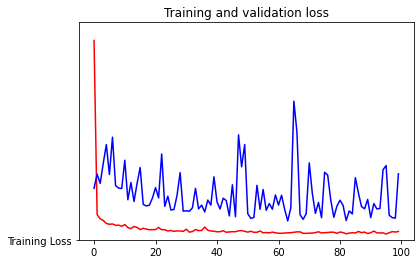

In [651]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_intc_tr=history_intc_tr.history['loss']
val_loss_intc_tr=history_intc_tr.history['val_loss']

epochs=range(len(loss_intc_tr)) 

plt.plot(epochs, loss_intc_tr, 'r', "Training Loss")
plt.plot(epochs, val_loss_intc_tr, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

MSE: 0.022171437701452443  RMSE: 0.14890076461003296 R^2 score: 0.5282563990712541 MAPE: 0.09003811864587503


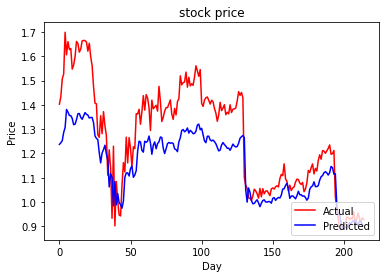

In [652]:
y_pred_intc_tr=making_y_pred(model_intc_tr,X_test_intc_tr)
mse_intc_tr,rmse_intc_tr,r_intc_tr,mape_intc_tr=Evalu(model_intc_tr,X_test_intc_tr,y_test_intc_tr,y_pred_intc_tr)
testset_plot(y_test_intc_tr,y_pred_intc_tr)

MSE: 0.006074027564194166  RMSE: 0.0779360479123375 R^2 score: 0.6658184060485621 MAPE: 0.05649865519054456


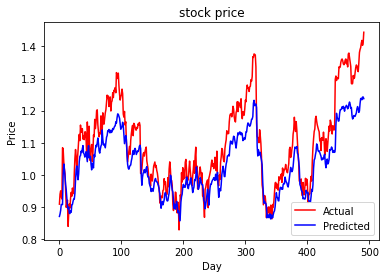

In [653]:
y_pred_intc_tr=making_y_pred(model_intc_tr,X_val_intc_tr)
mse_intc_tr,rmse_intc_tr,r_intc_tr,mape_intc_tr=Evalu(model_intc_tr,X_val_intc_tr,y_val_intc_tr,y_pred_intc_tr)
testset_plot(y_val_intc_tr,y_pred_intc_tr)

###### feature selection by correlation

In [654]:
model_intc_corr = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(5,kernel_size=1,input_shape=(10,5)),
    tf.keras.layers.Conv1D(64,kernel_size=2),
    tf.keras.layers.Conv1D(128,kernel_size=2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1)
    
])
model_intc_corr.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_intc_corr = model_intc_corr.fit(X_train_intc_corr,y_train_intc_corr,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_intc_corr, y_val_intc_corr),verbose = 1)

Epoch 1/100
32/32 [==============================] - 2s 51ms/step - loss: 0.0108 - val_loss: 0.0230
Epoch 2/100
32/32 [==============================] - 0s 16ms/step - loss: 0.0017 - val_loss: 0.0062
Epoch 3/100
32/32 [==============================] - 0s 15ms/step - loss: 9.4954e-04 - val_loss: 0.0017
Epoch 4/100
32/32 [==============================] - 0s 15ms/step - loss: 6.6542e-04 - val_loss: 0.0042
Epoch 5/100
32/32 [==============================] - 0s 15ms/step - loss: 6.4366e-04 - val_loss: 0.0028
Epoch 6/100
32/32 [==============================] - 0s 15ms/step - loss: 6.3097e-04 - val_loss: 0.0032
Epoch 7/100
32/32 [==============================] - 0s 15ms/step - loss: 5.9460e-04 - val_loss: 0.0017
Epoch 8/100
32/32 [==============================] - 0s 15ms/step - loss: 5.9023e-04 - val_loss: 0.0031
Epoch 9/100
32/32 [==============================] - 0s 15ms/step - loss: 5.0742e-04 - val_loss: 0.0034
Epoch 10/100
32/32 [==============================] - 0s 15ms/step - los

32/32 [==============================] - 0s 14ms/step - loss: 3.2704e-04 - val_loss: 0.0012
Epoch 79/100
32/32 [==============================] - 0s 14ms/step - loss: 2.9351e-04 - val_loss: 8.3970e-04
Epoch 80/100
32/32 [==============================] - 0s 14ms/step - loss: 3.5970e-04 - val_loss: 8.9119e-04
Epoch 81/100
32/32 [==============================] - 0s 14ms/step - loss: 2.8500e-04 - val_loss: 8.9778e-04
Epoch 82/100
32/32 [==============================] - 0s 14ms/step - loss: 3.1664e-04 - val_loss: 0.0047
Epoch 83/100
32/32 [==============================] - 0s 14ms/step - loss: 5.3873e-04 - val_loss: 9.2872e-04
Epoch 84/100
32/32 [==============================] - 0s 14ms/step - loss: 3.2187e-04 - val_loss: 0.0011
Epoch 85/100
32/32 [==============================] - 0s 14ms/step - loss: 3.2443e-04 - val_loss: 0.0019
Epoch 86/100
32/32 [==============================] - 0s 14ms/step - loss: 3.5971e-04 - val_loss: 0.0022
Epoch 87/100
32/32 [==============================] 

Text(0.5, 1.0, 'corraining and validation loss')

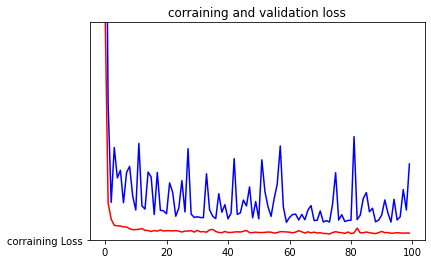

In [655]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_intc_corr=history_intc_corr.history['loss']
val_loss_intc_corr=history_intc_corr.history['val_loss']

epochs=range(len(loss_intc_corr)) 

plt.plot(epochs, loss_intc_corr, 'r', "corraining Loss")
plt.plot(epochs, val_loss_intc_corr, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('corraining and validation loss')

MSE: 0.018290072021476554  RMSE: 0.13524079274197026 R^2 score: 0.6108405529294014 MAPE: 0.09208281024697242


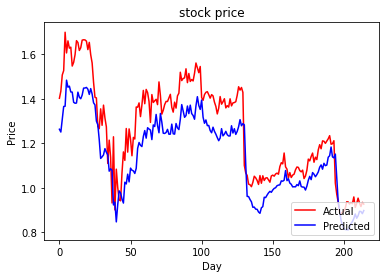

In [656]:
y_pred_intc_corr=making_y_pred(model_intc_corr,X_test_intc_corr)
mse_intc_corr,rmse_intc_corr,r_intc_corr,mape_intc_corr=Evalu(model_intc_corr,X_test_intc_corr,y_test_intc_corr,y_pred_intc_corr)
testset_plot(y_test_intc_corr,y_pred_intc_corr)

MSE: 0.006977525979879321  RMSE: 0.0835315867195118 R^2 score: 0.6161096193341046 MAPE: 0.0666312202826097


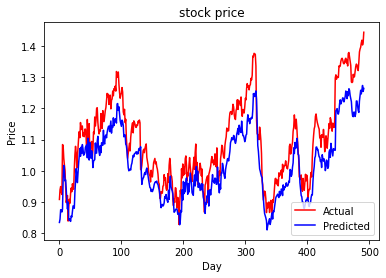

In [657]:
y_pred_intc_corr=making_y_pred(model_intc_corr,X_val_intc_corr)
mse_intc_corr,rmse_intc_corr,r_intc_corr,mape_intc_corr=Evalu(model_intc_corr,X_val_intc_corr,y_val_intc_corr,y_pred_intc_corr)
testset_plot(y_val_intc_corr,y_pred_intc_corr)

###### feature selection by svm-rfe

In [658]:
model_intc_svm = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(4,kernel_size=2,input_shape=(10,4)),
    tf.keras.layers.Conv1D(64,kernel_size=2),
    tf.keras.layers.Conv1D(128,kernel_size=2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1)
    
])
model_intc_svm.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_intc_svm = model_intc_svm.fit(X_train_intc_svm,y_train_intc_svm,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_intc_svm, y_val_intc_svm),verbose = 1)

Epoch 1/100
32/32 [==============================] - 2s 50ms/step - loss: 0.0116 - val_loss: 0.0052
Epoch 2/100
32/32 [==============================] - 0s 16ms/step - loss: 0.0013 - val_loss: 0.0045
Epoch 3/100
32/32 [==============================] - 0s 16ms/step - loss: 7.4845e-04 - val_loss: 0.0014
Epoch 4/100
32/32 [==============================] - 0s 15ms/step - loss: 6.0251e-04 - val_loss: 0.0021
Epoch 5/100
32/32 [==============================] - 0s 15ms/step - loss: 5.8977e-04 - val_loss: 0.0013
Epoch 6/100
32/32 [==============================] - 0s 15ms/step - loss: 5.3403e-04 - val_loss: 0.0014
Epoch 7/100
32/32 [==============================] - 0s 15ms/step - loss: 4.3092e-04 - val_loss: 0.0023
Epoch 8/100
32/32 [==============================] - 0s 15ms/step - loss: 4.2313e-04 - val_loss: 0.0017
Epoch 9/100
32/32 [==============================] - 0s 15ms/step - loss: 4.6106e-04 - val_loss: 0.0019
Epoch 10/100
32/32 [==============================] - 0s 15ms/step - los

32/32 [==============================] - 0s 15ms/step - loss: 4.4131e-04 - val_loss: 0.0013
Epoch 79/100
32/32 [==============================] - 0s 15ms/step - loss: 3.3004e-04 - val_loss: 0.0012
Epoch 80/100
32/32 [==============================] - 0s 15ms/step - loss: 3.0222e-04 - val_loss: 0.0018
Epoch 81/100
32/32 [==============================] - 0s 15ms/step - loss: 3.4102e-04 - val_loss: 0.0013
Epoch 82/100
32/32 [==============================] - 0s 15ms/step - loss: 3.6926e-04 - val_loss: 0.0018
Epoch 83/100
32/32 [==============================] - 0s 15ms/step - loss: 3.5103e-04 - val_loss: 0.0015
Epoch 84/100
32/32 [==============================] - 0s 15ms/step - loss: 3.5626e-04 - val_loss: 0.0011
Epoch 85/100
32/32 [==============================] - 0s 15ms/step - loss: 3.2914e-04 - val_loss: 0.0017
Epoch 86/100
32/32 [==============================] - 0s 15ms/step - loss: 3.3291e-04 - val_loss: 0.0012
Epoch 87/100
32/32 [==============================] - 0s 15ms/step -

Text(0.5, 1.0, 'svmaining and validation loss')

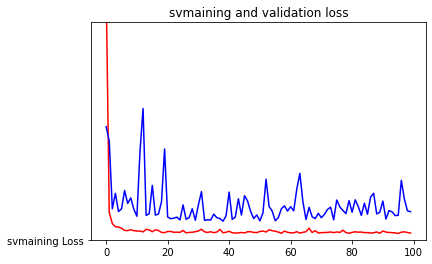

In [659]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_intc_svm=history_intc_svm.history['loss']
val_loss_intc_svm=history_intc_svm.history['val_loss']

epochs=range(len(loss_intc_svm)) 

plt.plot(epochs, loss_intc_svm, 'r', "svmaining Loss")
plt.plot(epochs, val_loss_intc_svm, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('svmaining and validation loss')

MSE: 0.012449285449635247  RMSE: 0.11157636599941426 R^2 score: 0.7351154748699025 MAPE: 0.06684403858205805


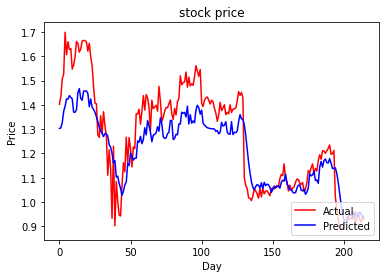

In [660]:
y_pred_intc_svm=making_y_pred(model_intc_svm,X_test_intc_svm)
mse_intc_svm,rmse_intc_svm,r_intc_svm,mape_intc_svm=Evalu(model_intc_svm,X_test_intc_svm,y_test_intc_svm,y_pred_intc_svm)
testset_plot(y_test_intc_svm,y_pred_intc_svm)

MSE: 0.0025879236302942914  RMSE: 0.050871638761635064 R^2 score: 0.8576173001099848 MAPE: 0.03665664354914461


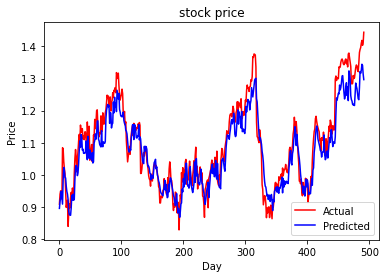

In [661]:
y_pred_intc_svm=making_y_pred(model_intc_svm,X_val_intc_svm)
mse_intc_svm,rmse_intc_svm,r_intc_svm,mape_intc_svm=Evalu(model_intc_svm,X_val_intc_svm,y_val_intc_svm,y_pred_intc_svm)
testset_plot(y_val_intc_svm,y_pred_intc_svm)

##### Conv1d+LSTM

###### Traditional features

In [662]:
model_intc_tr = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(5,kernel_size=2,input_shape=(10,5)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_intc_tr.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_intc_tr = model_intc_tr.fit(X_train_intc_tr,y_train_intc_tr,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_intc_tr, y_val_intc_tr),verbose = 1)

Epoch 1/100
32/32 [==============================] - 2s 49ms/step - loss: 0.0140 - val_loss: 0.0019
Epoch 2/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 3/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 4/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 5/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 6/100
32/32 [==============================] - 1s 16ms/step - loss: 9.9307e-04 - val_loss: 0.0017
Epoch 7/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 8/100
32/32 [==============================] - 0s 15ms/step - loss: 9.2851e-04 - val_loss: 0.0016
Epoch 9/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 10/100
32/32 [==============================] - 0s 15ms/step - loss: 9.6432e-04 - val_

Epoch 79/100
32/32 [==============================] - 0s 15ms/step - loss: 3.2923e-04 - val_loss: 7.4942e-04
Epoch 80/100
32/32 [==============================] - 0s 15ms/step - loss: 3.4401e-04 - val_loss: 0.0010
Epoch 81/100
32/32 [==============================] - 1s 16ms/step - loss: 3.7551e-04 - val_loss: 7.0743e-04
Epoch 82/100
32/32 [==============================] - 0s 15ms/step - loss: 3.4877e-04 - val_loss: 8.7579e-04
Epoch 83/100
32/32 [==============================] - 0s 15ms/step - loss: 3.3254e-04 - val_loss: 8.4872e-04
Epoch 84/100
32/32 [==============================] - 0s 15ms/step - loss: 3.3757e-04 - val_loss: 0.0029
Epoch 85/100
32/32 [==============================] - 0s 15ms/step - loss: 3.8644e-04 - val_loss: 7.6597e-04
Epoch 86/100
32/32 [==============================] - 0s 15ms/step - loss: 3.3652e-04 - val_loss: 0.0024
Epoch 87/100
32/32 [==============================] - 0s 15ms/step - loss: 3.5090e-04 - val_loss: 9.9367e-04
Epoch 88/100
32/32 [===========

In [663]:
model_intc_tr.summary()

Model: "sequential_144"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_212 (Conv1D)          (None, 9, 5)              55        
_________________________________________________________________
bidirectional_223 (Bidirecti (None, 9, 80)             14720     
_________________________________________________________________
bidirectional_224 (Bidirecti (None, 9, 80)             38720     
_________________________________________________________________
lstm_399 (LSTM)              (None, 40)                19360     
_________________________________________________________________
dropout_131 (Dropout)        (None, 40)                0         
_________________________________________________________________
dense_241 (Dense)            (None, 1)                 41        
Total params: 72,896
Trainable params: 72,896
Non-trainable params: 0
________________________________________________

Text(0.5, 1.0, 'Training and validation loss')

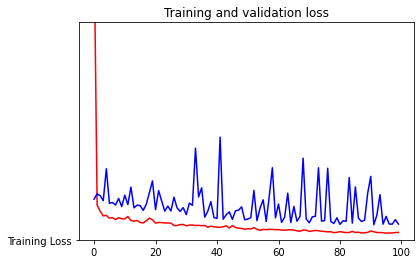

In [664]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_intc_tr=history_intc_tr.history['loss']
val_loss_intc_tr=history_intc_tr.history['val_loss']

epochs=range(len(loss_intc_tr)) 

plt.plot(epochs, loss_intc_tr, 'r', "Training Loss")
plt.plot(epochs, val_loss_intc_tr, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

MSE: 0.004600219765514909  RMSE: 0.06782491994477331 R^2 score: 0.9021207254816214 MAPE: 0.03827196255048837


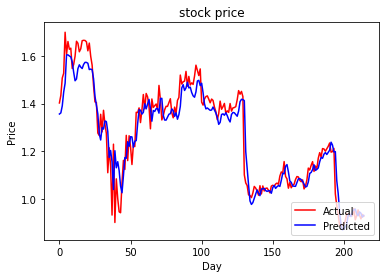

In [665]:
y_pred_intc_tr=making_y_pred(model_intc_tr,X_test_intc_tr)
mse_intc_tr,rmse_intc_tr,r_intc_tr,mape_intc_tr=Evalu(model_intc_tr,X_test_intc_tr,y_test_intc_tr,y_pred_intc_tr)
testset_plot(y_test_intc_tr,y_pred_intc_tr)

MSE: 0.0014458937025245975  RMSE: 0.03802490897457346 R^2 score: 0.9204496428296798 MAPE: 0.02761483498888186


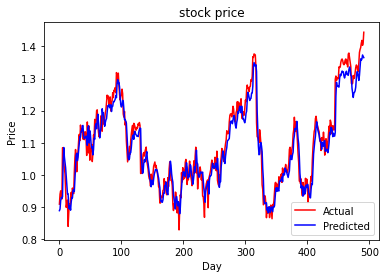

In [666]:
y_pred_intc_tr=making_y_pred(model_intc_tr,X_val_intc_tr)
mse_intc_tr,rmse_intc_tr,r_intc_tr,mape_intc_tr=Evalu(model_intc_tr,X_val_intc_tr,y_val_intc_tr,y_pred_intc_tr)
testset_plot(y_val_intc_tr,y_pred_intc_tr)

###### feature selection by correlation

In [667]:
model_intc_corr = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(5,kernel_size=2,input_shape=(10,5)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_intc_corr.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_intc_corr = model_intc_corr.fit(X_train_intc_corr,y_train_intc_corr,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_intc_corr, y_val_intc_corr),verbose = 1)

Epoch 1/100
32/32 [==============================] - 2s 50ms/step - loss: 0.0189 - val_loss: 0.0085
Epoch 2/100
32/32 [==============================] - 0s 16ms/step - loss: 0.0023 - val_loss: 0.0058
Epoch 3/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 4/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0011 - val_loss: 0.0028
Epoch 5/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0011 - val_loss: 0.0042
Epoch 6/100
32/32 [==============================] - 1s 16ms/step - loss: 9.5792e-04 - val_loss: 0.0023
Epoch 7/100
32/32 [==============================] - 0s 15ms/step - loss: 9.0658e-04 - val_loss: 0.0020
Epoch 8/100
32/32 [==============================] - 0s 15ms/step - loss: 7.9101e-04 - val_loss: 0.0017
Epoch 9/100
32/32 [==============================] - 0s 15ms/step - loss: 8.2116e-04 - val_loss: 0.0015
Epoch 10/100
32/32 [==============================] - 0s 15ms/step - loss: 9.0980e-0

Epoch 79/100
32/32 [==============================] - 0s 14ms/step - loss: 4.1905e-04 - val_loss: 0.0016
Epoch 80/100
32/32 [==============================] - 0s 14ms/step - loss: 3.5122e-04 - val_loss: 0.0011
Epoch 81/100
32/32 [==============================] - 0s 14ms/step - loss: 4.5724e-04 - val_loss: 9.6319e-04
Epoch 82/100
32/32 [==============================] - 0s 14ms/step - loss: 3.8494e-04 - val_loss: 0.0013
Epoch 83/100
32/32 [==============================] - 0s 14ms/step - loss: 3.9892e-04 - val_loss: 9.0392e-04
Epoch 84/100
32/32 [==============================] - 0s 14ms/step - loss: 4.3019e-04 - val_loss: 0.0020
Epoch 85/100
32/32 [==============================] - 0s 15ms/step - loss: 3.4968e-04 - val_loss: 0.0016
Epoch 86/100
32/32 [==============================] - 0s 15ms/step - loss: 4.1456e-04 - val_loss: 0.0012
Epoch 87/100
32/32 [==============================] - 0s 14ms/step - loss: 3.8676e-04 - val_loss: 8.8241e-04
Epoch 88/100
32/32 [=======================

Text(0.5, 1.0, 'corraining and validation loss')

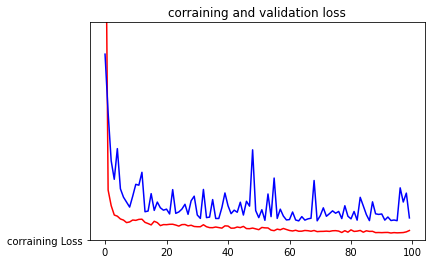

In [668]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_intc_corr=history_intc_corr.history['loss']
val_loss_intc_corr=history_intc_corr.history['val_loss']

epochs=range(len(loss_intc_corr)) 

plt.plot(epochs, loss_intc_corr, 'r', "corraining Loss")
plt.plot(epochs, val_loss_intc_corr, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('corraining and validation loss')

MSE: 0.0069209175838157696  RMSE: 0.0831920524077617 R^2 score: 0.8527430369341162 MAPE: 0.052138543425494406


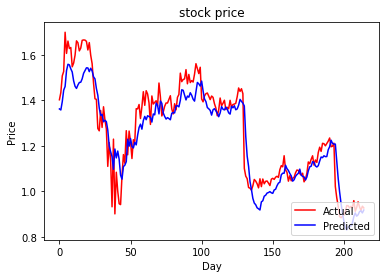

In [669]:
y_pred_intc_corr=making_y_pred(model_intc_corr,X_test_intc_corr)
mse_intc_corr,rmse_intc_corr,r_intc_corr,mape_intc_corr=Evalu(model_intc_corr,X_test_intc_corr,y_test_intc_corr,y_pred_intc_corr)
testset_plot(y_test_intc_corr,y_pred_intc_corr)

MSE: 0.0020128907189910237  RMSE: 0.04486525068458911 R^2 score: 0.8892545313939947 MAPE: 0.03277280341573352


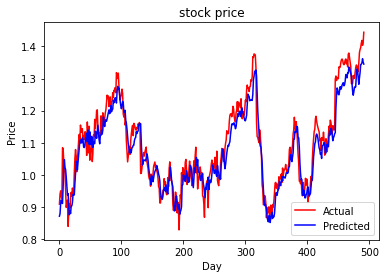

In [670]:
y_pred_intc_corr=making_y_pred(model_intc_corr,X_val_intc_corr)
mse_intc_corr,rmse_intc_corr,r_intc_corr,mape_intc_corr=Evalu(model_intc_corr,X_val_intc_corr,y_val_intc_corr,y_pred_intc_corr)
testset_plot(y_val_intc_corr,y_pred_intc_corr)

###### feature selection by svm-rfe

In [671]:
model_intc_svm = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(4,kernel_size=2,input_shape=(10,4)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_intc_svm.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_intc_svm = model_intc_svm.fit(X_train_intc_svm,y_train_intc_svm,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_intc_svm, y_val_intc_svm),verbose = 1)

Epoch 1/100
32/32 [==============================] - 2s 49ms/step - loss: 0.0189 - val_loss: 0.0046
Epoch 2/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0019 - val_loss: 0.0036
Epoch 3/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 4/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 5/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 6/100
32/32 [==============================] - 0s 14ms/step - loss: 9.4452e-04 - val_loss: 0.0014
Epoch 7/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0010 - val_loss: 0.0025
Epoch 8/100
32/32 [==============================] - 0s 14ms/step - loss: 7.8159e-04 - val_loss: 0.0014
Epoch 9/100
32/32 [==============================] - 0s 14ms/step - loss: 8.2723e-04 - val_loss: 0.0021
Epoch 10/100
32/32 [==============================] - 0s 14ms/step - loss: 7.7098e-04 - 

32/32 [==============================] - 0s 14ms/step - loss: 3.8471e-04 - val_loss: 0.0023
Epoch 80/100
32/32 [==============================] - 0s 14ms/step - loss: 3.2961e-04 - val_loss: 9.1178e-04
Epoch 81/100
32/32 [==============================] - 0s 14ms/step - loss: 3.5064e-04 - val_loss: 0.0012
Epoch 82/100
32/32 [==============================] - 0s 14ms/step - loss: 3.5360e-04 - val_loss: 0.0013
Epoch 83/100
32/32 [==============================] - 0s 14ms/step - loss: 3.8319e-04 - val_loss: 8.9166e-04
Epoch 84/100
32/32 [==============================] - 0s 14ms/step - loss: 3.5396e-04 - val_loss: 0.0010
Epoch 85/100
32/32 [==============================] - 0s 14ms/step - loss: 3.5711e-04 - val_loss: 9.9430e-04
Epoch 86/100
32/32 [==============================] - 0s 14ms/step - loss: 3.7789e-04 - val_loss: 0.0019
Epoch 87/100
32/32 [==============================] - 0s 14ms/step - loss: 4.2000e-04 - val_loss: 0.0015
Epoch 88/100
32/32 [==============================] - 0s

Text(0.5, 1.0, 'svmaining and validation loss')

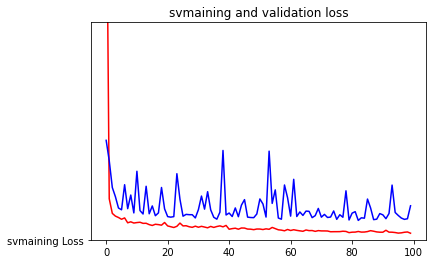

In [672]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_intc_svm=history_intc_svm.history['loss']
val_loss_intc_svm=history_intc_svm.history['val_loss']

epochs=range(len(loss_intc_svm)) 

plt.plot(epochs, loss_intc_svm, 'r', "svmaining Loss")
plt.plot(epochs, val_loss_intc_svm, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('svmaining and validation loss')

MSE: 0.009869491379255642  RMSE: 0.09934531382634836 R^2 score: 0.7900059768212385 MAPE: 0.05819132287596257


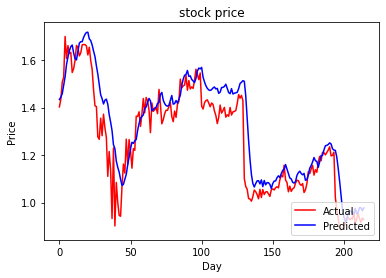

In [673]:
y_pred_intc_svm=making_y_pred(model_intc_svm,X_test_intc_svm)
mse_intc_svm,rmse_intc_svm,r_intc_svm,mape_intc_svm=Evalu(model_intc_svm,X_test_intc_svm,y_test_intc_svm,y_pred_intc_svm)
testset_plot(y_test_intc_svm,y_pred_intc_svm)

MSE: 0.0031293135347835134  RMSE: 0.05594026756088599 R^2 score: 0.8278310439036504 MAPE: 0.04095392536315471


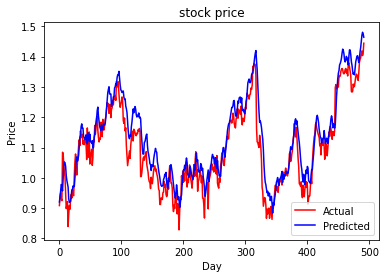

In [674]:
y_pred_intc_svm=making_y_pred(model_intc_svm,X_val_intc_svm)
mse_intc_svm,rmse_intc_svm,r_intc_svm,mape_intc_svm=Evalu(model_intc_svm,X_val_intc_svm,y_val_intc_svm,y_pred_intc_svm)
testset_plot(y_val_intc_svm,y_pred_intc_svm)

#### window_size 50

In [675]:
#Traning:2010-01-04 to 2018-01-03, Validation: 2018-01-04 to 2020-01-02, testing: 2020-01-03

df_intc_picked_tr = df_intc[['Close','Open','High','Low','Volume']]
df_intc_picked_corr = df_intc[['Close','H-O','7 DAYS STD DEV','Volume','MACD']]
df_intc_picked_svm = df_intc[['Close','6 DAYS WMS','MACD','21 DAYS MA']]
windows_size=50

train_sc_tr,val_sc_tr,test_sc_tr=making_scaled_training_val_test_data(df_intc_picked_tr,7519,9534,10036,10261)
X_train_intc_tr,y_train_intc_tr,X_val_intc_tr,y_val_intc_tr=making_train_val(train_sc_tr,val_sc_tr,windows_size)
X_test_intc_tr,y_test_intc_tr=making_test(test_sc_tr,windows_size)

train_sc_corr,val_sc_corr,test_sc_corr=making_scaled_training_val_test_data(df_intc_picked_corr,7519,9534,10036,10261)
X_train_intc_corr,y_train_intc_corr,X_val_intc_corr,y_val_intc_corr=making_train_val(train_sc_corr,val_sc_corr,windows_size)
X_test_intc_corr,y_test_intc_corr=making_test(test_sc_corr,windows_size)

train_sc_svm,val_sc_svm,test_sc_svm=making_scaled_training_val_test_data(df_intc_picked_svm,7519,9534,10036,10261)
X_train_intc_svm,y_train_intc_svm,X_val_intc_svm,y_val_intc_svm=making_train_val(train_sc_svm,val_sc_svm,windows_size)
X_test_intc_svm,y_test_intc_svm=making_test(test_sc_svm,windows_size)

##### 3CNN+LSTM+3DNN

###### Traditional features

In [676]:
model_intc_tr = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(5,kernel_size=2,input_shape=(50,5)),
    tf.keras.layers.Conv1D(64,kernel_size=2),
    tf.keras.layers.Conv1D(128,kernel_size=2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1)
    
])
model_intc_tr.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_intc_tr = model_intc_tr.fit(X_train_intc_tr,y_train_intc_tr,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_intc_tr, y_val_intc_tr),verbose = 1)

Epoch 1/100
31/31 [==============================] - 3s 101ms/step - loss: 0.0092 - val_loss: 0.0129
Epoch 2/100
31/31 [==============================] - 2s 64ms/step - loss: 0.0015 - val_loss: 0.0110
Epoch 3/100
31/31 [==============================] - 2s 64ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 4/100
31/31 [==============================] - 2s 64ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 5/100
31/31 [==============================] - 2s 64ms/step - loss: 0.0010 - val_loss: 0.0025
Epoch 6/100
31/31 [==============================] - 2s 64ms/step - loss: 0.0010 - val_loss: 0.0028
Epoch 7/100
31/31 [==============================] - 2s 63ms/step - loss: 7.3412e-04 - val_loss: 0.0024
Epoch 8/100
31/31 [==============================] - 2s 64ms/step - loss: 7.6758e-04 - val_loss: 0.0024
Epoch 9/100
31/31 [==============================] - 2s 64ms/step - loss: 6.0941e-04 - val_loss: 0.0024
Epoch 10/100
31/31 [==============================] - 2s 64ms/step - loss: 6.3885e-04 -

31/31 [==============================] - 2s 64ms/step - loss: 2.8746e-04 - val_loss: 7.3921e-04
Epoch 79/100
31/31 [==============================] - 2s 64ms/step - loss: 2.6269e-04 - val_loss: 0.0013
Epoch 80/100
31/31 [==============================] - 2s 64ms/step - loss: 3.6156e-04 - val_loss: 0.0056
Epoch 81/100
31/31 [==============================] - 2s 63ms/step - loss: 4.3486e-04 - val_loss: 0.0016
Epoch 82/100
31/31 [==============================] - 2s 64ms/step - loss: 3.4037e-04 - val_loss: 9.9973e-04
Epoch 83/100
31/31 [==============================] - 2s 65ms/step - loss: 3.6606e-04 - val_loss: 0.0011
Epoch 84/100
31/31 [==============================] - 2s 63ms/step - loss: 2.7953e-04 - val_loss: 0.0017
Epoch 85/100
31/31 [==============================] - 2s 63ms/step - loss: 2.8942e-04 - val_loss: 5.6371e-04
Epoch 86/100
31/31 [==============================] - 2s 63ms/step - loss: 2.9270e-04 - val_loss: 7.7397e-04
Epoch 87/100
31/31 [==============================] 

In [677]:
model_intc_tr.summary()

Model: "sequential_147"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_215 (Conv1D)          (None, 49, 5)             55        
_________________________________________________________________
conv1d_216 (Conv1D)          (None, 48, 64)            704       
_________________________________________________________________
conv1d_217 (Conv1D)          (None, 47, 128)           16512     
_________________________________________________________________
bidirectional_229 (Bidirecti (None, 47, 80)            54080     
_________________________________________________________________
bidirectional_230 (Bidirecti (None, 47, 80)            38720     
_________________________________________________________________
lstm_408 (LSTM)              (None, 40)                19360     
_________________________________________________________________
dropout_134 (Dropout)        (None, 40)             

Text(0.5, 1.0, 'Training and validation loss')

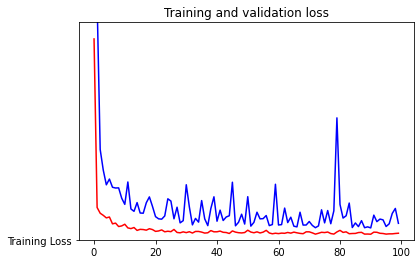

In [678]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_intc_tr=history_intc_tr.history['loss']
val_loss_intc_tr=history_intc_tr.history['val_loss']

epochs=range(len(loss_intc_tr)) 

plt.plot(epochs, loss_intc_tr, 'r', "Training Loss")
plt.plot(epochs, val_loss_intc_tr, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

MSE: 0.0043523241121504975  RMSE: 0.06597214648736614 R^2 score: 0.8819024617995672 MAPE: 0.04249836728667247


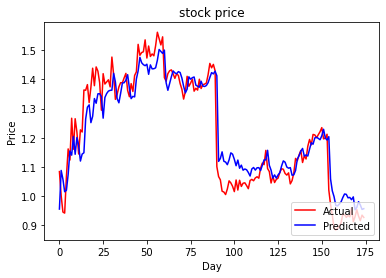

In [679]:
y_pred_intc_tr=making_y_pred(model_intc_tr,X_test_intc_tr)
mse_intc_tr,rmse_intc_tr,r_intc_tr,mape_intc_tr=Evalu(model_intc_tr,X_test_intc_tr,y_test_intc_tr,y_pred_intc_tr)
testset_plot(y_test_intc_tr,y_pred_intc_tr)

MSE: 0.001516001659721284  RMSE: 0.03893586598139669 R^2 score: 0.9172483127165538 MAPE: 0.027519419294022622


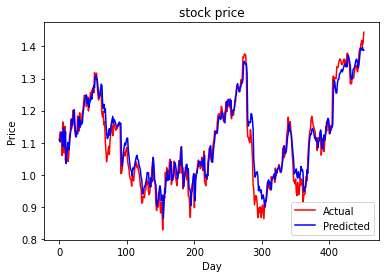

In [680]:
y_pred_intc_tr=making_y_pred(model_intc_tr,X_val_intc_tr)
mse_intc_tr,rmse_intc_tr,r_intc_tr,mape_intc_tr=Evalu(model_intc_tr,X_val_intc_tr,y_val_intc_tr,y_pred_intc_tr)
testset_plot(y_val_intc_tr,y_pred_intc_tr)

###### feature selection by correlation

In [681]:
model_intc_corr = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(5,kernel_size=2,input_shape=(50,5)),
    tf.keras.layers.Conv1D(64,kernel_size=2),
    tf.keras.layers.Conv1D(128,kernel_size=2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1)
    
])
model_intc_corr.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_intc_corr = model_intc_corr.fit(X_train_intc_corr,y_train_intc_corr,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_intc_corr, y_val_intc_corr),verbose = 1)

Epoch 1/100
31/31 [==============================] - 3s 101ms/step - loss: 0.0139 - val_loss: 0.0468
Epoch 2/100
31/31 [==============================] - 2s 66ms/step - loss: 0.0024 - val_loss: 0.0256
Epoch 3/100
31/31 [==============================] - 2s 66ms/step - loss: 0.0013 - val_loss: 0.0153
Epoch 4/100
31/31 [==============================] - 2s 65ms/step - loss: 0.0011 - val_loss: 0.0109
Epoch 5/100
31/31 [==============================] - 2s 65ms/step - loss: 9.2203e-04 - val_loss: 0.0042
Epoch 6/100
31/31 [==============================] - 2s 65ms/step - loss: 7.6198e-04 - val_loss: 0.0045
Epoch 7/100
31/31 [==============================] - 2s 65ms/step - loss: 8.1621e-04 - val_loss: 0.0064
Epoch 8/100
31/31 [==============================] - 2s 65ms/step - loss: 6.2355e-04 - val_loss: 0.0024
Epoch 9/100
31/31 [==============================] - 2s 65ms/step - loss: 7.8944e-04 - val_loss: 0.0109
Epoch 10/100
31/31 [==============================] - 2s 66ms/step - loss: 6.93

31/31 [==============================] - 2s 65ms/step - loss: 4.0059e-04 - val_loss: 0.0043
Epoch 80/100
31/31 [==============================] - 2s 65ms/step - loss: 3.4489e-04 - val_loss: 0.0018
Epoch 81/100
31/31 [==============================] - 2s 66ms/step - loss: 3.1642e-04 - val_loss: 0.0016
Epoch 82/100
31/31 [==============================] - 2s 66ms/step - loss: 3.6649e-04 - val_loss: 0.0013
Epoch 83/100
31/31 [==============================] - 2s 65ms/step - loss: 3.4478e-04 - val_loss: 0.0015
Epoch 84/100
31/31 [==============================] - 2s 65ms/step - loss: 3.0845e-04 - val_loss: 0.0021
Epoch 85/100
31/31 [==============================] - 2s 65ms/step - loss: 3.6173e-04 - val_loss: 0.0026
Epoch 86/100
31/31 [==============================] - 2s 66ms/step - loss: 3.0476e-04 - val_loss: 0.0020
Epoch 87/100
31/31 [==============================] - 2s 66ms/step - loss: 3.6711e-04 - val_loss: 0.0061
Epoch 88/100
31/31 [==============================] - 2s 65ms/step -

Text(0.5, 1.0, 'corraining and validation loss')

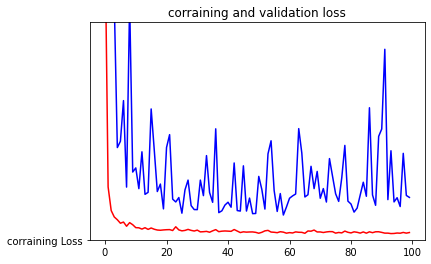

In [682]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_intc_corr=history_intc_corr.history['loss']
val_loss_intc_corr=history_intc_corr.history['val_loss']

epochs=range(len(loss_intc_corr)) 

plt.plot(epochs, loss_intc_corr, 'r', "corraining Loss")
plt.plot(epochs, val_loss_intc_corr, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('corraining and validation loss')

MSE: 0.0936832681273279  RMSE: 0.3060772257573698 R^2 score: -1.542035715015226 MAPE: 0.17747121372637048


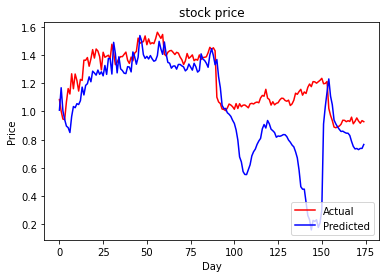

In [683]:
y_pred_intc_corr=making_y_pred(model_intc_corr,X_test_intc_corr)
mse_intc_corr,rmse_intc_corr,r_intc_corr,mape_intc_corr=Evalu(model_intc_corr,X_test_intc_corr,y_test_intc_corr,y_pred_intc_corr)
testset_plot(y_test_intc_corr,y_pred_intc_corr)

MSE: 0.0038981510966220514  RMSE: 0.06243517515489207 R^2 score: 0.7872175281189357 MAPE: 0.046140036284453616


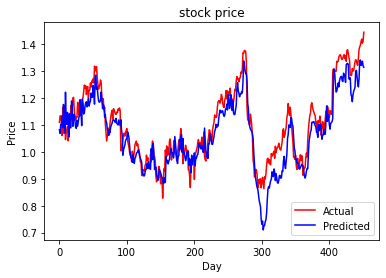

In [684]:
y_pred_intc_corr=making_y_pred(model_intc_corr,X_val_intc_corr)
mse_intc_corr,rmse_intc_corr,r_intc_corr,mape_intc_corr=Evalu(model_intc_corr,X_val_intc_corr,y_val_intc_corr,y_pred_intc_corr)
testset_plot(y_val_intc_corr,y_pred_intc_corr)

###### feature selection by svm-rfe

In [685]:
model_intc_svm = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(4,kernel_size=2,input_shape=(50,4)),
    tf.keras.layers.Conv1D(64,kernel_size=2),
    tf.keras.layers.Conv1D(128,kernel_size=2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1)
    
])
model_intc_svm.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_intc_svm = model_intc_svm.fit(X_train_intc_svm,y_train_intc_svm,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_intc_svm, y_val_intc_svm),verbose = 1)

Epoch 1/100
31/31 [==============================] - 4s 113ms/step - loss: 0.0105 - val_loss: 0.0125
Epoch 2/100
31/31 [==============================] - 2s 75ms/step - loss: 0.0014 - val_loss: 0.0065
Epoch 3/100
31/31 [==============================] - 2s 75ms/step - loss: 8.6815e-04 - val_loss: 0.0033
Epoch 4/100
31/31 [==============================] - 2s 75ms/step - loss: 6.9841e-04 - val_loss: 0.0058
Epoch 5/100
31/31 [==============================] - 2s 75ms/step - loss: 6.2428e-04 - val_loss: 0.0025
Epoch 6/100
31/31 [==============================] - 2s 74ms/step - loss: 6.1372e-04 - val_loss: 0.0017
Epoch 7/100
31/31 [==============================] - 2s 75ms/step - loss: 5.0713e-04 - val_loss: 0.0017
Epoch 8/100
31/31 [==============================] - 2s 75ms/step - loss: 4.7877e-04 - val_loss: 0.0017
Epoch 9/100
31/31 [==============================] - 2s 75ms/step - loss: 4.7585e-04 - val_loss: 0.0020
Epoch 10/100
31/31 [==============================] - 2s 75ms/step - lo

31/31 [==============================] - 2s 75ms/step - loss: 3.8632e-04 - val_loss: 0.0056
Epoch 80/100
31/31 [==============================] - 2s 76ms/step - loss: 3.5740e-04 - val_loss: 0.0013
Epoch 81/100
31/31 [==============================] - 2s 75ms/step - loss: 3.2275e-04 - val_loss: 0.0020
Epoch 82/100
31/31 [==============================] - 2s 75ms/step - loss: 4.1397e-04 - val_loss: 0.0052
Epoch 83/100
31/31 [==============================] - 2s 75ms/step - loss: 4.5924e-04 - val_loss: 0.0013
Epoch 84/100
31/31 [==============================] - 2s 75ms/step - loss: 3.2829e-04 - val_loss: 0.0012
Epoch 85/100
31/31 [==============================] - 2s 75ms/step - loss: 3.8562e-04 - val_loss: 0.0018
Epoch 86/100
31/31 [==============================] - 2s 75ms/step - loss: 4.3147e-04 - val_loss: 0.0014
Epoch 87/100
31/31 [==============================] - 2s 76ms/step - loss: 3.2648e-04 - val_loss: 0.0014
Epoch 88/100
31/31 [==============================] - 2s 75ms/step -

Text(0.5, 1.0, 'svmaining and validation loss')

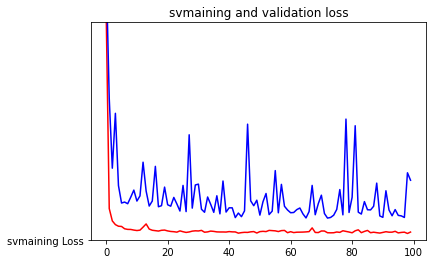

In [686]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_intc_svm=history_intc_svm.history['loss']
val_loss_intc_svm=history_intc_svm.history['val_loss']

epochs=range(len(loss_intc_svm)) 

plt.plot(epochs, loss_intc_svm, 'r', "svmaining Loss")
plt.plot(epochs, val_loss_intc_svm, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('svmaining and validation loss')

MSE: 0.010667370108476223  RMSE: 0.10328296136573653 R^2 score: 0.710547717398404 MAPE: 0.0680547193182618


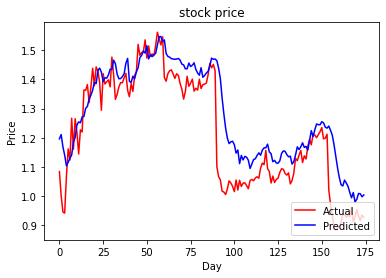

In [687]:
y_pred_intc_svm=making_y_pred(model_intc_svm,X_test_intc_svm)
mse_intc_svm,rmse_intc_svm,r_intc_svm,mape_intc_svm=Evalu(model_intc_svm,X_test_intc_svm,y_test_intc_svm,y_pred_intc_svm)
testset_plot(y_test_intc_svm,y_pred_intc_svm)

MSE: 0.005479453938565951  RMSE: 0.07402333374393476 R^2 score: 0.7009013440713378 MAPE: 0.05747535997907583


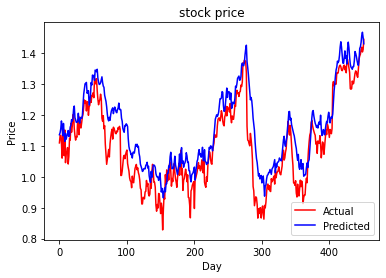

In [688]:
y_pred_intc_svm=making_y_pred(model_intc_svm,X_val_intc_svm)
mse_intc_svm,rmse_intc_svm,r_intc_svm,mape_intc_svm=Evalu(model_intc_svm,X_val_intc_svm,y_val_intc_svm,y_pred_intc_svm)
testset_plot(y_val_intc_svm,y_pred_intc_svm)

##### Conv1d+LSTM

###### Traditional features

In [689]:
model_intc_tr = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(5,kernel_size=2,input_shape=(50,5)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_intc_tr.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_intc_tr = model_intc_tr.fit(X_train_intc_tr,y_train_intc_tr,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_intc_tr, y_val_intc_tr),verbose = 1)

Epoch 1/100
31/31 [==============================] - 3s 99ms/step - loss: 0.0120 - val_loss: 0.0109
Epoch 2/100
31/31 [==============================] - 2s 63ms/step - loss: 0.0016 - val_loss: 0.0044
Epoch 3/100
31/31 [==============================] - 2s 63ms/step - loss: 0.0013 - val_loss: 0.0045
Epoch 4/100
31/31 [==============================] - 2s 62ms/step - loss: 0.0012 - val_loss: 0.0037
Epoch 5/100
31/31 [==============================] - 2s 63ms/step - loss: 0.0013 - val_loss: 0.0039
Epoch 6/100
31/31 [==============================] - 2s 62ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 7/100
31/31 [==============================] - 2s 62ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 8/100
31/31 [==============================] - 2s 62ms/step - loss: 9.8509e-04 - val_loss: 0.0057
Epoch 9/100
31/31 [==============================] - 2s 62ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 10/100
31/31 [==============================] - 2s 63ms/step - loss: 9.6496e-04 - val_loss

31/31 [==============================] - 2s 62ms/step - loss: 3.8169e-04 - val_loss: 8.2822e-04
Epoch 80/100
31/31 [==============================] - 2s 62ms/step - loss: 3.4802e-04 - val_loss: 0.0017
Epoch 81/100
31/31 [==============================] - 2s 62ms/step - loss: 3.2117e-04 - val_loss: 0.0014
Epoch 82/100
31/31 [==============================] - 2s 62ms/step - loss: 3.6078e-04 - val_loss: 0.0030
Epoch 83/100
31/31 [==============================] - 2s 63ms/step - loss: 3.4619e-04 - val_loss: 0.0027
Epoch 84/100
31/31 [==============================] - 2s 63ms/step - loss: 3.8861e-04 - val_loss: 0.0015
Epoch 85/100
31/31 [==============================] - 2s 63ms/step - loss: 3.6434e-04 - val_loss: 0.0020
Epoch 86/100
31/31 [==============================] - 2s 63ms/step - loss: 3.7793e-04 - val_loss: 0.0031
Epoch 87/100
31/31 [==============================] - 2s 63ms/step - loss: 3.3178e-04 - val_loss: 0.0017
Epoch 88/100
31/31 [==============================] - 2s 63ms/st

In [690]:
model_intc_tr.summary()

Model: "sequential_150"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_224 (Conv1D)          (None, 49, 5)             55        
_________________________________________________________________
bidirectional_235 (Bidirecti (None, 49, 80)            14720     
_________________________________________________________________
bidirectional_236 (Bidirecti (None, 49, 80)            38720     
_________________________________________________________________
lstm_417 (LSTM)              (None, 40)                19360     
_________________________________________________________________
dropout_137 (Dropout)        (None, 40)                0         
_________________________________________________________________
dense_253 (Dense)            (None, 1)                 41        
Total params: 72,896
Trainable params: 72,896
Non-trainable params: 0
________________________________________________

Text(0.5, 1.0, 'Training and validation loss')

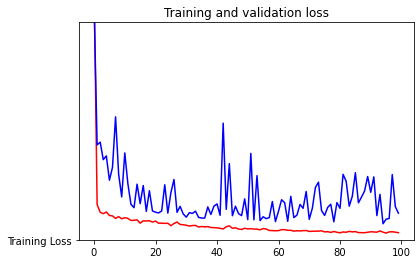

In [691]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_intc_tr=history_intc_tr.history['loss']
val_loss_intc_tr=history_intc_tr.history['val_loss']

epochs=range(len(loss_intc_tr)) 

plt.plot(epochs, loss_intc_tr, 'r', "Training Loss")
plt.plot(epochs, val_loss_intc_tr, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

MSE: 0.006168510195102575  RMSE: 0.07853986373239118 R^2 score: 0.83262141108192 MAPE: 0.04814296630809402


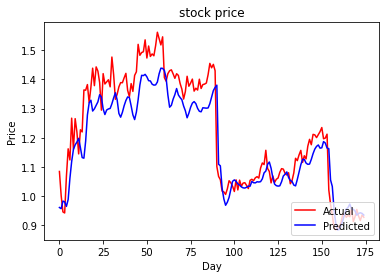

In [692]:
y_pred_intc_tr=making_y_pred(model_intc_tr,X_test_intc_tr)
mse_intc_tr,rmse_intc_tr,r_intc_tr,mape_intc_tr=Evalu(model_intc_tr,X_test_intc_tr,y_test_intc_tr,y_pred_intc_tr)
testset_plot(y_test_intc_tr,y_pred_intc_tr)

MSE: 0.002450951749611093  RMSE: 0.04950708787245613 R^2 score: 0.8662136077292152 MAPE: 0.03608805695328409


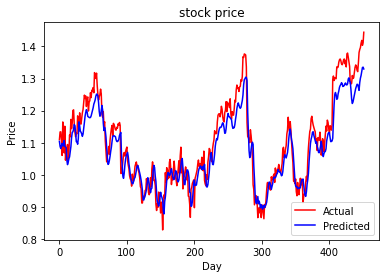

In [693]:
y_pred_intc_tr=making_y_pred(model_intc_tr,X_val_intc_tr)
mse_intc_tr,rmse_intc_tr,r_intc_tr,mape_intc_tr=Evalu(model_intc_tr,X_val_intc_tr,y_val_intc_tr,y_pred_intc_tr)
testset_plot(y_val_intc_tr,y_pred_intc_tr)

###### feature selection by correlation

In [715]:
model_intc_corr = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(5,kernel_size=2,input_shape=(50,5)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_intc_corr.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_intc_corr = model_intc_corr.fit(X_train_intc_corr,y_train_intc_corr,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_intc_corr, y_val_intc_corr),verbose = 1)

Epoch 1/100
31/31 [==============================] - 3s 96ms/step - loss: 0.0100 - val_loss: 0.0066
Epoch 2/100
31/31 [==============================] - 2s 60ms/step - loss: 0.0021 - val_loss: 0.0103
Epoch 3/100
31/31 [==============================] - 2s 60ms/step - loss: 0.0015 - val_loss: 0.0080
Epoch 4/100
31/31 [==============================] - 2s 60ms/step - loss: 0.0014 - val_loss: 0.0047
Epoch 5/100
31/31 [==============================] - 2s 60ms/step - loss: 0.0013 - val_loss: 0.0036
Epoch 6/100
31/31 [==============================] - 2s 60ms/step - loss: 0.0014 - val_loss: 0.0106
Epoch 7/100
31/31 [==============================] - 2s 60ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 8/100
31/31 [==============================] - 2s 60ms/step - loss: 0.0011 - val_loss: 0.0036
Epoch 9/100
31/31 [==============================] - 2s 60ms/step - loss: 9.7239e-04 - val_loss: 0.0037
Epoch 10/100
31/31 [==============================] - 2s 61ms/step - loss: 0.0010 - val_loss: 0.

31/31 [==============================] - 2s 60ms/step - loss: 3.4628e-04 - val_loss: 0.0021
Epoch 80/100
31/31 [==============================] - 2s 60ms/step - loss: 3.9582e-04 - val_loss: 0.0031
Epoch 81/100
31/31 [==============================] - 2s 60ms/step - loss: 4.0116e-04 - val_loss: 0.0041
Epoch 82/100
31/31 [==============================] - 2s 60ms/step - loss: 4.1506e-04 - val_loss: 0.0027
Epoch 83/100
31/31 [==============================] - 2s 61ms/step - loss: 3.5549e-04 - val_loss: 0.0022
Epoch 84/100
31/31 [==============================] - 2s 60ms/step - loss: 4.0772e-04 - val_loss: 0.0032
Epoch 85/100
31/31 [==============================] - 2s 62ms/step - loss: 4.1178e-04 - val_loss: 0.0027
Epoch 86/100
31/31 [==============================] - 2s 60ms/step - loss: 3.4645e-04 - val_loss: 0.0026
Epoch 87/100
31/31 [==============================] - 2s 60ms/step - loss: 3.4638e-04 - val_loss: 0.0020
Epoch 88/100
31/31 [==============================] - 2s 60ms/step -

Text(0.5, 1.0, 'corraining and validation loss')

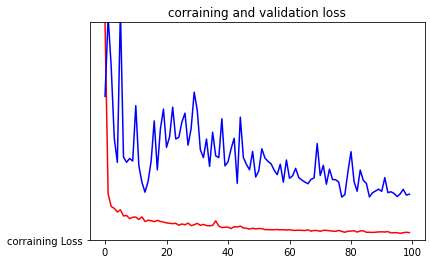

In [716]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_intc_corr=history_intc_corr.history['loss']
val_loss_intc_corr=history_intc_corr.history['val_loss']

epochs=range(len(loss_intc_corr)) 

plt.plot(epochs, loss_intc_corr, 'r', "corraining Loss")
plt.plot(epochs, val_loss_intc_corr, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('corraining and validation loss')

MSE: 0.03474960157314298  RMSE: 0.18641245015594582 R^2 score: 0.05709172996163825 MAPE: 0.10771281545949232


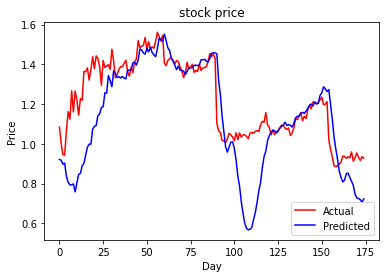

In [717]:
y_pred_intc_corr=making_y_pred(model_intc_corr,X_test_intc_corr)
mse_intc_corr,rmse_intc_corr,r_intc_corr,mape_intc_corr=Evalu(model_intc_corr,X_test_intc_corr,y_test_intc_corr,y_pred_intc_corr)
testset_plot(y_test_intc_corr,y_pred_intc_corr)

MSE: 0.004195515588399805  RMSE: 0.06477279975730403 R^2 score: 0.7709857428336099 MAPE: 0.042870458532140665


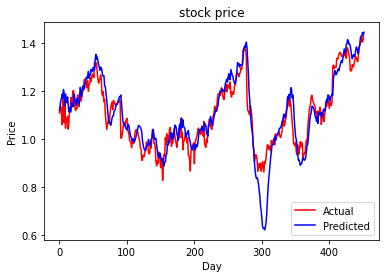

In [718]:
y_pred_intc_corr=making_y_pred(model_intc_corr,X_val_intc_corr)
mse_intc_corr,rmse_intc_corr,r_intc_corr,mape_intc_corr=Evalu(model_intc_corr,X_val_intc_corr,y_val_intc_corr,y_pred_intc_corr)
testset_plot(y_val_intc_corr,y_pred_intc_corr)

###### feature selection by svm-rfe

In [719]:
model_intc_svm = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(4,kernel_size=2,input_shape=(50,4)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_intc_svm.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_intc_svm = model_intc_svm.fit(X_train_intc_svm,y_train_intc_svm,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_intc_svm, y_val_intc_svm),verbose = 1)

Epoch 1/100
31/31 [==============================] - 3s 96ms/step - loss: 0.0202 - val_loss: 0.0074
Epoch 2/100
31/31 [==============================] - 2s 58ms/step - loss: 0.0025 - val_loss: 0.0075
Epoch 3/100
31/31 [==============================] - 2s 58ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 4/100
31/31 [==============================] - 2s 58ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 5/100
31/31 [==============================] - 2s 59ms/step - loss: 0.0012 - val_loss: 0.0032
Epoch 6/100
31/31 [==============================] - 2s 59ms/step - loss: 8.8355e-04 - val_loss: 0.0036
Epoch 7/100
31/31 [==============================] - 2s 58ms/step - loss: 9.3744e-04 - val_loss: 0.0028
Epoch 8/100
31/31 [==============================] - 2s 58ms/step - loss: 8.9228e-04 - val_loss: 0.0027
Epoch 9/100
31/31 [==============================] - 2s 59ms/step - loss: 8.9597e-04 - val_loss: 0.0029
Epoch 10/100
31/31 [==============================] - 2s 58ms/step - loss: 7.8774e-0

31/31 [==============================] - 2s 59ms/step - loss: 4.0551e-04 - val_loss: 0.0049
Epoch 80/100
31/31 [==============================] - 2s 59ms/step - loss: 3.9065e-04 - val_loss: 0.0061
Epoch 81/100
31/31 [==============================] - 2s 59ms/step - loss: 3.9643e-04 - val_loss: 0.0065
Epoch 82/100
31/31 [==============================] - 2s 59ms/step - loss: 4.1251e-04 - val_loss: 0.0067
Epoch 83/100
31/31 [==============================] - 2s 59ms/step - loss: 4.2395e-04 - val_loss: 0.0049
Epoch 84/100
31/31 [==============================] - 2s 59ms/step - loss: 3.9474e-04 - val_loss: 0.0072
Epoch 85/100
31/31 [==============================] - 2s 58ms/step - loss: 3.5006e-04 - val_loss: 0.0040
Epoch 86/100
31/31 [==============================] - 2s 58ms/step - loss: 3.8965e-04 - val_loss: 0.0076
Epoch 87/100
31/31 [==============================] - 2s 59ms/step - loss: 4.0905e-04 - val_loss: 0.0063
Epoch 88/100
31/31 [==============================] - 2s 58ms/step -

Text(0.5, 1.0, 'svmaining and validation loss')

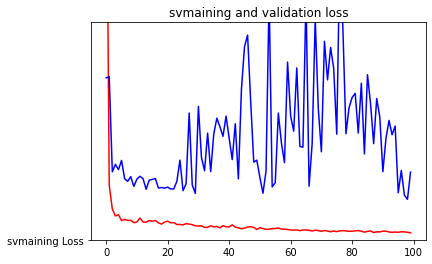

In [720]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_intc_svm=history_intc_svm.history['loss']
val_loss_intc_svm=history_intc_svm.history['val_loss']

epochs=range(len(loss_intc_svm)) 

plt.plot(epochs, loss_intc_svm, 'r', "svmaining Loss")
plt.plot(epochs, val_loss_intc_svm, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('svmaining and validation loss')

MSE: 0.023053571321886786  RMSE: 0.15183402557360715 R^2 score: 0.37445604929967014 MAPE: 0.10415344307598703


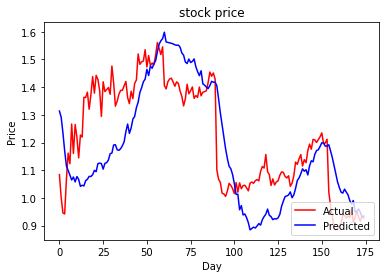

In [721]:
y_pred_intc_svm=making_y_pred(model_intc_svm,X_test_intc_svm)
mse_intc_svm,rmse_intc_svm,r_intc_svm,mape_intc_svm=Evalu(model_intc_svm,X_test_intc_svm,y_test_intc_svm,y_pred_intc_svm)
testset_plot(y_test_intc_svm,y_pred_intc_svm)

MSE: 0.0062206333277668655  RMSE: 0.07887099167480313 R^2 score: 0.6604437069422557 MAPE: 0.05398303592927095


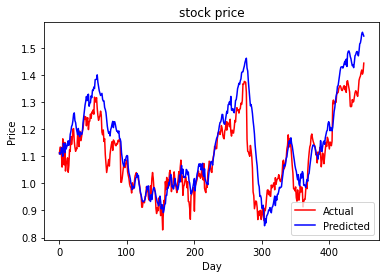

In [722]:
y_pred_intc_svm=making_y_pred(model_intc_svm,X_val_intc_svm)
mse_intc_svm,rmse_intc_svm,r_intc_svm,mape_intc_svm=Evalu(model_intc_svm,X_val_intc_svm,y_val_intc_svm,y_pred_intc_svm)
testset_plot(y_val_intc_svm,y_pred_intc_svm)

#### Conclusion

In [723]:
model_selection=pd.DataFrame(columns=(['10','50']),
                     index=(['Conv-LSTM','3CNN-LSTM-3DNN']))

In [726]:
model_selection.iloc[0,0]=(0.04486525068458911 +0.05594026756088599 +  0.03802490897457346)/3 
model_selection.iloc[0,1]=(0.06477279975730403 +0.04950708787245613 +0.07887099167480313) /3
model_selection.iloc[1,0]=(0.0835315867195118 +0.050871638761635064 +0.0779360479123375 )/3
model_selection.iloc[1,1]=(0.06243517515489207 +0.03893586598139669 +0.07402333374393476)/3 

In [727]:
model_selection

10         50
Conv-LSTM       0.0462768  0.0643836
3CNN-LSTM-3DNN  0.0707798  0.0584648

### MSFT

#### window_size 10

In [790]:
#Traning:2010-01-04 to 2018-01-03, Validation: 2018-01-04 to 2020-01-02, testing: 2019-12-02

df_msft_picked_tr = df_msft[['Close','Open','High','Low','Volume']] 
df_msft_picked_corr = df_msft[['Close','H-O','RSI','6 DAYS PSY','24 DAYS AR','Volume']] 
df_msft_picked_svm = df_msft[['Close','6 DAYS WMS','RSI','7 DAYS STD DEV']] 

windows_size=10

train_sc_tr,val_sc_tr,test_sc_tr=making_scaled_training_val_test_data(df_msft_picked_tr,6005,8020,8500,8730)
X_train_msft_tr,y_train_msft_tr,X_val_msft_tr,y_val_msft_tr=making_train_val(train_sc_tr,val_sc_tr,windows_size)
X_test_msft_tr,y_test_msft_tr=making_test(test_sc_tr,windows_size)

train_sc_corr,val_sc_corr,test_sc_corr=making_scaled_training_val_test_data(df_msft_picked_corr,6005,8020,8500,8730)
X_train_msft_corr,y_train_msft_corr,X_val_msft_corr,y_val_msft_corr=making_train_val(train_sc_corr,val_sc_corr,windows_size)
X_test_msft_corr,y_test_msft_corr=making_test(test_sc_corr,windows_size)

train_sc_svm,val_sc_svm,test_sc_svm=making_scaled_training_val_test_data(df_msft_picked_svm,6005,8020,8500,8730)
X_train_msft_svm,y_train_msft_svm,X_val_msft_svm,y_val_msft_svm=making_train_val(train_sc_svm,val_sc_svm,windows_size)
X_test_msft_svm,y_test_msft_svm=making_test(test_sc_svm,windows_size)

##### 3CNN+LSTM+3DNN

###### Traditional features

In [791]:
model_msft_tr = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(5,kernel_size=2,input_shape=(10,5)),
    tf.keras.layers.Conv1D(64,kernel_size=2),
    tf.keras.layers.Conv1D(128,kernel_size=2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1)
    
])
model_msft_tr.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_msft_tr = model_msft_tr.fit(X_train_msft_tr,y_train_msft_tr,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_msft_tr, y_val_msft_tr),verbose = 1)

Epoch 1/70
32/32 [==============================] - 2s 48ms/step - loss: 0.0092 - val_loss: 0.0826
Epoch 2/70
32/32 [==============================] - 0s 14ms/step - loss: 0.0011 - val_loss: 0.0286
Epoch 3/70
32/32 [==============================] - 0s 14ms/step - loss: 7.2702e-04 - val_loss: 0.0298
Epoch 4/70
32/32 [==============================] - 0s 14ms/step - loss: 7.0244e-04 - val_loss: 0.0098
Epoch 5/70
32/32 [==============================] - 0s 14ms/step - loss: 5.5992e-04 - val_loss: 0.0059
Epoch 6/70
32/32 [==============================] - 0s 14ms/step - loss: 5.2172e-04 - val_loss: 0.0164
Epoch 7/70
32/32 [==============================] - 0s 14ms/step - loss: 4.4576e-04 - val_loss: 0.0145
Epoch 8/70
32/32 [==============================] - 0s 14ms/step - loss: 5.1884e-04 - val_loss: 0.0072
Epoch 9/70
32/32 [==============================] - 0s 14ms/step - loss: 4.6844e-04 - val_loss: 0.0049
Epoch 10/70
32/32 [==============================] - 0s 14ms/step - loss: 5.5641e

In [792]:
model_msft_tr.summary()

Model: "sequential_171"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_263 (Conv1D)          (None, 9, 5)              55        
_________________________________________________________________
conv1d_264 (Conv1D)          (None, 8, 64)             704       
_________________________________________________________________
conv1d_265 (Conv1D)          (None, 7, 128)            16512     
_________________________________________________________________
bidirectional_277 (Bidirecti (None, 7, 80)             54080     
_________________________________________________________________
bidirectional_278 (Bidirecti (None, 7, 80)             38720     
_________________________________________________________________
lstm_480 (LSTM)              (None, 40)                19360     
_________________________________________________________________
dropout_158 (Dropout)        (None, 40)             

Text(0.5, 1.0, 'Training and validation loss')

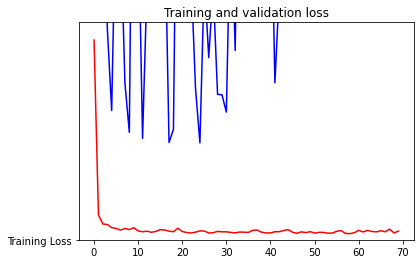

In [793]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_msft_tr=history_msft_tr.history['loss']
val_loss_msft_tr=history_msft_tr.history['val_loss']

epochs=range(len(loss_msft_tr)) 

plt.plot(epochs, loss_msft_tr, 'r', "Training Loss")
plt.plot(epochs, val_loss_msft_tr, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

MSE: 0.03731253328918415  RMSE: 0.19316452388879318 R^2 score: 0.48524551756585377 MAPE: 0.08548740181088213


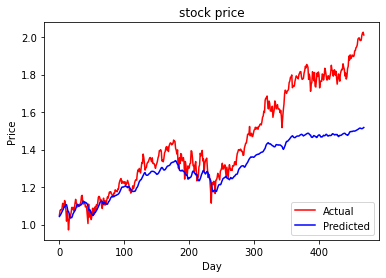

In [795]:
y_pred_msft_tr=making_y_pred(model_msft_tr,X_val_msft_tr)
mse_msft_tr,rmse_msft_tr,r_msft_tr,mape_msft_tr=Evalu(model_msft_tr,X_val_msft_tr,y_val_msft_tr,y_pred_msft_tr)
testset_plot(y_val_msft_tr,y_pred_msft_tr)

###### feature selection by correlation

In [796]:
model_msft_corr = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(6,kernel_size=2,input_shape=(10,6)),
    tf.keras.layers.Conv1D(64,kernel_size=2),
    tf.keras.layers.Conv1D(128,kernel_size=2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1)
    
])
model_msft_corr.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_msft_corr = model_msft_corr.fit(X_train_msft_corr,y_train_msft_corr,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_msft_corr, y_val_msft_corr),verbose = 1)

Epoch 1/70
32/32 [==============================] - 2s 48ms/step - loss: 0.0134 - val_loss: 0.0283
Epoch 2/70
32/32 [==============================] - 0s 14ms/step - loss: 0.0016 - val_loss: 0.0459
Epoch 3/70
32/32 [==============================] - 0s 14ms/step - loss: 9.8759e-04 - val_loss: 0.0237
Epoch 4/70
32/32 [==============================] - 0s 13ms/step - loss: 7.7843e-04 - val_loss: 0.0400
Epoch 5/70
32/32 [==============================] - 0s 13ms/step - loss: 9.6020e-04 - val_loss: 0.0129
Epoch 6/70
32/32 [==============================] - 0s 14ms/step - loss: 6.3841e-04 - val_loss: 0.0195
Epoch 7/70
32/32 [==============================] - 0s 13ms/step - loss: 4.9776e-04 - val_loss: 0.0176
Epoch 8/70
32/32 [==============================] - 0s 13ms/step - loss: 4.3183e-04 - val_loss: 0.0287
Epoch 9/70
32/32 [==============================] - 0s 13ms/step - loss: 5.9486e-04 - val_loss: 0.0161
Epoch 10/70
32/32 [==============================] - 0s 13ms/step - loss: 4.4176e

Text(0.5, 1.0, 'corraining and validation loss')

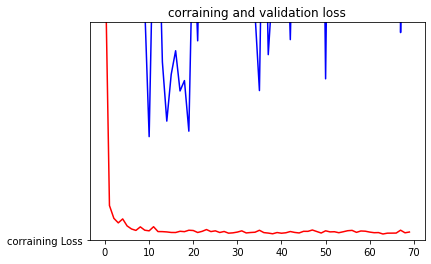

In [797]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_msft_corr=history_msft_corr.history['loss']
val_loss_msft_corr=history_msft_corr.history['val_loss']

epochs=range(len(loss_msft_corr)) 

plt.plot(epochs, loss_msft_corr, 'r', "corraining Loss")
plt.plot(epochs, val_loss_msft_corr, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('corraining and validation loss')

MSE: 0.06958068760586424  RMSE: 0.26378151490554497 R^2 score: 0.04008204003797855 MAPE: 0.14615003495708762


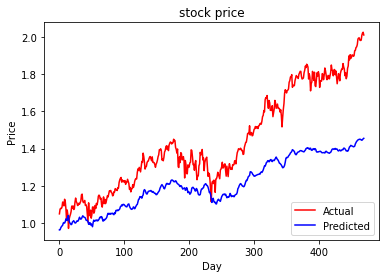

In [799]:
y_pred_msft_corr=making_y_pred(model_msft_corr,X_val_msft_corr)
mse_msft_corr,rmse_msft_corr,r_msft_corr,mape_msft_corr=Evalu(model_msft_corr,X_val_msft_corr,y_val_msft_corr,y_pred_msft_corr)
testset_plot(y_val_msft_corr,y_pred_msft_corr)

###### feature selection by svm-rfe

In [800]:
model_msft_svm = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(4,kernel_size=2,input_shape=(10,4)),
    tf.keras.layers.Conv1D(64,kernel_size=2),
    tf.keras.layers.Conv1D(128,kernel_size=2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1)
    
])
model_msft_svm.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_msft_svm = model_msft_svm.fit(X_train_msft_svm,y_train_msft_svm,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_msft_svm, y_val_msft_svm),verbose = 1)

Epoch 1/70
32/32 [==============================] - 2s 48ms/step - loss: 0.0106 - val_loss: 0.0527
Epoch 2/70
32/32 [==============================] - 0s 14ms/step - loss: 0.0011 - val_loss: 0.0347
Epoch 3/70
32/32 [==============================] - 0s 13ms/step - loss: 6.6843e-04 - val_loss: 0.0319
Epoch 4/70
32/32 [==============================] - 0s 13ms/step - loss: 5.6556e-04 - val_loss: 0.0175
Epoch 5/70
32/32 [==============================] - 0s 13ms/step - loss: 5.1911e-04 - val_loss: 0.0188
Epoch 6/70
32/32 [==============================] - 0s 13ms/step - loss: 5.1217e-04 - val_loss: 0.0098
Epoch 7/70
32/32 [==============================] - 0s 13ms/step - loss: 5.3330e-04 - val_loss: 0.0109
Epoch 8/70
32/32 [==============================] - 0s 13ms/step - loss: 3.7518e-04 - val_loss: 0.0065
Epoch 9/70
32/32 [==============================] - 0s 13ms/step - loss: 5.1894e-04 - val_loss: 0.0297
Epoch 10/70
32/32 [==============================] - 0s 13ms/step - loss: 4.9300e

Text(0.5, 1.0, 'svmaining and validation loss')

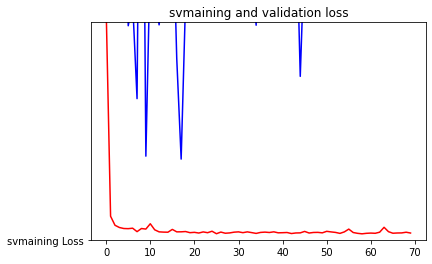

In [801]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_msft_svm=history_msft_svm.history['loss']
val_loss_msft_svm=history_msft_svm.history['val_loss']

epochs=range(len(loss_msft_svm)) 

plt.plot(epochs, loss_msft_svm, 'r', "svmaining Loss")
plt.plot(epochs, val_loss_msft_svm, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('svmaining and validation loss')

MSE: 0.06192042435905192  RMSE: 0.24883814892225012 R^2 score: 0.14576113752410924 MAPE: 0.13037985121785028


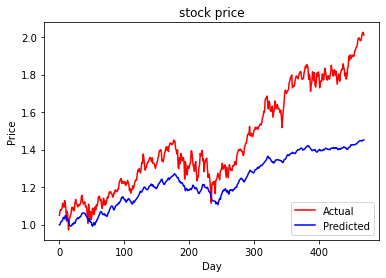

In [803]:
y_pred_msft_svm=making_y_pred(model_msft_svm,X_val_msft_svm)
mse_msft_svm,rmse_msft_svm,r_msft_svm,mape_msft_svm=Evalu(model_msft_svm,X_val_msft_svm,y_val_msft_svm,y_pred_msft_svm)
testset_plot(y_val_msft_svm,y_pred_msft_svm)

##### Conv1d+LSTM

###### Traditional features

In [804]:
model_msft_tr = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(5,kernel_size=2,input_shape=(10,5)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_msft_tr.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_msft_tr = model_msft_tr.fit(X_train_msft_tr,y_train_msft_tr,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_msft_tr, y_val_msft_tr),verbose = 1)

Epoch 1/70
32/32 [==============================] - 2s 51ms/step - loss: 0.0105 - val_loss: 0.0044
Epoch 2/70
32/32 [==============================] - 1s 17ms/step - loss: 0.0012 - val_loss: 0.0089
Epoch 3/70
32/32 [==============================] - 1s 17ms/step - loss: 8.8108e-04 - val_loss: 0.0102
Epoch 4/70
32/32 [==============================] - 1s 17ms/step - loss: 7.7121e-04 - val_loss: 0.0041
Epoch 5/70
32/32 [==============================] - 1s 17ms/step - loss: 7.9434e-04 - val_loss: 0.0034
Epoch 6/70
32/32 [==============================] - 1s 17ms/step - loss: 6.6529e-04 - val_loss: 0.0041
Epoch 7/70
32/32 [==============================] - 1s 17ms/step - loss: 7.2943e-04 - val_loss: 0.0023
Epoch 8/70
32/32 [==============================] - 1s 16ms/step - loss: 6.5579e-04 - val_loss: 0.0087
Epoch 9/70
32/32 [==============================] - 1s 17ms/step - loss: 6.5692e-04 - val_loss: 0.0086
Epoch 10/70
32/32 [==============================] - 1s 17ms/step - loss: 6.4342e

In [805]:
model_msft_tr.summary()

Model: "sequential_174"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_272 (Conv1D)          (None, 9, 5)              55        
_________________________________________________________________
bidirectional_283 (Bidirecti (None, 9, 80)             14720     
_________________________________________________________________
bidirectional_284 (Bidirecti (None, 9, 80)             38720     
_________________________________________________________________
lstm_489 (LSTM)              (None, 40)                19360     
_________________________________________________________________
dropout_161 (Dropout)        (None, 40)                0         
_________________________________________________________________
dense_301 (Dense)            (None, 1)                 41        
Total params: 72,896
Trainable params: 72,896
Non-trainable params: 0
________________________________________________

Text(0.5, 1.0, 'Training and validation loss')

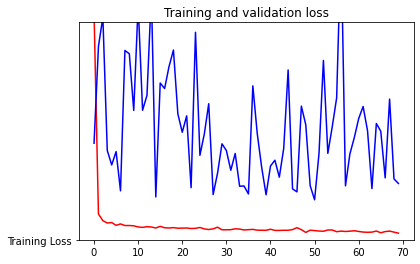

In [806]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_msft_tr=history_msft_tr.history['loss']
val_loss_msft_tr=history_msft_tr.history['val_loss']

epochs=range(len(loss_msft_tr)) 

plt.plot(epochs, loss_msft_tr, 'r', "Training Loss")
plt.plot(epochs, val_loss_msft_tr, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

MSE: 0.005180221133872487  RMSE: 0.07197375309008477 R^2 score: 0.9285349502271958 MAPE: 0.03414067117847094


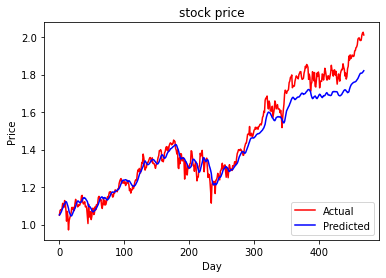

In [808]:
y_pred_msft_tr=making_y_pred(model_msft_tr,X_val_msft_tr)
mse_msft_tr,rmse_msft_tr,r_msft_tr,mape_msft_tr=Evalu(model_msft_tr,X_val_msft_tr,y_val_msft_tr,y_pred_msft_tr)
testset_plot(y_val_msft_tr,y_pred_msft_tr)

###### feature selection by correlation

In [809]:
model_msft_corr = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(6,kernel_size=2,input_shape=(10,6)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_msft_corr.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_msft_corr = model_msft_corr.fit(X_train_msft_corr,y_train_msft_corr,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_msft_corr, y_val_msft_corr),verbose = 1)

Epoch 1/70
32/32 [==============================] - 2s 50ms/step - loss: 0.0126 - val_loss: 0.0026
Epoch 2/70
32/32 [==============================] - 1s 16ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 3/70
32/32 [==============================] - 1s 16ms/step - loss: 9.4558e-04 - val_loss: 0.0015
Epoch 4/70
32/32 [==============================] - 1s 16ms/step - loss: 9.0452e-04 - val_loss: 0.0014
Epoch 5/70
32/32 [==============================] - 1s 16ms/step - loss: 8.7968e-04 - val_loss: 0.0017
Epoch 6/70
32/32 [==============================] - 1s 16ms/step - loss: 6.5487e-04 - val_loss: 0.0011
Epoch 7/70
32/32 [==============================] - 1s 16ms/step - loss: 6.4636e-04 - val_loss: 0.0028
Epoch 8/70
32/32 [==============================] - 1s 16ms/step - loss: 6.8489e-04 - val_loss: 0.0017
Epoch 9/70
32/32 [==============================] - 0s 15ms/step - loss: 6.5962e-04 - val_loss: 0.0055
Epoch 10/70
32/32 [==============================] - 0s 16ms/step - loss: 6.6945e

Text(0.5, 1.0, 'corraining and validation loss')

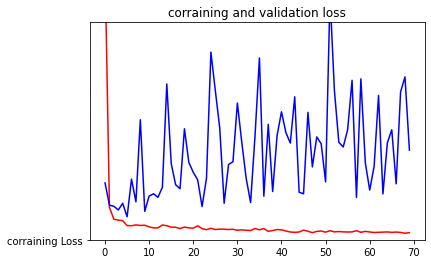

In [810]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_msft_corr=history_msft_corr.history['loss']
val_loss_msft_corr=history_msft_corr.history['val_loss']

epochs=range(len(loss_msft_corr)) 

plt.plot(epochs, loss_msft_corr, 'r', "corraining Loss")
plt.plot(epochs, val_loss_msft_corr, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('corraining and validation loss')

MSE: 0.008251685433208584  RMSE: 0.09083878815356677 R^2 score: 0.8861617882800811 MAPE: 0.04181510624906862


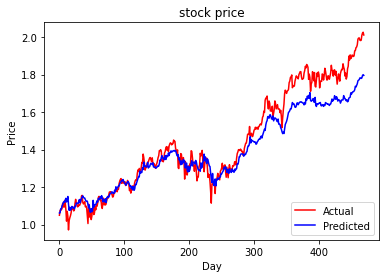

In [812]:
y_pred_msft_corr=making_y_pred(model_msft_corr,X_val_msft_corr)
mse_msft_corr,rmse_msft_corr,r_msft_corr,mape_msft_corr=Evalu(model_msft_corr,X_val_msft_corr,y_val_msft_corr,y_pred_msft_corr)
testset_plot(y_val_msft_corr,y_pred_msft_corr)

###### feature selection by svm-rfe

In [813]:
model_msft_svm = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(4,kernel_size=2,input_shape=(10,4)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_msft_svm.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_msft_svm = model_msft_svm.fit(X_train_msft_svm,y_train_msft_svm,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_msft_svm, y_val_msft_svm),verbose = 1)

Epoch 1/70
32/32 [==============================] - 2s 49ms/step - loss: 0.0197 - val_loss: 0.0133
Epoch 2/70
32/32 [==============================] - 0s 15ms/step - loss: 0.0024 - val_loss: 0.0038
Epoch 3/70
32/32 [==============================] - 0s 15ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 4/70
32/32 [==============================] - 0s 15ms/step - loss: 8.9743e-04 - val_loss: 0.0034
Epoch 5/70
32/32 [==============================] - 0s 15ms/step - loss: 6.9192e-04 - val_loss: 0.0054
Epoch 6/70
32/32 [==============================] - 0s 15ms/step - loss: 7.1518e-04 - val_loss: 0.0015
Epoch 7/70
32/32 [==============================] - 0s 15ms/step - loss: 6.6730e-04 - val_loss: 0.0049
Epoch 8/70
32/32 [==============================] - 0s 14ms/step - loss: 6.2489e-04 - val_loss: 0.0020
Epoch 9/70
32/32 [==============================] - 0s 15ms/step - loss: 6.2206e-04 - val_loss: 0.0015
Epoch 10/70
32/32 [==============================] - 0s 14ms/step - loss: 6.1190e-04 

Text(0.5, 1.0, 'svmaining and validation loss')

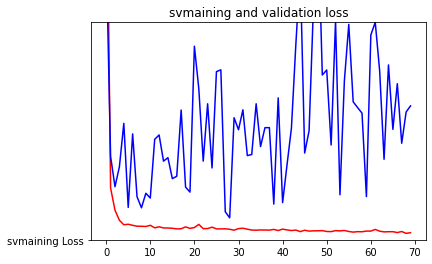

In [814]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_msft_svm=history_msft_svm.history['loss']
val_loss_msft_svm=history_msft_svm.history['val_loss']

epochs=range(len(loss_msft_svm)) 

plt.plot(epochs, loss_msft_svm, 'r', "svmaining Loss")
plt.plot(epochs, val_loss_msft_svm, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('svmaining and validation loss')

MSE: 0.012320186297490276  RMSE: 0.11099633461286132 R^2 score: 0.830033756434994 MAPE: 0.05775200060038441


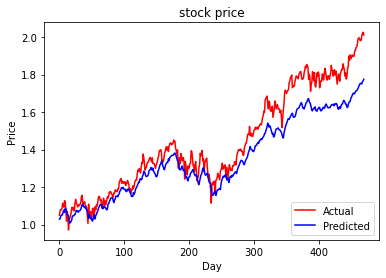

In [816]:
y_pred_msft_svm=making_y_pred(model_msft_svm,X_val_msft_svm)
mse_msft_svm,rmse_msft_svm,r_msft_svm,mape_msft_svm=Evalu(model_msft_svm,X_val_msft_svm,y_val_msft_svm,y_pred_msft_svm)
testset_plot(y_val_msft_svm,y_pred_msft_svm)

#### window_size 50

In [817]:
#Traning:2010-01-04 to 2018-01-03, Validation: 2018-01-04 to 2020-01-02, testing: 2020-01-03

df_msft_picked_tr = df_msft[['Close','Open','High','Low','Volume']] 
df_msft_picked_corr = df_msft[['Close','H-O','RSI','6 DAYS PSY','24 DAYS AR','Volume']] 
df_msft_picked_svm = df_msft[['Close','6 DAYS WMS','RSI','7 DAYS STD DEV']] 

windows_size=50

train_sc_tr,val_sc_tr,test_sc_tr=making_scaled_training_val_test_data(df_msft_picked_tr,6005,8020,8500,8739)
X_train_msft_tr,y_train_msft_tr,X_val_msft_tr,y_val_msft_tr=making_train_val(train_sc_tr,val_sc_tr,windows_size)
X_test_msft_tr,y_test_msft_tr=making_test(test_sc_tr,windows_size)

train_sc_corr,val_sc_corr,test_sc_corr=making_scaled_training_val_test_data(df_msft_picked_corr,6005,8020,8500,8739)
X_train_msft_corr,y_train_msft_corr,X_val_msft_corr,y_val_msft_corr=making_train_val(train_sc_corr,val_sc_corr,windows_size)
X_test_msft_corr,y_test_msft_corr=making_test(test_sc_corr,windows_size)

train_sc_svm,val_sc_svm,test_sc_svm=making_scaled_training_val_test_data(df_msft_picked_svm,6005,8020,8500,8739)
X_train_msft_svm,y_train_msft_svm,X_val_msft_svm,y_val_msft_svm=making_train_val(train_sc_svm,val_sc_svm,windows_size)
X_test_msft_svm,y_test_msft_svm=making_test(test_sc_svm,windows_size)

##### 3CNN+LSTM+3DNN

###### Traditional features

In [818]:
model_msft_tr = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(5,kernel_size=2,input_shape=(50,5)),
    tf.keras.layers.Conv1D(64,kernel_size=2),
    tf.keras.layers.Conv1D(128,kernel_size=2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1)
    
])
model_msft_tr.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_msft_tr = model_msft_tr.fit(X_train_msft_tr,y_train_msft_tr,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_msft_tr, y_val_msft_tr),verbose = 1)

Epoch 1/70
31/31 [==============================] - 3s 103ms/step - loss: 0.0076 - val_loss: 0.1990
Epoch 2/70
31/31 [==============================] - 2s 66ms/step - loss: 0.0011 - val_loss: 0.0895
Epoch 3/70
31/31 [==============================] - 2s 66ms/step - loss: 7.7237e-04 - val_loss: 0.0547
Epoch 4/70
31/31 [==============================] - 2s 66ms/step - loss: 5.9110e-04 - val_loss: 0.0451
Epoch 5/70
31/31 [==============================] - 2s 67ms/step - loss: 6.1181e-04 - val_loss: 0.0288
Epoch 6/70
31/31 [==============================] - 2s 66ms/step - loss: 5.8636e-04 - val_loss: 0.0364
Epoch 7/70
31/31 [==============================] - 2s 66ms/step - loss: 5.5644e-04 - val_loss: 0.0272
Epoch 8/70
31/31 [==============================] - 2s 66ms/step - loss: 5.0476e-04 - val_loss: 0.0238
Epoch 9/70
31/31 [==============================] - 2s 66ms/step - loss: 5.2119e-04 - val_loss: 0.0191
Epoch 10/70
31/31 [==============================] - 2s 66ms/step - loss: 4.8696

In [819]:
model_msft_tr.summary()

Model: "sequential_177"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_275 (Conv1D)          (None, 49, 5)             55        
_________________________________________________________________
conv1d_276 (Conv1D)          (None, 48, 64)            704       
_________________________________________________________________
conv1d_277 (Conv1D)          (None, 47, 128)           16512     
_________________________________________________________________
bidirectional_289 (Bidirecti (None, 47, 80)            54080     
_________________________________________________________________
bidirectional_290 (Bidirecti (None, 47, 80)            38720     
_________________________________________________________________
lstm_498 (LSTM)              (None, 40)                19360     
_________________________________________________________________
dropout_164 (Dropout)        (None, 40)             

Text(0.5, 1.0, 'Training and validation loss')

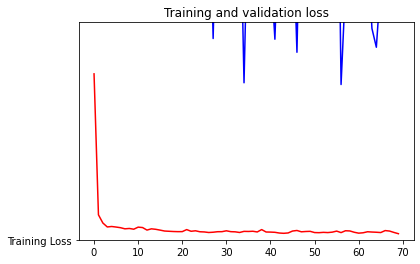

In [820]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_msft_tr=history_msft_tr.history['loss']
val_loss_msft_tr=history_msft_tr.history['val_loss']

epochs=range(len(loss_msft_tr)) 

plt.plot(epochs, loss_msft_tr, 'r', "Training Loss")
plt.plot(epochs, val_loss_msft_tr, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

MSE: 0.04105578136936137  RMSE: 0.2026222627683379 R^2 score: 0.3854506803632286 MAPE: 0.10266784567810888


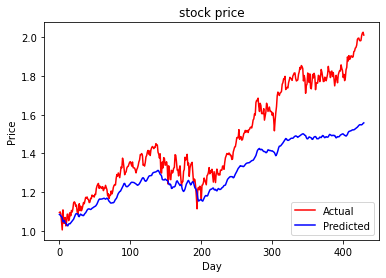

In [821]:
y_pred_msft_tr=making_y_pred(model_msft_tr,X_val_msft_tr)
mse_msft_tr,rmse_msft_tr,r_msft_tr,mape_msft_tr=Evalu(model_msft_tr,X_val_msft_tr,y_val_msft_tr,y_pred_msft_tr)
testset_plot(y_val_msft_tr,y_pred_msft_tr)

###### feature selection by correlation

In [822]:
model_msft_corr = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(6,kernel_size=2,input_shape=(50,6)),
    tf.keras.layers.Conv1D(64,kernel_size=2),
    tf.keras.layers.Conv1D(128,kernel_size=2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1)
    
])
model_msft_corr.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_msft_corr = model_msft_corr.fit(X_train_msft_corr,y_train_msft_corr,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_msft_corr, y_val_msft_corr),verbose = 1)

Epoch 1/70
31/31 [==============================] - 3s 102ms/step - loss: 0.0081 - val_loss: 0.0848
Epoch 2/70
31/31 [==============================] - 2s 65ms/step - loss: 0.0015 - val_loss: 0.0688
Epoch 3/70
31/31 [==============================] - 2s 66ms/step - loss: 6.1358e-04 - val_loss: 0.0374
Epoch 4/70
31/31 [==============================] - 2s 65ms/step - loss: 5.8466e-04 - val_loss: 0.0362
Epoch 5/70
31/31 [==============================] - 2s 65ms/step - loss: 5.1632e-04 - val_loss: 0.0241
Epoch 6/70
31/31 [==============================] - 2s 66ms/step - loss: 4.6274e-04 - val_loss: 0.0182
Epoch 7/70
31/31 [==============================] - 2s 64ms/step - loss: 5.5069e-04 - val_loss: 0.0215
Epoch 8/70
31/31 [==============================] - 2s 65ms/step - loss: 4.8244e-04 - val_loss: 0.0188
Epoch 9/70
31/31 [==============================] - 2s 65ms/step - loss: 5.2424e-04 - val_loss: 0.0183
Epoch 10/70
31/31 [==============================] - 2s 66ms/step - loss: 5.0274

Text(0.5, 1.0, 'corraining and validation loss')

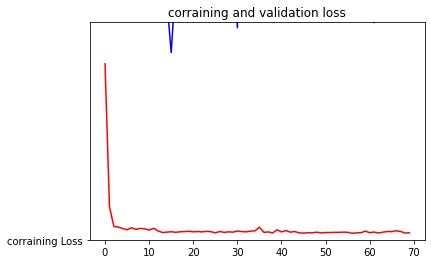

In [823]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_msft_corr=history_msft_corr.history['loss']
val_loss_msft_corr=history_msft_corr.history['val_loss']

epochs=range(len(loss_msft_corr)) 

plt.plot(epochs, loss_msft_corr, 'r', "corraining Loss")
plt.plot(epochs, val_loss_msft_corr, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('corraining and validation loss')

MSE: 0.053436152578611285  RMSE: 0.23116261068479757 R^2 score: 0.20013332797755268 MAPE: 0.12074202344900666


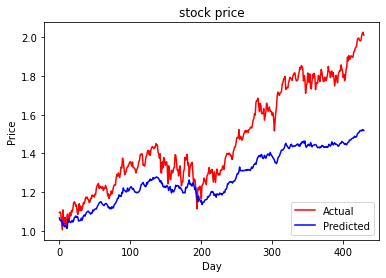

In [824]:
y_pred_msft_corr=making_y_pred(model_msft_corr,X_val_msft_corr)
mse_msft_corr,rmse_msft_corr,r_msft_corr,mape_msft_corr=Evalu(model_msft_corr,X_val_msft_corr,y_val_msft_corr,y_pred_msft_corr)
testset_plot(y_val_msft_corr,y_pred_msft_corr)

###### feature selection by svm-rfe

In [825]:
model_msft_svm = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(4,kernel_size=2,input_shape=(50,4)),
    tf.keras.layers.Conv1D(64,kernel_size=2),
    tf.keras.layers.Conv1D(128,kernel_size=2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1)
    
])
model_msft_svm.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_msft_svm = model_msft_svm.fit(X_train_msft_svm,y_train_msft_svm,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_msft_svm, y_val_msft_svm),verbose = 1)

Epoch 1/70
31/31 [==============================] - 3s 102ms/step - loss: 0.0082 - val_loss: 0.1173
Epoch 2/70
31/31 [==============================] - 2s 65ms/step - loss: 0.0013 - val_loss: 0.1139
Epoch 3/70
31/31 [==============================] - 2s 64ms/step - loss: 7.5969e-04 - val_loss: 0.0619
Epoch 4/70
31/31 [==============================] - 2s 64ms/step - loss: 6.9870e-04 - val_loss: 0.0732
Epoch 5/70
31/31 [==============================] - 2s 64ms/step - loss: 5.6721e-04 - val_loss: 0.0443
Epoch 6/70
31/31 [==============================] - 2s 64ms/step - loss: 6.5509e-04 - val_loss: 0.0539
Epoch 7/70
31/31 [==============================] - 2s 64ms/step - loss: 5.2642e-04 - val_loss: 0.0309
Epoch 8/70
31/31 [==============================] - 2s 64ms/step - loss: 4.7513e-04 - val_loss: 0.0265
Epoch 9/70
31/31 [==============================] - 2s 64ms/step - loss: 4.8367e-04 - val_loss: 0.0263
Epoch 10/70
31/31 [==============================] - 2s 65ms/step - loss: 4.0140

Text(0.5, 1.0, 'svmaining and validation loss')

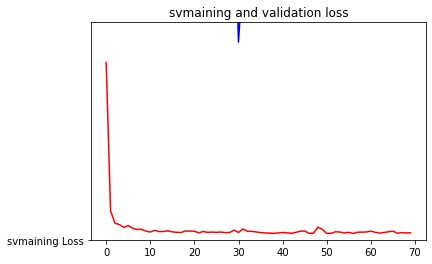

In [826]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_msft_svm=history_msft_svm.history['loss']
val_loss_msft_svm=history_msft_svm.history['val_loss']

epochs=range(len(loss_msft_svm)) 

plt.plot(epochs, loss_msft_svm, 'r', "svmaining Loss")
plt.plot(epochs, val_loss_msft_svm, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('svmaining and validation loss')

MSE: 0.10409929861838896  RMSE: 0.322644229172612 R^2 score: -0.5582252001258443 MAPE: 0.12870448215225896


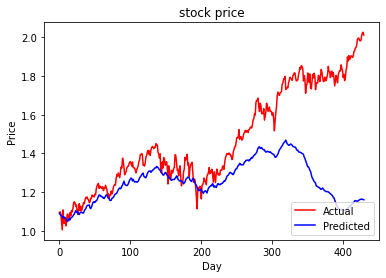

In [827]:
y_pred_msft_svm=making_y_pred(model_msft_svm,X_val_msft_svm)
mse_msft_svm,rmse_msft_svm,r_msft_svm,mape_msft_svm=Evalu(model_msft_svm,X_val_msft_svm,y_val_msft_svm,y_pred_msft_svm)
testset_plot(y_val_msft_svm,y_pred_msft_svm)

##### Conv1d+LSTM

###### Traditional features

In [828]:
model_msft_tr = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(5,kernel_size=2,input_shape=(50,5)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_msft_tr.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_msft_tr = model_msft_tr.fit(X_train_msft_tr,y_train_msft_tr,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_msft_tr, y_val_msft_tr),verbose = 1)

Epoch 1/70
31/31 [==============================] - 3s 93ms/step - loss: 0.0101 - val_loss: 0.0735
Epoch 2/70
31/31 [==============================] - 2s 58ms/step - loss: 0.0015 - val_loss: 0.0279
Epoch 3/70
31/31 [==============================] - 2s 58ms/step - loss: 9.3496e-04 - val_loss: 0.0184
Epoch 4/70
31/31 [==============================] - 2s 58ms/step - loss: 9.2535e-04 - val_loss: 0.0148
Epoch 5/70
31/31 [==============================] - 2s 58ms/step - loss: 8.9356e-04 - val_loss: 0.0025
Epoch 6/70
31/31 [==============================] - 2s 58ms/step - loss: 8.8011e-04 - val_loss: 0.0145
Epoch 7/70
31/31 [==============================] - 2s 58ms/step - loss: 7.6040e-04 - val_loss: 0.0112
Epoch 8/70
31/31 [==============================] - 2s 58ms/step - loss: 7.4371e-04 - val_loss: 0.0099
Epoch 9/70
31/31 [==============================] - 2s 58ms/step - loss: 6.9529e-04 - val_loss: 0.0119
Epoch 10/70
31/31 [==============================] - 2s 57ms/step - loss: 7.4743e

In [829]:
model_msft_tr.summary()

Model: "sequential_180"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_284 (Conv1D)          (None, 49, 5)             55        
_________________________________________________________________
bidirectional_295 (Bidirecti (None, 49, 80)            14720     
_________________________________________________________________
bidirectional_296 (Bidirecti (None, 49, 80)            38720     
_________________________________________________________________
lstm_507 (LSTM)              (None, 40)                19360     
_________________________________________________________________
dropout_167 (Dropout)        (None, 40)                0         
_________________________________________________________________
dense_313 (Dense)            (None, 1)                 41        
Total params: 72,896
Trainable params: 72,896
Non-trainable params: 0
________________________________________________

Text(0.5, 1.0, 'Training and validation loss')

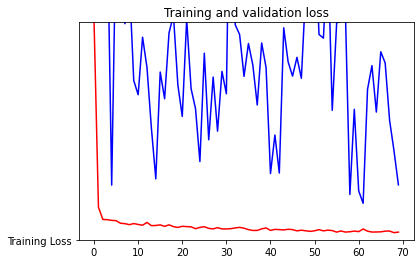

In [830]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_msft_tr=history_msft_tr.history['loss']
val_loss_msft_tr=history_msft_tr.history['val_loss']

epochs=range(len(loss_msft_tr)) 

plt.plot(epochs, loss_msft_tr, 'r', "Training Loss")
plt.plot(epochs, val_loss_msft_tr, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

MSE: 0.005054297624647446  RMSE: 0.07109358356875427 R^2 score: 0.9243440250588719 MAPE: 0.03370493688603967


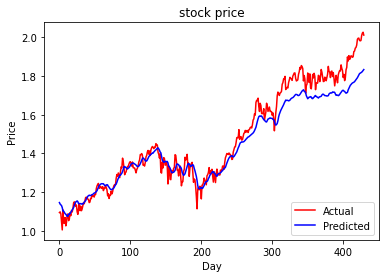

In [832]:
y_pred_msft_tr=making_y_pred(model_msft_tr,X_val_msft_tr)
mse_msft_tr,rmse_msft_tr,r_msft_tr,mape_msft_tr=Evalu(model_msft_tr,X_val_msft_tr,y_val_msft_tr,y_pred_msft_tr)
testset_plot(y_val_msft_tr,y_pred_msft_tr)

###### feature selection by correlation

In [833]:
model_msft_corr = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(6,kernel_size=2,input_shape=(50,6)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_msft_corr.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_msft_corr = model_msft_corr.fit(X_train_msft_corr,y_train_msft_corr,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_msft_corr, y_val_msft_corr),verbose = 1)

Epoch 1/70
31/31 [==============================] - 3s 107ms/step - loss: 0.0130 - val_loss: 0.0081
Epoch 2/70
31/31 [==============================] - 2s 72ms/step - loss: 0.0021 - val_loss: 0.0062
Epoch 3/70
31/31 [==============================] - 2s 72ms/step - loss: 0.0015 - val_loss: 0.0109
Epoch 4/70
31/31 [==============================] - 2s 72ms/step - loss: 0.0012 - val_loss: 0.0059
Epoch 5/70
31/31 [==============================] - 2s 71ms/step - loss: 0.0010 - val_loss: 0.0094
Epoch 6/70
31/31 [==============================] - 2s 71ms/step - loss: 8.7800e-04 - val_loss: 0.0210
Epoch 7/70
31/31 [==============================] - 2s 72ms/step - loss: 8.1420e-04 - val_loss: 0.0150
Epoch 8/70
31/31 [==============================] - 2s 71ms/step - loss: 8.4040e-04 - val_loss: 0.0172
Epoch 9/70
31/31 [==============================] - 2s 71ms/step - loss: 8.4158e-04 - val_loss: 0.0198
Epoch 10/70
31/31 [==============================] - 2s 72ms/step - loss: 7.8503e-04 - val_l

Text(0.5, 1.0, 'corraining and validation loss')

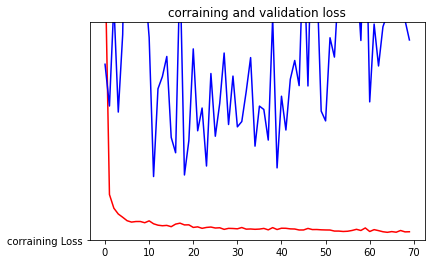

In [834]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_msft_corr=history_msft_corr.history['loss']
val_loss_msft_corr=history_msft_corr.history['val_loss']

epochs=range(len(loss_msft_corr)) 

plt.plot(epochs, loss_msft_corr, 'r', "corraining Loss")
plt.plot(epochs, val_loss_msft_corr, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('corraining and validation loss')

MSE: 0.01838156139024175  RMSE: 0.13557861700962195 R^2 score: 0.7248529763785048 MAPE: 0.06379265980285823


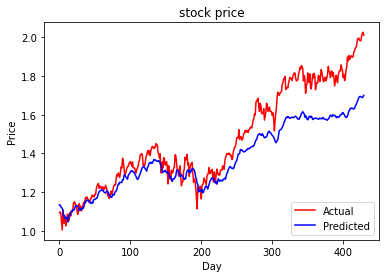

In [835]:
y_pred_msft_corr=making_y_pred(model_msft_corr,X_val_msft_corr)
mse_msft_corr,rmse_msft_corr,r_msft_corr,mape_msft_corr=Evalu(model_msft_corr,X_val_msft_corr,y_val_msft_corr,y_pred_msft_corr)
testset_plot(y_val_msft_corr,y_pred_msft_corr)

###### feature selection by svm-rfe

In [836]:
model_msft_svm = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(4,kernel_size=1,input_shape=(50,4)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_msft_svm.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_msft_svm = model_msft_svm.fit(X_train_msft_svm,y_train_msft_svm,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_msft_svm, y_val_msft_svm),verbose = 1)

Epoch 1/70
31/31 [==============================] - 3s 101ms/step - loss: 0.0190 - val_loss: 0.0331
Epoch 2/70
31/31 [==============================] - 2s 66ms/step - loss: 0.0021 - val_loss: 0.0120
Epoch 3/70
31/31 [==============================] - 2s 66ms/step - loss: 0.0011 - val_loss: 0.0214
Epoch 4/70
31/31 [==============================] - 2s 66ms/step - loss: 9.1649e-04 - val_loss: 0.0253
Epoch 5/70
31/31 [==============================] - 2s 66ms/step - loss: 8.8340e-04 - val_loss: 0.0180
Epoch 6/70
31/31 [==============================] - 2s 66ms/step - loss: 6.9171e-04 - val_loss: 0.0201
Epoch 7/70
31/31 [==============================] - 2s 66ms/step - loss: 7.7254e-04 - val_loss: 0.0211
Epoch 8/70
31/31 [==============================] - 2s 66ms/step - loss: 7.8112e-04 - val_loss: 0.0214
Epoch 9/70
31/31 [==============================] - 2s 66ms/step - loss: 6.9936e-04 - val_loss: 0.0204
Epoch 10/70
31/31 [==============================] - 2s 66ms/step - loss: 6.6597e-04

Text(0.5, 1.0, 'svmaining and validation loss')

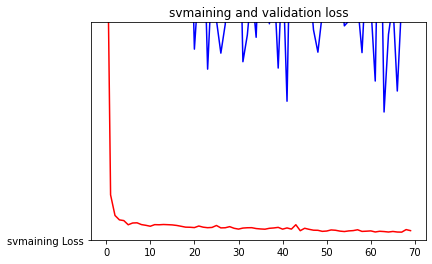

In [837]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_msft_svm=history_msft_svm.history['loss']
val_loss_msft_svm=history_msft_svm.history['val_loss']

epochs=range(len(loss_msft_svm)) 

plt.plot(epochs, loss_msft_svm, 'r', "svmaining Loss")
plt.plot(epochs, val_loss_msft_svm, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('svmaining and validation loss')

MSE: 0.026491896622150755  RMSE: 0.1627633147307794 R^2 score: 0.6034522665989226 MAPE: 0.08903879627583919


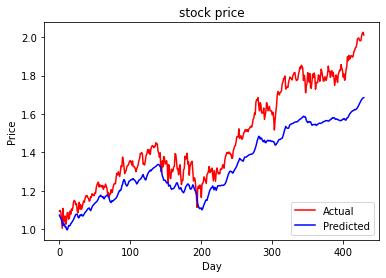

In [839]:
y_pred_msft_svm=making_y_pred(model_msft_svm,X_val_msft_svm)
mse_msft_svm,rmse_msft_svm,r_msft_svm,mape_msft_svm=Evalu(model_msft_svm,X_val_msft_svm,y_val_msft_svm,y_pred_msft_svm)
testset_plot(y_val_msft_svm,y_pred_msft_svm)

#### Conclusion

In [895]:
model_selection=pd.DataFrame(columns=(['10','50']),
                     index=(['Conv-LSTM','3CNN-LSTM-3DNN']))

In [896]:
model_selection.iloc[0,0]=(0.07197375309008477  +0.07197375309008477  +  0.11099633461286132 )/3 
model_selection.iloc[0,1]=(0.1627633147307794  +0.13557861700962195  +0.07109358356875427 ) /3
model_selection.iloc[1,0]=(0.19316452388879318  +0.26378151490554497  +0.24883814892225012  )/3
model_selection.iloc[1,1]=(0.322644229172612  +0.23116261068479757  +0.2026222627683379 )/3 

In [897]:
model_selection

10        50
Conv-LSTM       0.0849813  0.123145
3CNN-LSTM-3DNN   0.235261  0.252143

### NVDA

#### window_size 10

In [840]:
#Traning:2010-01-04 to 2018-01-03, Validation: 2018-01-04 to 2020-01-02, testing: 2019-09-20

df_nvda_picked_tr = df_nvda[['Close','Open','High','Low','Volume']] 
df_nvda_picked_corr = df_nvda[['Close','H-L','7 DAYS STD DEV','RSI','MACD']] 
df_nvda_picked_svm = df_nvda[['Close','6 DAYS WMS','MACD','20 DAYS EMA']] 

windows_size=10

train_sc_tr,val_sc_tr,test_sc_tr=making_scaled_training_val_test_data(df_nvda_picked_tr,2755,4770,5200,5495)
X_train_nvda_tr,y_train_nvda_tr,X_val_nvda_tr,y_val_nvda_tr=making_train_val(train_sc_tr,val_sc_tr,windows_size)
X_test_nvda_tr,y_test_nvda_tr=making_test(test_sc_tr,windows_size)

train_sc_corr,val_sc_corr,test_sc_corr=making_scaled_training_val_test_data(df_nvda_picked_corr,2755,4770,5200,5495)
X_train_nvda_corr,y_train_nvda_corr,X_val_nvda_corr,y_val_nvda_corr=making_train_val(train_sc_corr,val_sc_corr,windows_size)
X_test_nvda_corr,y_test_nvda_corr=making_test(test_sc_corr,windows_size)

train_sc_svm,val_sc_svm,test_sc_svm=making_scaled_training_val_test_data(df_nvda_picked_svm,2755,4770,5200,5495)
X_train_nvda_svm,y_train_nvda_svm,X_val_nvda_svm,y_val_nvda_svm=making_train_val(train_sc_svm,val_sc_svm,windows_size)
X_test_nvda_svm,y_test_nvda_svm=making_test(test_sc_svm,windows_size)

##### 3CNN+LSTM+3DNN

###### Traditional features

In [841]:
model_nvda_tr = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(5,kernel_size=2,input_shape=(10,5)),
    tf.keras.layers.Conv1D(64,kernel_size=2),
    tf.keras.layers.Conv1D(128,kernel_size=2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1)
    
])
model_nvda_tr.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_nvda_tr = model_nvda_tr.fit(X_train_nvda_tr,y_train_nvda_tr,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_nvda_tr, y_val_nvda_tr),verbose = 1)

Epoch 1/70
32/32 [==============================] - 2s 50ms/step - loss: 0.0046 - val_loss: 0.0027
Epoch 2/70
32/32 [==============================] - 1s 16ms/step - loss: 7.7862e-04 - val_loss: 0.0089
Epoch 3/70
32/32 [==============================] - 1s 16ms/step - loss: 5.2341e-04 - val_loss: 0.0096
Epoch 4/70
32/32 [==============================] - 1s 16ms/step - loss: 5.2615e-04 - val_loss: 0.0052
Epoch 5/70
32/32 [==============================] - 1s 16ms/step - loss: 3.4061e-04 - val_loss: 0.0031
Epoch 6/70
32/32 [==============================] - 1s 16ms/step - loss: 4.6528e-04 - val_loss: 0.0039
Epoch 7/70
32/32 [==============================] - 1s 16ms/step - loss: 3.2772e-04 - val_loss: 0.0020
Epoch 8/70
32/32 [==============================] - 0s 16ms/step - loss: 3.6319e-04 - val_loss: 0.0034
Epoch 9/70
32/32 [==============================] - 0s 16ms/step - loss: 5.0088e-04 - val_loss: 0.0104
Epoch 10/70
32/32 [==============================] - 0s 16ms/step - loss: 5.6

In [842]:
model_nvda_tr.summary()

Model: "sequential_183"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_287 (Conv1D)          (None, 9, 5)              55        
_________________________________________________________________
conv1d_288 (Conv1D)          (None, 8, 64)             704       
_________________________________________________________________
conv1d_289 (Conv1D)          (None, 7, 128)            16512     
_________________________________________________________________
bidirectional_301 (Bidirecti (None, 7, 80)             54080     
_________________________________________________________________
bidirectional_302 (Bidirecti (None, 7, 80)             38720     
_________________________________________________________________
lstm_516 (LSTM)              (None, 40)                19360     
_________________________________________________________________
dropout_170 (Dropout)        (None, 40)             

Text(0.5, 1.0, 'Training and validation loss')

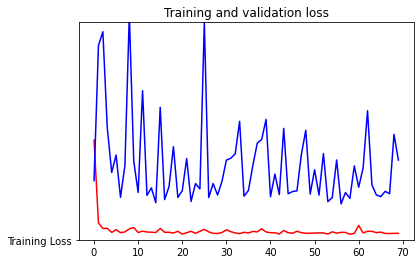

In [843]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_nvda_tr=history_nvda_tr.history['loss']
val_loss_nvda_tr=history_nvda_tr.history['val_loss']

epochs=range(len(loss_nvda_tr)) 

plt.plot(epochs, loss_nvda_tr, 'r', "Training Loss")
plt.plot(epochs, val_loss_nvda_tr, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

MSE: 0.007331188056319127  RMSE: 0.08562235722239331 R^2 score: 0.8486256886636472 MAPE: 0.06472128844220379


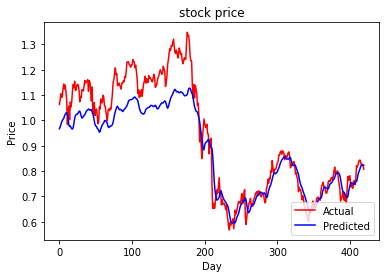

In [845]:
y_pred_nvda_tr=making_y_pred(model_nvda_tr,X_val_nvda_tr)
mse_nvda_tr,rmse_nvda_tr,r_nvda_tr,mape_nvda_tr=Evalu(model_nvda_tr,X_val_nvda_tr,y_val_nvda_tr,y_pred_nvda_tr)
testset_plot(y_val_nvda_tr,y_pred_nvda_tr)

###### feature selection by correlation

In [846]:
model_nvda_corr = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(5,kernel_size=2,input_shape=(50,5)),
    tf.keras.layers.Conv1D(64,kernel_size=2),
    tf.keras.layers.Conv1D(128,kernel_size=2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1)
    
])
model_nvda_corr.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_nvda_corr = model_nvda_corr.fit(X_train_nvda_corr,y_train_nvda_corr,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_nvda_corr, y_val_nvda_corr),verbose = 1)

Epoch 1/70
32/32 [==============================] - 2s 50ms/step - loss: 0.0049 - val_loss: 0.0204
Epoch 2/70
32/32 [==============================] - 1s 16ms/step - loss: 9.7750e-04 - val_loss: 0.0151
Epoch 3/70
32/32 [==============================] - 0s 16ms/step - loss: 7.6055e-04 - val_loss: 0.0032
Epoch 4/70
32/32 [==============================] - 1s 16ms/step - loss: 0.0010 - val_loss: 0.0055
Epoch 5/70
32/32 [==============================] - 1s 16ms/step - loss: 5.6332e-04 - val_loss: 0.0025
Epoch 6/70
32/32 [==============================] - 1s 16ms/step - loss: 4.9329e-04 - val_loss: 0.0025
Epoch 7/70
32/32 [==============================] - 1s 16ms/step - loss: 3.9368e-04 - val_loss: 0.0017
Epoch 8/70
32/32 [==============================] - 0s 15ms/step - loss: 3.9198e-04 - val_loss: 0.0020
Epoch 9/70
32/32 [==============================] - 0s 15ms/step - loss: 4.3429e-04 - val_loss: 0.0162
Epoch 10/70
32/32 [==============================] - 0s 15ms/step - loss: 4.6095e

Text(0.5, 1.0, 'corraining and validation loss')

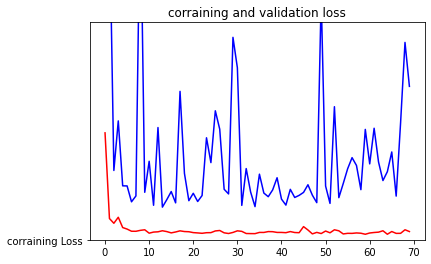

In [847]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_nvda_corr=history_nvda_corr.history['loss']
val_loss_nvda_corr=history_nvda_corr.history['val_loss']

epochs=range(len(loss_nvda_corr)) 

plt.plot(epochs, loss_nvda_corr, 'r', "corraining Loss")
plt.plot(epochs, val_loss_nvda_corr, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('corraining and validation loss')

MSE: 0.014112091943723436  RMSE: 0.11879432622698542 R^2 score: 0.7086136403696369 MAPE: 0.09999474391677708


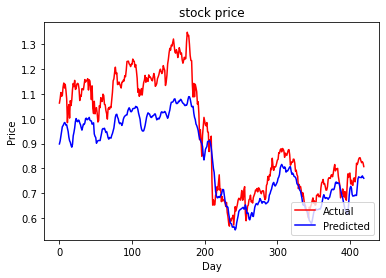

In [849]:
y_pred_nvda_corr=making_y_pred(model_nvda_corr,X_val_nvda_corr)
mse_nvda_corr,rmse_nvda_corr,r_nvda_corr,mape_nvda_corr=Evalu(model_nvda_corr,X_val_nvda_corr,y_val_nvda_corr,y_pred_nvda_corr)
testset_plot(y_val_nvda_corr,y_pred_nvda_corr)

###### feature selection by svm-rfe

In [850]:
model_nvda_svm = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(4,kernel_size=2,input_shape=(10,4)),
    tf.keras.layers.Conv1D(64,kernel_size=2),
    tf.keras.layers.Conv1D(128,kernel_size=2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1)
    
])
model_nvda_svm.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_nvda_svm = model_nvda_svm.fit(X_train_nvda_svm,y_train_nvda_svm,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_nvda_svm, y_val_nvda_svm),verbose = 1)

Epoch 1/70
32/32 [==============================] - 2s 49ms/step - loss: 0.0059 - val_loss: 0.0041
Epoch 2/70
32/32 [==============================] - 0s 15ms/step - loss: 6.8606e-04 - val_loss: 0.0025
Epoch 3/70
32/32 [==============================] - 0s 15ms/step - loss: 6.0284e-04 - val_loss: 0.0060
Epoch 4/70
32/32 [==============================] - 0s 14ms/step - loss: 5.4569e-04 - val_loss: 0.0021
Epoch 5/70
32/32 [==============================] - 0s 14ms/step - loss: 4.9616e-04 - val_loss: 0.0021
Epoch 6/70
32/32 [==============================] - 0s 15ms/step - loss: 5.9571e-04 - val_loss: 0.0033
Epoch 7/70
32/32 [==============================] - 0s 14ms/step - loss: 3.4633e-04 - val_loss: 0.0025
Epoch 8/70
32/32 [==============================] - 0s 14ms/step - loss: 3.9312e-04 - val_loss: 0.0032
Epoch 9/70
32/32 [==============================] - 0s 14ms/step - loss: 3.2692e-04 - val_loss: 0.0055
Epoch 10/70
32/32 [==============================] - 0s 14ms/step - loss: 3.3

Text(0.5, 1.0, 'svmaining and validation loss')

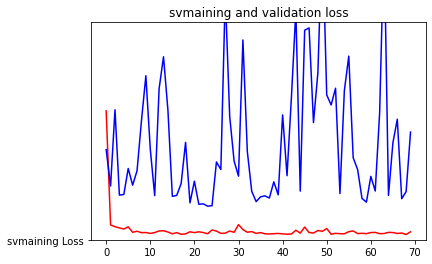

In [851]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_nvda_svm=history_nvda_svm.history['loss']
val_loss_nvda_svm=history_nvda_svm.history['val_loss']

epochs=range(len(loss_nvda_svm)) 

plt.plot(epochs, loss_nvda_svm, 'r', "svmaining Loss")
plt.plot(epochs, val_loss_nvda_svm, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('svmaining and validation loss')

MSE: 0.009911663900021735  RMSE: 0.09955733975966682 R^2 score: 0.7953440444390276 MAPE: 0.08520786934373113


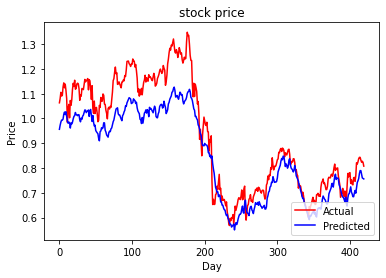

In [853]:
y_pred_nvda_svm=making_y_pred(model_nvda_svm,X_val_nvda_svm)
mse_nvda_svm,rmse_nvda_svm,r_nvda_svm,mape_nvda_svm=Evalu(model_nvda_svm,X_val_nvda_svm,y_val_nvda_svm,y_pred_nvda_svm)
testset_plot(y_val_nvda_svm,y_pred_nvda_svm)

##### Conv1d+LSTM

###### Traditional features

In [854]:
model_nvda_tr = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(5,kernel_size=2,input_shape=(10,5)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_nvda_tr.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_nvda_tr = model_nvda_tr.fit(X_train_nvda_tr,y_train_nvda_tr,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_nvda_tr, y_val_nvda_tr),verbose = 1)

Epoch 1/70
32/32 [==============================] - 2s 49ms/step - loss: 0.0074 - val_loss: 0.0030
Epoch 2/70
32/32 [==============================] - 0s 15ms/step - loss: 6.2372e-04 - val_loss: 0.0026
Epoch 3/70
32/32 [==============================] - 0s 15ms/step - loss: 4.9410e-04 - val_loss: 0.0021
Epoch 4/70
32/32 [==============================] - 0s 15ms/step - loss: 4.5961e-04 - val_loss: 0.0022
Epoch 5/70
32/32 [==============================] - 0s 15ms/step - loss: 4.4358e-04 - val_loss: 0.0065
Epoch 6/70
32/32 [==============================] - 0s 15ms/step - loss: 3.8284e-04 - val_loss: 0.0024
Epoch 7/70
32/32 [==============================] - 0s 15ms/step - loss: 4.0364e-04 - val_loss: 0.0086
Epoch 8/70
32/32 [==============================] - 0s 15ms/step - loss: 4.6741e-04 - val_loss: 0.0063
Epoch 9/70
32/32 [==============================] - 0s 15ms/step - loss: 5.6486e-04 - val_loss: 0.0020
Epoch 10/70
32/32 [==============================] - 0s 15ms/step - loss: 3.4

In [855]:
model_nvda_tr.summary()

Model: "sequential_186"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_296 (Conv1D)          (None, 9, 5)              55        
_________________________________________________________________
bidirectional_307 (Bidirecti (None, 9, 80)             14720     
_________________________________________________________________
bidirectional_308 (Bidirecti (None, 9, 80)             38720     
_________________________________________________________________
lstm_525 (LSTM)              (None, 40)                19360     
_________________________________________________________________
dropout_173 (Dropout)        (None, 40)                0         
_________________________________________________________________
dense_325 (Dense)            (None, 1)                 41        
Total params: 72,896
Trainable params: 72,896
Non-trainable params: 0
________________________________________________

Text(0.5, 1.0, 'Training and validation loss')

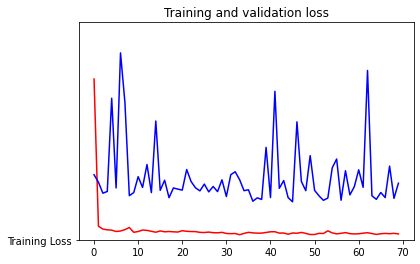

In [856]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_nvda_tr=history_nvda_tr.history['loss']
val_loss_nvda_tr=history_nvda_tr.history['val_loss']

epochs=range(len(loss_nvda_tr)) 

plt.plot(epochs, loss_nvda_tr, 'r', "Training Loss")
plt.plot(epochs, val_loss_nvda_tr, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

MSE: 0.0009066710238221144  RMSE: 0.030110978460058623 R^2 score: 0.6658610707640661 MAPE: 0.02671497724699777


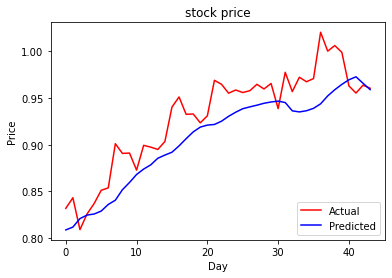

In [857]:
y_pred_nvda_tr=making_y_pred(model_nvda_tr,X_test_nvda_tr)
mse_nvda_tr,rmse_nvda_tr,r_nvda_tr,mape_nvda_tr=Evalu(model_nvda_tr,X_test_nvda_tr,y_test_nvda_tr,y_pred_nvda_tr)
testset_plot(y_test_nvda_tr,y_pred_nvda_tr)

MSE: 0.005204848034669252  RMSE: 0.0721446327502556 R^2 score: 0.8925303401296175 MAPE: 0.05723062704994361


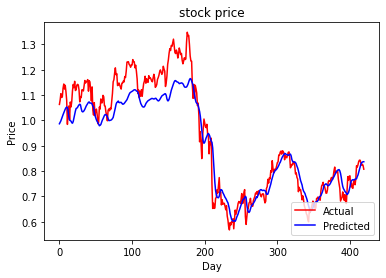

In [858]:
y_pred_nvda_tr=making_y_pred(model_nvda_tr,X_val_nvda_tr)
mse_nvda_tr,rmse_nvda_tr,r_nvda_tr,mape_nvda_tr=Evalu(model_nvda_tr,X_val_nvda_tr,y_val_nvda_tr,y_pred_nvda_tr)
testset_plot(y_val_nvda_tr,y_pred_nvda_tr)

###### feature selection by correlation

In [859]:
model_nvda_corr = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(5,kernel_size=2,input_shape=(10,5)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_nvda_corr.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_nvda_corr = model_nvda_corr.fit(X_train_nvda_corr,y_train_nvda_corr,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_nvda_corr, y_val_nvda_corr),verbose = 1)

Epoch 1/70
32/32 [==============================] - 2s 48ms/step - loss: 0.0101 - val_loss: 0.0076
Epoch 2/70
32/32 [==============================] - 0s 14ms/step - loss: 0.0011 - val_loss: 0.0042
Epoch 3/70
32/32 [==============================] - 0s 14ms/step - loss: 6.0562e-04 - val_loss: 0.0030
Epoch 4/70
32/32 [==============================] - 0s 14ms/step - loss: 6.3852e-04 - val_loss: 0.0038
Epoch 5/70
32/32 [==============================] - 0s 14ms/step - loss: 5.0339e-04 - val_loss: 0.0020
Epoch 6/70
32/32 [==============================] - 0s 14ms/step - loss: 4.7660e-04 - val_loss: 0.0031
Epoch 7/70
32/32 [==============================] - 0s 14ms/step - loss: 4.6553e-04 - val_loss: 0.0021
Epoch 8/70
32/32 [==============================] - 0s 14ms/step - loss: 4.5060e-04 - val_loss: 0.0016
Epoch 9/70
32/32 [==============================] - 0s 14ms/step - loss: 3.6551e-04 - val_loss: 0.0016
Epoch 10/70
32/32 [==============================] - 0s 14ms/step - loss: 3.5803e

Text(0.5, 1.0, 'corraining and validation loss')

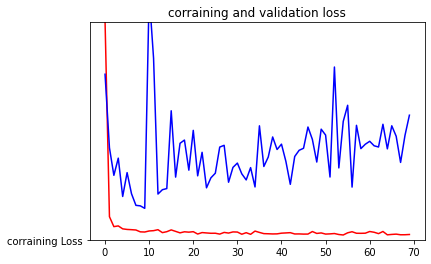

In [860]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_nvda_corr=history_nvda_corr.history['loss']
val_loss_nvda_corr=history_nvda_corr.history['val_loss']

epochs=range(len(loss_nvda_corr)) 

plt.plot(epochs, loss_nvda_corr, 'r', "corraining Loss")
plt.plot(epochs, val_loss_nvda_corr, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('corraining and validation loss')

MSE: 0.0007872053283278694  RMSE: 0.028057179621762934 R^2 score: 0.7098882190064312 MAPE: 0.025928892281914126


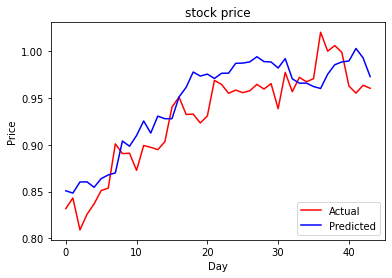

In [861]:
y_pred_nvda_corr=making_y_pred(model_nvda_corr,X_test_nvda_corr)
mse_nvda_corr,rmse_nvda_corr,r_nvda_corr,mape_nvda_corr=Evalu(model_nvda_corr,X_test_nvda_corr,y_test_nvda_corr,y_pred_nvda_corr)
testset_plot(y_test_nvda_corr,y_pred_nvda_corr)

MSE: 0.011460973223153322  RMSE: 0.1070559350206859 R^2 score: 0.763353918141028 MAPE: 0.08423903327743183


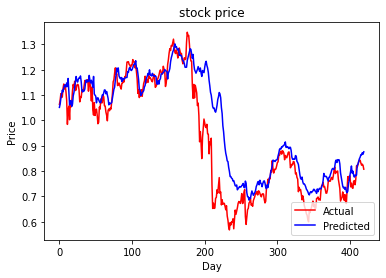

In [862]:
y_pred_nvda_corr=making_y_pred(model_nvda_corr,X_val_nvda_corr)
mse_nvda_corr,rmse_nvda_corr,r_nvda_corr,mape_nvda_corr=Evalu(model_nvda_corr,X_val_nvda_corr,y_val_nvda_corr,y_pred_nvda_corr)
testset_plot(y_val_nvda_corr,y_pred_nvda_corr)

###### feature selection by svm-rfe

In [863]:
model_nvda_svm = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(4,kernel_size=1,input_shape=(10,4)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_nvda_svm.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_nvda_svm = model_nvda_svm.fit(X_train_nvda_svm,y_train_nvda_svm,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_nvda_svm, y_val_nvda_svm),verbose = 1)

Epoch 1/70
32/32 [==============================] - 13s 402ms/step - loss: 0.0061 - val_loss: 0.0032
Epoch 2/70
32/32 [==============================] - 1s 22ms/step - loss: 7.7237e-04 - val_loss: 0.0024
Epoch 3/70
32/32 [==============================] - 1s 22ms/step - loss: 6.0333e-04 - val_loss: 0.0018
Epoch 4/70
32/32 [==============================] - 1s 22ms/step - loss: 5.6298e-04 - val_loss: 0.0055
Epoch 5/70
32/32 [==============================] - 1s 22ms/step - loss: 6.1927e-04 - val_loss: 0.0026
Epoch 6/70
32/32 [==============================] - 1s 23ms/step - loss: 4.1761e-04 - val_loss: 0.0015
Epoch 7/70
32/32 [==============================] - 1s 23ms/step - loss: 4.6667e-04 - val_loss: 0.0048
Epoch 8/70
32/32 [==============================] - 1s 22ms/step - loss: 3.9629e-04 - val_loss: 0.0023
Epoch 9/70
32/32 [==============================] - 1s 22ms/step - loss: 4.4752e-04 - val_loss: 0.0011
Epoch 10/70
32/32 [==============================] - 1s 22ms/step - loss: 3

Text(0.5, 1.0, 'svmaining and validation loss')

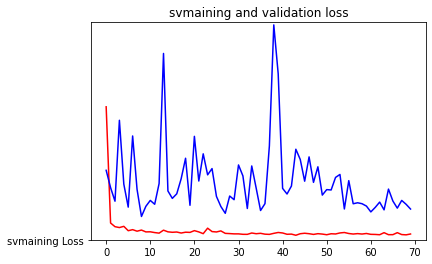

In [864]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_nvda_svm=history_nvda_svm.history['loss']
val_loss_nvda_svm=history_nvda_svm.history['val_loss']

epochs=range(len(loss_nvda_svm)) 

plt.plot(epochs, loss_nvda_svm, 'r', "svmaining Loss")
plt.plot(epochs, val_loss_nvda_svm, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('svmaining and validation loss')

MSE: 0.0003759830387537973  RMSE: 0.019390282069990557 R^2 score: 0.8614375372332239 MAPE: 0.01605926182140901


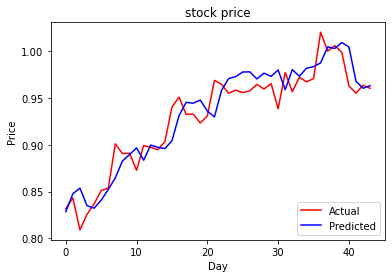

In [865]:
y_pred_nvda_svm=making_y_pred(model_nvda_svm,X_test_nvda_svm)
mse_nvda_svm,rmse_nvda_svm,r_nvda_svm,mape_nvda_svm=Evalu(model_nvda_svm,X_test_nvda_svm,y_test_nvda_svm,y_pred_nvda_svm)
testset_plot(y_test_nvda_svm,y_pred_nvda_svm)

MSE: 0.0028298418022754154  RMSE: 0.053196257408537825 R^2 score: 0.9415694494917458 MAPE: 0.044328470616308874


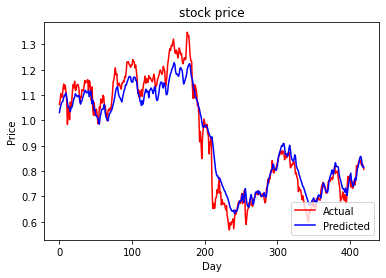

In [866]:
y_pred_nvda_svm=making_y_pred(model_nvda_svm,X_val_nvda_svm)
mse_nvda_svm,rmse_nvda_svm,r_nvda_svm,mape_nvda_svm=Evalu(model_nvda_svm,X_val_nvda_svm,y_val_nvda_svm,y_pred_nvda_svm)
testset_plot(y_val_nvda_svm,y_pred_nvda_svm)

#### window_size 50

In [867]:
#Traning:2010-01-04 to 2018-01-03, Validation: 2018-01-04 to 2020-01-02, testing: 2020-01-03

df_nvda_picked_tr = df_nvda[['Close','Open','High','Low','Volume']] 
df_nvda_picked_corr = df_nvda[['Close','H-L','7 DAYS STD DEV','RSI','MACD']] 
df_nvda_picked_svm = df_nvda[['Close','6 DAYS WMS','MACD','20 DAYS EMA']] 

windows_size=50

train_sc_tr,val_sc_tr,test_sc_tr=making_scaled_training_val_test_data(df_nvda_picked_tr,2755,4770,5200,5495)
X_train_nvda_tr,y_train_nvda_tr,X_val_nvda_tr,y_val_nvda_tr=making_train_val(train_sc_tr,val_sc_tr,windows_size)
X_test_nvda_tr,y_test_nvda_tr=making_test(test_sc_tr,windows_size)

train_sc_corr,val_sc_corr,test_sc_corr=making_scaled_training_val_test_data(df_nvda_picked_corr,2755,4770,5200,5495)
X_train_nvda_corr,y_train_nvda_corr,X_val_nvda_corr,y_val_nvda_corr=making_train_val(train_sc_corr,val_sc_corr,windows_size)
X_test_nvda_corr,y_test_nvda_corr=making_test(test_sc_corr,windows_size)

train_sc_svm,val_sc_svm,test_sc_svm=making_scaled_training_val_test_data(df_nvda_picked_svm,2755,4770,5200,5495)
X_train_nvda_svm,y_train_nvda_svm,X_val_nvda_svm,y_val_nvda_svm=making_train_val(train_sc_svm,val_sc_svm,windows_size)
X_test_nvda_svm,y_test_nvda_svm=making_test(test_sc_svm,windows_size)

##### 3CNN+LSTM+3DNN

###### Traditional features

In [868]:
model_nvda_tr = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(5,kernel_size=2,input_shape=(50,5)),
    tf.keras.layers.Conv1D(64,kernel_size=2),
    tf.keras.layers.Conv1D(128,kernel_size=2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1)
    
])
model_nvda_tr.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_nvda_tr = model_nvda_tr.fit(X_train_nvda_tr,y_train_nvda_tr,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_nvda_tr, y_val_nvda_tr),verbose = 1)

Epoch 1/70
31/31 [==============================] - 4s 124ms/step - loss: 0.0026 - val_loss: 0.0035
Epoch 2/70
31/31 [==============================] - 3s 89ms/step - loss: 5.5532e-04 - val_loss: 0.0087
Epoch 3/70
31/31 [==============================] - 3s 89ms/step - loss: 5.9139e-04 - val_loss: 0.0034
Epoch 4/70
31/31 [==============================] - 3s 89ms/step - loss: 4.8700e-04 - val_loss: 0.0197
Epoch 5/70
31/31 [==============================] - 3s 89ms/step - loss: 5.2910e-04 - val_loss: 0.0060
Epoch 6/70
31/31 [==============================] - 3s 89ms/step - loss: 5.8803e-04 - val_loss: 0.0041
Epoch 7/70
31/31 [==============================] - 3s 89ms/step - loss: 4.6291e-04 - val_loss: 0.0042
Epoch 8/70
31/31 [==============================] - 3s 89ms/step - loss: 4.7363e-04 - val_loss: 0.0040
Epoch 9/70
31/31 [==============================] - 3s 90ms/step - loss: 3.7195e-04 - val_loss: 0.0048
Epoch 10/70
31/31 [==============================] - 3s 90ms/step - loss: 6.

In [869]:
model_nvda_tr.summary()

Model: "sequential_189"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_299 (Conv1D)          (None, 49, 5)             55        
_________________________________________________________________
conv1d_300 (Conv1D)          (None, 48, 64)            704       
_________________________________________________________________
conv1d_301 (Conv1D)          (None, 47, 128)           16512     
_________________________________________________________________
bidirectional_313 (Bidirecti (None, 47, 80)            54080     
_________________________________________________________________
bidirectional_314 (Bidirecti (None, 47, 80)            38720     
_________________________________________________________________
lstm_534 (LSTM)              (None, 40)                19360     
_________________________________________________________________
dropout_176 (Dropout)        (None, 40)             

Text(0.5, 1.0, 'Training and validation loss')

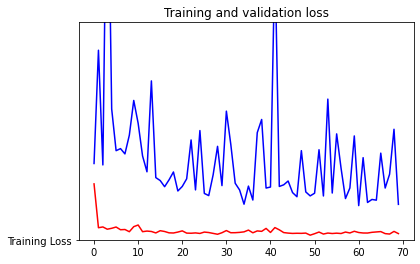

In [870]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_nvda_tr=history_nvda_tr.history['loss']
val_loss_nvda_tr=history_nvda_tr.history['val_loss']

epochs=range(len(loss_nvda_tr)) 

plt.plot(epochs, loss_nvda_tr, 'r', "Training Loss")
plt.plot(epochs, val_loss_nvda_tr, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

MSE: 0.0008685183809484303  RMSE: 0.029470635910146734 R^2 score: -78.76076227014546 MAPE: 0.029126937307319953


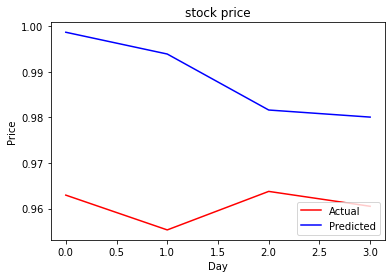

In [871]:
y_pred_nvda_tr=making_y_pred(model_nvda_tr,X_test_nvda_tr)
mse_nvda_tr,rmse_nvda_tr,r_nvda_tr,mape_nvda_tr=Evalu(model_nvda_tr,X_test_nvda_tr,y_test_nvda_tr,y_pred_nvda_tr)
testset_plot(y_test_nvda_tr,y_pred_nvda_tr)

MSE: 0.0032606648271101706  RMSE: 0.05710223136717313 R^2 score: 0.934480646738965 MAPE: 0.04885191349733365


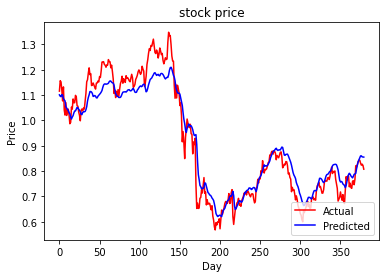

In [872]:
y_pred_nvda_tr=making_y_pred(model_nvda_tr,X_val_nvda_tr)
mse_nvda_tr,rmse_nvda_tr,r_nvda_tr,mape_nvda_tr=Evalu(model_nvda_tr,X_val_nvda_tr,y_val_nvda_tr,y_pred_nvda_tr)
testset_plot(y_val_nvda_tr,y_pred_nvda_tr)

###### feature selection by correlation

In [873]:
model_nvda_corr = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(5,kernel_size=1,input_shape=(50,5)),
    tf.keras.layers.Conv1D(64,kernel_size=2),
    tf.keras.layers.Conv1D(128,kernel_size=2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1)
    
])
model_nvda_corr.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_nvda_corr = model_nvda_corr.fit(X_train_nvda_corr,y_train_nvda_corr,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_nvda_corr, y_val_nvda_corr),verbose = 1)

Epoch 1/70
31/31 [==============================] - 4s 124ms/step - loss: 0.0057 - val_loss: 0.0159
Epoch 2/70
31/31 [==============================] - 3s 87ms/step - loss: 0.0010 - val_loss: 0.0133
Epoch 3/70
31/31 [==============================] - 3s 88ms/step - loss: 6.6104e-04 - val_loss: 0.0062
Epoch 4/70
31/31 [==============================] - 3s 87ms/step - loss: 5.5631e-04 - val_loss: 0.0086
Epoch 5/70
31/31 [==============================] - 3s 88ms/step - loss: 7.0793e-04 - val_loss: 0.0092
Epoch 6/70
31/31 [==============================] - 3s 87ms/step - loss: 5.4339e-04 - val_loss: 0.0096
Epoch 7/70
31/31 [==============================] - 3s 87ms/step - loss: 5.2156e-04 - val_loss: 0.0086
Epoch 8/70
31/31 [==============================] - 3s 88ms/step - loss: 4.1460e-04 - val_loss: 0.0091
Epoch 9/70
31/31 [==============================] - 3s 88ms/step - loss: 3.8686e-04 - val_loss: 0.0111
Epoch 10/70
31/31 [==============================] - 3s 88ms/step - loss: 6.3382

Text(0.5, 1.0, 'corraining and validation loss')

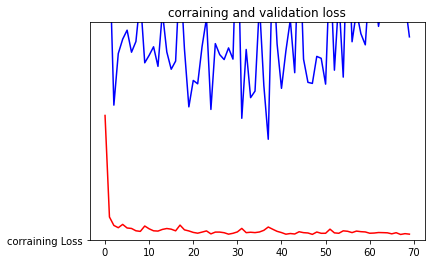

In [874]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_nvda_corr=history_nvda_corr.history['loss']
val_loss_nvda_corr=history_nvda_corr.history['val_loss']

epochs=range(len(loss_nvda_corr)) 

plt.plot(epochs, loss_nvda_corr, 'r', "corraining Loss")
plt.plot(epochs, val_loss_nvda_corr, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('corraining and validation loss')

MSE: 0.00022198235251128345  RMSE: 0.014899072203036115 R^2 score: -19.385845636894352 MAPE: 0.012036296264956683


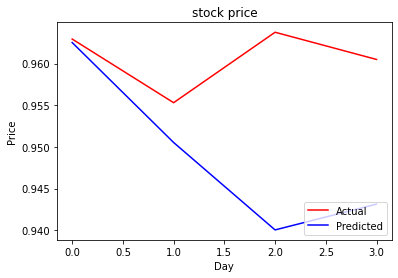

In [875]:
y_pred_nvda_corr=making_y_pred(model_nvda_corr,X_test_nvda_corr)
mse_nvda_corr,rmse_nvda_corr,r_nvda_corr,mape_nvda_corr=Evalu(model_nvda_corr,X_test_nvda_corr,y_test_nvda_corr,y_pred_nvda_corr)
testset_plot(y_test_nvda_corr,y_pred_nvda_corr)

MSE: 0.018667238910317047  RMSE: 0.13662810439407058 R^2 score: 0.6249030533882978 MAPE: 0.1242380012823961


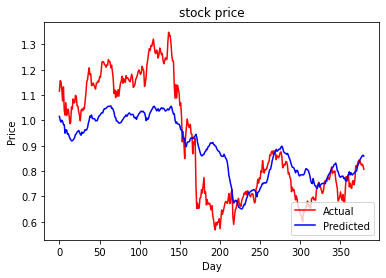

In [876]:
y_pred_nvda_corr=making_y_pred(model_nvda_corr,X_val_nvda_corr)
mse_nvda_corr,rmse_nvda_corr,r_nvda_corr,mape_nvda_corr=Evalu(model_nvda_corr,X_val_nvda_corr,y_val_nvda_corr,y_pred_nvda_corr)
testset_plot(y_val_nvda_corr,y_pred_nvda_corr)

###### feature selection by svm-rfe

In [877]:
model_nvda_svm = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(4,kernel_size=2,input_shape=(50,4)),
    tf.keras.layers.Conv1D(64,kernel_size=2),
    tf.keras.layers.Conv1D(128,kernel_size=2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1)
    
])
model_nvda_svm.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_nvda_svm = model_nvda_svm.fit(X_train_nvda_svm,y_train_nvda_svm,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_nvda_svm, y_val_nvda_svm),verbose = 1)

Epoch 1/70
31/31 [==============================] - 4s 117ms/step - loss: 0.0079 - val_loss: 0.0067
Epoch 2/70
31/31 [==============================] - 3s 81ms/step - loss: 7.1263e-04 - val_loss: 0.0050
Epoch 3/70
31/31 [==============================] - 2s 80ms/step - loss: 4.5436e-04 - val_loss: 0.0036
Epoch 4/70
31/31 [==============================] - 3s 81ms/step - loss: 4.9837e-04 - val_loss: 0.0104
Epoch 5/70
31/31 [==============================] - 2s 80ms/step - loss: 5.5246e-04 - val_loss: 0.0146
Epoch 6/70
31/31 [==============================] - 2s 80ms/step - loss: 5.6799e-04 - val_loss: 0.0039
Epoch 7/70
31/31 [==============================] - 3s 81ms/step - loss: 3.4006e-04 - val_loss: 0.0065
Epoch 8/70
31/31 [==============================] - 2s 81ms/step - loss: 4.2322e-04 - val_loss: 0.0029
Epoch 9/70
31/31 [==============================] - 2s 80ms/step - loss: 3.6421e-04 - val_loss: 0.0063
Epoch 10/70
31/31 [==============================] - 3s 81ms/step - loss: 4.

Text(0.5, 1.0, 'svmaining and validation loss')

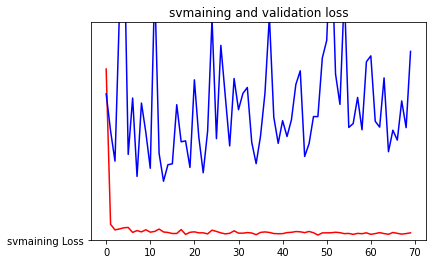

In [878]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_nvda_svm=history_nvda_svm.history['loss']
val_loss_nvda_svm=history_nvda_svm.history['val_loss']

epochs=range(len(loss_nvda_svm)) 

plt.plot(epochs, loss_nvda_svm, 'r', "svmaining Loss")
plt.plot(epochs, val_loss_nvda_svm, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('svmaining and validation loss')

MSE: 0.005339079501256526  RMSE: 0.0730690050654621 R^2 score: -489.31668204430787 MAPE: 0.07507400302794931


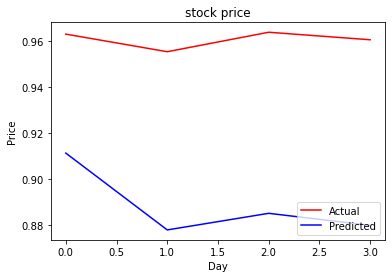

In [879]:
y_pred_nvda_svm=making_y_pred(model_nvda_svm,X_test_nvda_svm)
mse_nvda_svm,rmse_nvda_svm,r_nvda_svm,mape_nvda_svm=Evalu(model_nvda_svm,X_test_nvda_svm,y_test_nvda_svm,y_pred_nvda_svm)
testset_plot(y_test_nvda_svm,y_pred_nvda_svm)

MSE: 0.01732777535931218  RMSE: 0.1316350081069325 R^2 score: 0.6518180508602543 MAPE: 0.11367264772329891


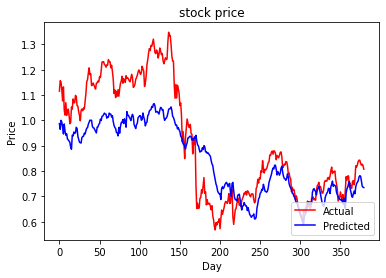

In [880]:
y_pred_nvda_svm=making_y_pred(model_nvda_svm,X_val_nvda_svm)
mse_nvda_svm,rmse_nvda_svm,r_nvda_svm,mape_nvda_svm=Evalu(model_nvda_svm,X_val_nvda_svm,y_val_nvda_svm,y_pred_nvda_svm)
testset_plot(y_val_nvda_svm,y_pred_nvda_svm)

##### Conv1d+LSTM

###### Traditional features

In [881]:
model_nvda_tr = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(5,kernel_size=2,input_shape=(50,5)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_nvda_tr.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_nvda_tr = model_nvda_tr.fit(X_train_nvda_tr,y_train_nvda_tr,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_nvda_tr, y_val_nvda_tr),verbose = 1)

Epoch 1/70
31/31 [==============================] - 3s 104ms/step - loss: 0.0058 - val_loss: 0.0060
Epoch 2/70
31/31 [==============================] - 2s 70ms/step - loss: 6.3208e-04 - val_loss: 0.0025
Epoch 3/70
31/31 [==============================] - 2s 69ms/step - loss: 5.1377e-04 - val_loss: 0.0029
Epoch 4/70
31/31 [==============================] - 2s 69ms/step - loss: 5.2710e-04 - val_loss: 0.0023
Epoch 5/70
31/31 [==============================] - 2s 69ms/step - loss: 5.0134e-04 - val_loss: 0.0044
Epoch 6/70
31/31 [==============================] - 2s 70ms/step - loss: 4.7237e-04 - val_loss: 0.0020
Epoch 7/70
31/31 [==============================] - 2s 69ms/step - loss: 4.8860e-04 - val_loss: 0.0019
Epoch 8/70
31/31 [==============================] - 2s 69ms/step - loss: 4.5271e-04 - val_loss: 0.0018
Epoch 9/70
31/31 [==============================] - 2s 70ms/step - loss: 4.4024e-04 - val_loss: 0.0027
Epoch 10/70
31/31 [==============================] - 2s 69ms/step - loss: 4.

In [882]:
model_nvda_tr.summary()

Model: "sequential_192"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_308 (Conv1D)          (None, 49, 5)             55        
_________________________________________________________________
bidirectional_319 (Bidirecti (None, 49, 80)            14720     
_________________________________________________________________
bidirectional_320 (Bidirecti (None, 49, 80)            38720     
_________________________________________________________________
lstm_543 (LSTM)              (None, 40)                19360     
_________________________________________________________________
dropout_179 (Dropout)        (None, 40)                0         
_________________________________________________________________
dense_337 (Dense)            (None, 1)                 41        
Total params: 72,896
Trainable params: 72,896
Non-trainable params: 0
________________________________________________

Text(0.5, 1.0, 'Training and validation loss')

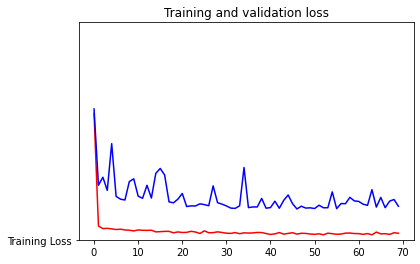

In [883]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_nvda_tr=history_nvda_tr.history['loss']
val_loss_nvda_tr=history_nvda_tr.history['val_loss']

epochs=range(len(loss_nvda_tr)) 

plt.plot(epochs, loss_nvda_tr, 'r', "Training Loss")
plt.plot(epochs, val_loss_nvda_tr, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

MSE: 0.0011740612705605166  RMSE: 0.03426457748988767 R^2 score: -106.82042607952883 MAPE: 0.034831231223292944


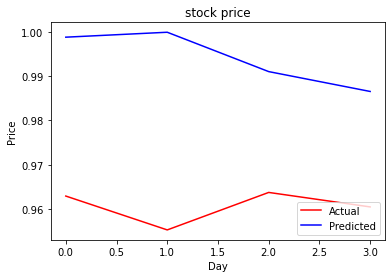

In [884]:
y_pred_nvda_tr=making_y_pred(model_nvda_tr,X_test_nvda_tr)
mse_nvda_tr,rmse_nvda_tr,r_nvda_tr,mape_nvda_tr=Evalu(model_nvda_tr,X_test_nvda_tr,y_test_nvda_tr,y_pred_nvda_tr)
testset_plot(y_test_nvda_tr,y_pred_nvda_tr)

MSE: 0.003084303847766391  RMSE: 0.05553650914278274 R^2 score: 0.9380244201470795 MAPE: 0.04913195197529142


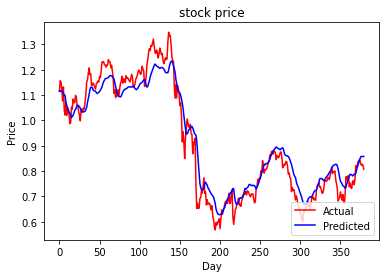

In [885]:
y_pred_nvda_tr=making_y_pred(model_nvda_tr,X_val_nvda_tr)
mse_nvda_tr,rmse_nvda_tr,r_nvda_tr,mape_nvda_tr=Evalu(model_nvda_tr,X_val_nvda_tr,y_val_nvda_tr,y_pred_nvda_tr)
testset_plot(y_val_nvda_tr,y_pred_nvda_tr)

###### feature selection by correlation

In [886]:
model_nvda_corr = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(5,kernel_size=2,input_shape=(50,5)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_nvda_corr.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_nvda_corr = model_nvda_corr.fit(X_train_nvda_corr,y_train_nvda_corr,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_nvda_corr, y_val_nvda_corr),verbose = 1)

Epoch 1/70
31/31 [==============================] - 3s 102ms/step - loss: 0.0049 - val_loss: 0.0069
Epoch 2/70
31/31 [==============================] - 2s 67ms/step - loss: 7.5875e-04 - val_loss: 0.0049
Epoch 3/70
31/31 [==============================] - 2s 67ms/step - loss: 5.3792e-04 - val_loss: 0.0024
Epoch 4/70
31/31 [==============================] - 2s 67ms/step - loss: 4.7585e-04 - val_loss: 0.0080
Epoch 5/70
31/31 [==============================] - 2s 67ms/step - loss: 5.3547e-04 - val_loss: 0.0036
Epoch 6/70
31/31 [==============================] - 2s 67ms/step - loss: 4.9932e-04 - val_loss: 0.0021
Epoch 7/70
31/31 [==============================] - 2s 67ms/step - loss: 4.7266e-04 - val_loss: 0.0021
Epoch 8/70
31/31 [==============================] - 2s 67ms/step - loss: 4.6783e-04 - val_loss: 0.0018
Epoch 9/70
31/31 [==============================] - 2s 67ms/step - loss: 6.2689e-04 - val_loss: 0.0037
Epoch 10/70
31/31 [==============================] - 2s 68ms/step - loss: 4.

Text(0.5, 1.0, 'corraining and validation loss')

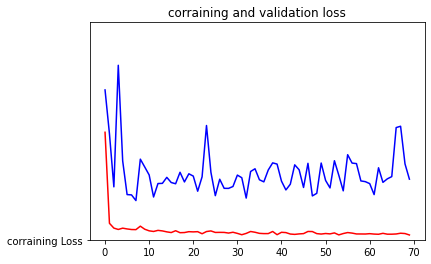

In [887]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_nvda_corr=history_nvda_corr.history['loss']
val_loss_nvda_corr=history_nvda_corr.history['val_loss']

epochs=range(len(loss_nvda_corr)) 

plt.plot(epochs, loss_nvda_corr, 'r', "corraining Loss")
plt.plot(epochs, val_loss_nvda_corr, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('corraining and validation loss')

MSE: 0.0006024037759322458  RMSE: 0.024543915252710716 R^2 score: -54.32201208027487 MAPE: 0.022520595629696136


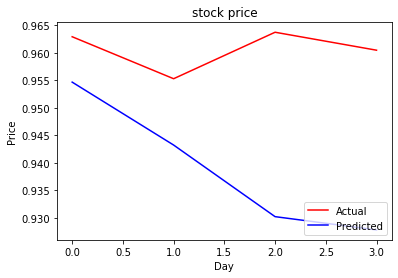

In [888]:
y_pred_nvda_corr=making_y_pred(model_nvda_corr,X_test_nvda_corr)
mse_nvda_corr,rmse_nvda_corr,r_nvda_corr,mape_nvda_corr=Evalu(model_nvda_corr,X_test_nvda_corr,y_test_nvda_corr,y_pred_nvda_corr)
testset_plot(y_test_nvda_corr,y_pred_nvda_corr)

MSE: 0.005577749087944059  RMSE: 0.07468432960095484 R^2 score: 0.8879214723770582 MAPE: 0.061590942421342804


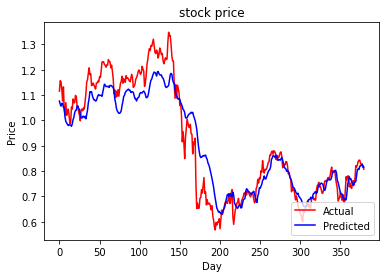

In [889]:
y_pred_nvda_corr=making_y_pred(model_nvda_corr,X_val_nvda_corr)
mse_nvda_corr,rmse_nvda_corr,r_nvda_corr,mape_nvda_corr=Evalu(model_nvda_corr,X_val_nvda_corr,y_val_nvda_corr,y_pred_nvda_corr)
testset_plot(y_val_nvda_corr,y_pred_nvda_corr)

###### feature selection by svm-rfe

In [890]:
model_nvda_svm = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(4,kernel_size=2,input_shape=(50,4)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_nvda_svm.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_nvda_svm = model_nvda_svm.fit(X_train_nvda_svm,y_train_nvda_svm,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_nvda_svm, y_val_nvda_svm),verbose = 1)

Epoch 1/70
31/31 [==============================] - 3s 100ms/step - loss: 0.0036 - val_loss: 0.0043
Epoch 2/70
31/31 [==============================] - 2s 64ms/step - loss: 7.0032e-04 - val_loss: 0.0026
Epoch 3/70
31/31 [==============================] - 2s 64ms/step - loss: 5.5532e-04 - val_loss: 0.0041
Epoch 4/70
31/31 [==============================] - 2s 64ms/step - loss: 4.3104e-04 - val_loss: 0.0030
Epoch 5/70
31/31 [==============================] - 2s 64ms/step - loss: 4.5988e-04 - val_loss: 0.0017
Epoch 6/70
31/31 [==============================] - 2s 65ms/step - loss: 6.0618e-04 - val_loss: 0.0021
Epoch 7/70
31/31 [==============================] - 2s 64ms/step - loss: 4.5432e-04 - val_loss: 0.0064
Epoch 8/70
31/31 [==============================] - 2s 64ms/step - loss: 4.0633e-04 - val_loss: 0.0020
Epoch 9/70
31/31 [==============================] - 2s 64ms/step - loss: 4.5925e-04 - val_loss: 0.0017
Epoch 10/70
31/31 [==============================] - 2s 64ms/step - loss: 4.

Text(0.5, 1.0, 'svmaining and validation loss')

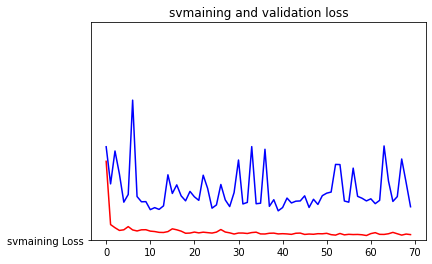

In [891]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_nvda_svm=history_nvda_svm.history['loss']
val_loss_nvda_svm=history_nvda_svm.history['val_loss']

epochs=range(len(loss_nvda_svm)) 

plt.plot(epochs, loss_nvda_svm, 'r', "svmaining Loss")
plt.plot(epochs, val_loss_nvda_svm, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('svmaining and validation loss')

MSE: 0.0017429238708998032  RMSE: 0.041748339738243524 R^2 score: -159.06216974935302 MAPE: 0.04067817376861897


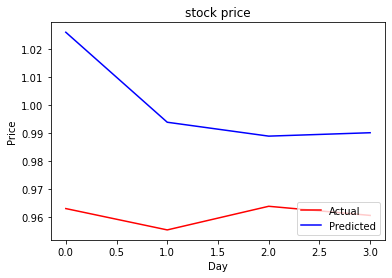

In [892]:
y_pred_nvda_svm=making_y_pred(model_nvda_svm,X_test_nvda_svm)
mse_nvda_svm,rmse_nvda_svm,r_nvda_svm,mape_nvda_svm=Evalu(model_nvda_svm,X_test_nvda_svm,y_test_nvda_svm,y_pred_nvda_svm)
testset_plot(y_test_nvda_svm,y_pred_nvda_svm)

MSE: 0.0030405469282671796  RMSE: 0.05514115457865549 R^2 score: 0.9389036657053618 MAPE: 0.04905732030647077


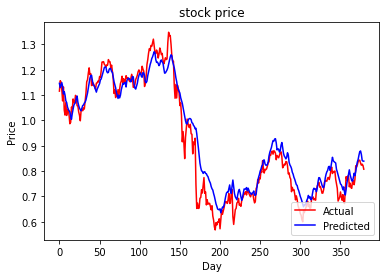

In [893]:
y_pred_nvda_svm=making_y_pred(model_nvda_svm,X_val_nvda_svm)
mse_nvda_svm,rmse_nvda_svm,r_nvda_svm,mape_nvda_svm=Evalu(model_nvda_svm,X_val_nvda_svm,y_val_nvda_svm,y_pred_nvda_svm)
testset_plot(y_val_nvda_svm,y_pred_nvda_svm)

#### Conclusion

In [895]:
model_selection=pd.DataFrame(columns=(['10','50']),
                     index=(['Conv-LSTM','3CNN-LSTM-3DNN']))

In [898]:
model_selection.iloc[0,0]=(0.0721446327502556   +0.1070559350206859   +  0.053196257408537825  )/3 
model_selection.iloc[0,1]=(0.05514115457865549   +0.07468432960095484   +0.05553650914278274  ) /3
model_selection.iloc[1,0]=(0.08562235722239331   +0.11879432622698542   +0.09955733975966682   )/3
model_selection.iloc[1,1]=(0.13662810439407058   +0.1316350081069325   +0.05710223136717313   )/3 

In [899]:
model_selection

10         50
Conv-LSTM       0.0774656  0.0617873
3CNN-LSTM-3DNN   0.101325   0.108455

### Conclusion with feature selection

In [900]:
model_selection=pd.DataFrame(columns=(['Traditional','Corr','SVM-RFE']),
                     index=(['RMSE','MAPE']))

In [1013]:
model_selection.iloc[0,0]=0.0721446327502556
model_selection.iloc[0,1]=0.1070559350206859
model_selection.iloc[0,2]=0.053196257408537825
model_selection.iloc[1,0]=0.05723062704994361 
model_selection.iloc[1,1]=0.08423903327743183
model_selection.iloc[1,2]=0.044328470616308874

In [1014]:
mo1=model_selection.copy()

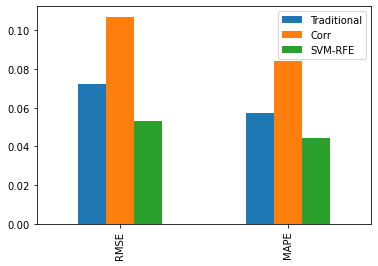

In [904]:
model_selection.plot(kind='bar') #nvda

In [1011]:
model_selection.iloc[0,0]=0.07197375309008477
model_selection.iloc[0,1]=0.09083878815356677 
model_selection.iloc[0,2]=0.11099633461286132
model_selection.iloc[1,0]=0.03414067117847094 
model_selection.iloc[1,1]=0.04181510624906862
model_selection.iloc[1,2]=0.05775200060038441

In [1012]:
mo2=model_selection.copy()

In [911]:
model_selection

Traditional       Corr   SVM-RFE
RMSE   0.0719738  0.0908388  0.110996
MAPE   0.0341407  0.0418151  0.057752

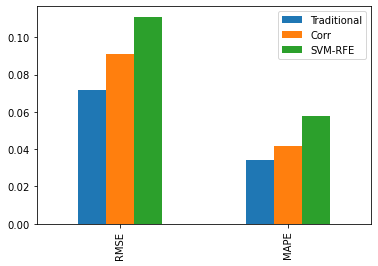

In [906]:
model_selection.plot(kind='bar') #msft

In [1015]:
model_selection.iloc[0,0]=0.06782491994477331
model_selection.iloc[0,1]=0.04486525068458911 
model_selection.iloc[0,2]=0.05594026756088599
model_selection.iloc[1,0]=0.03827196255048837
model_selection.iloc[1,1]=0.03277280341573352
model_selection.iloc[1,2]=0.04095392536315471

In [1016]:
mo3=model_selection.copy()

In [1010]:
model_selection

Traditional       Corr    SVM-RFE
RMSE   0.0678249  0.0448653  0.0559403
MAPE    0.038272  0.0327728  0.0409539

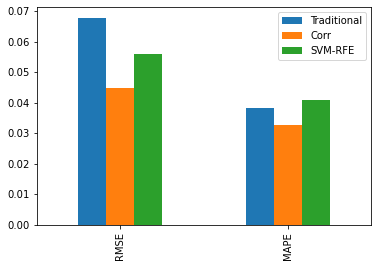

In [909]:
model_selection.plot(kind='bar') #INTC

In [1018]:
model_without_sentiment=(mo1+mo2+mo3)/3

## Training 3 companies with applying sentiment analysis

### Handling news dataset

In [915]:
newsheadlines=pd.read_csv('news_headlines.csv',encoding='utf-8',index_col=False)

In [917]:
newsheadlines['Company'].value_counts()

MSFT    2321
INTC    1247
NVDA     991
Name: Company, dtype: int64

In [925]:
newsheadlines=newsheadlines.drop(newsheadlines.columns[0:2],axis=1)

In [928]:
news_msft=newsheadlines.loc[newsheadlines['Company']=='MSFT']
news_nvda=newsheadlines.loc[newsheadlines['Company']=='NVDA']
news_intc=newsheadlines.loc[newsheadlines['Company']=='INTC']

In [929]:
#Change the time and date 
import datetime
for i in range(len(news_msft)):
    news_msft['date'].iloc[i]=datetime.datetime.strptime(news_msft['date'].iloc[i],'%Y-%m-%d').strftime('%Y-%m-%d')   
    news_msft['time'].iloc[i]=datetime.datetime.strptime(news_msft['time'].iloc[i],'%H:%M:%S').strftime('%H:%M') 
for i in range(len(news_nvda)):
    news_nvda['date'].iloc[i]=datetime.datetime.strptime(news_nvda['date'].iloc[i],'%Y-%m-%d').strftime('%Y-%m-%d')   
    news_nvda['time'].iloc[i]=datetime.datetime.strptime(news_nvda['time'].iloc[i],'%H:%M:%S').strftime('%H:%M') 
for i in range(len(news_intc)):
    news_intc['date'].iloc[i]=datetime.datetime.strptime(news_intc['date'].iloc[i],'%Y-%m-%d').strftime('%Y-%m-%d')   
    news_intc['time'].iloc[i]=datetime.datetime.strptime(news_intc['time'].iloc[i],'%H:%M:%S').strftime('%H:%M') 

C:\Users\oukle\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\oukle\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\oukle\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\oukle\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:



In [930]:
news_intc

Company        date   time  \
2321    INTC  2020-10-19  20:28   
2322    INTC  2019-05-20  08:38   
2323    INTC  2012-04-25  16:05   
2324    INTC  2012-04-17  16:04   
2325    INTC  2012-03-13  11:45   
...      ...         ...    ...   
3563    INTC  2009-10-23  16:01   
3564    INTC  2009-10-23  09:15   
3565    INTC  2009-10-13  16:37   
3566    INTC  2009-10-13  16:22   
3567    INTC  2009-10-13  09:08   

                                               headline  Sentiment  
2321  Intel agrees to sell its Nand memory unit to S...          1  
2322  With S&amp;P futures getting steadily worse, n...          1  
2323  Intel expects to be ‘big player’ in phones wit...          1  
2324  Intel posts 1Q revenue $12.91 billion vs estim...          1  
2325  Intel seeking media rights to start online pay...          1  
...                                                 ...        ...  
3563  FTC moving toward filing antitrust complaint a...          0  
3564  we noted that u could buy $intc, $hpq, $dell &...          1  
3565     @infovestment $INTC will begin trading at 4:45          1  
3566  Trading to resume in $INTC at 4:45. Please fol...          1  
3567  Hey Guys, if interested earnings on deck today...          1  

[1247 rows x 5 columns]

In [931]:
#considering time after1700
for i in range(len(news_intc)):
    if datetime.datetime.strptime(news_intc['time'].iloc[i],"%H:%M")> datetime.datetime.strptime('17:00', "%H:%M"):
        date = datetime.datetime.strptime(news_intc['date'].iloc[i], "%Y-%m-%d")
        modified_date = date + datetime.timedelta(days=1)
        news_intc['date'].iloc[i]=datetime.datetime.strftime(modified_date, "%Y-%m-%d")

C:\Users\oukle\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\oukle\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [938]:
news_msft

Company        date   time  \
0       MSFT  2020-09-29  20:28   
1       MSFT  2014-07-15  08:18   
2       MSFT  2014-05-02  16:38   
3       MSFT  2012-04-30  09:25   
4       MSFT  2012-04-25  18:05   
...      ...         ...    ...   
2316    MSFT  2009-10-23  08:57   
2317    MSFT  2009-10-23  08:41   
2318    MSFT  2009-10-22  23:45   
2319    MSFT  2009-10-21  15:22   
2320    MSFT  2009-10-21  14:54   

                                               headline  Sentiment  
0     Microsoft says Office 365, Teams and other onl...          1  
1     Microsoft to announce biggest round of job cut...          0  
2     BREAKING: Steve Ballmer tops Bill Gates as lar...          1  
3     Microsoft invests $300M in Barnes &amp; Noble ...          1  
4     Apples dominance has carriers cheering for Win...          1  
...                                                 ...        ...  
2316  $MSFT says it sold most Windows licenses ever ...          1  
2317  $msft up 8% in pre-mkt on stellar earnings. de...          1  
2318  more people use windows then speak the english...          1  
2319  $MSFT Ballmer says there's a chance of second ...          1  
2320  Alert: $MSFT Windows 7 tallied more sales in 8...          1  

[2321 rows x 5 columns]

In [937]:
#considering time after1700
for i in range(len(news_msft)):
    if datetime.datetime.strptime(news_msft['time'].iloc[i],"%H:%M")> datetime.datetime.strptime('17:00', "%H:%M"):
        date = datetime.datetime.strptime(news_msft['date'].iloc[i], "%Y-%m-%d")
        modified_date = date + datetime.timedelta(days=1)
        news_msft['date'].iloc[i]=datetime.datetime.strftime(modified_date, "%Y-%m-%d")
#considering time after1700
for i in range(len(news_nvda)):
    if datetime.datetime.strptime(news_nvda['time'].iloc[i],"%H:%M")> datetime.datetime.strptime('17:00', "%H:%M"):
        date = datetime.datetime.strptime(news_nvda['date'].iloc[i], "%Y-%m-%d")
        modified_date = date + datetime.timedelta(days=1)
        news_nvda['date'].iloc[i]=datetime.datetime.strftime(modified_date, "%Y-%m-%d")


C:\Users\oukle\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\oukle\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\oukle\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [933]:
def applying_sentiment(dataset,news):
    dataset['sentiment']=0
    dataset['sentiment2']=0
    for i in range(len(news)):
        for j in range(len(dataset)):
            if news['date'].iloc[i]==dataset['Date'].iloc[j]:
                dataset['sentiment2'].iloc[j]+=1
                if news['Sentiment'].iloc[i]==1:
                    dataset['sentiment'].iloc[j]+=1
    dataset['sentiment_score']=dataset['sentiment']/dataset['sentiment2']
    dataset.drop(['sentiment','sentiment2'], axis=1,inplace=True)
    dataset['sentiment_score']=dataset['sentiment_score'].fillna(0)

In [934]:
applying_sentiment(df_intc,news_intc)

C:\Users\oukle\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [935]:
df_intc

Date       Open       High        Low      Close  Adj Close  \
0      1980-03-17   0.325521   0.330729   0.325521   0.325521   0.200766   
1      1980-03-18   0.325521   0.328125   0.322917   0.322917   0.199160   
2      1980-03-19   0.330729   0.335938   0.330729   0.330729   0.203978   
3      1980-03-20   0.330729   0.334635   0.329427   0.329427   0.203175   
4      1980-03-21   0.322917   0.322917   0.317708   0.317708   0.195948   
...           ...        ...        ...        ...        ...        ...   
10256  2020-11-16  46.040001  46.750000  45.790001  46.189999  46.189999   
10257  2020-11-17  45.750000  46.119999  45.410000  45.529999  45.529999   
10258  2020-11-18  45.549999  45.689999  45.040001  45.060001  45.060001   
10259  2020-11-19  44.919998  45.669998  44.700001  45.619999  45.619999   
10260  2020-11-20  45.660000  45.880001  45.330002  45.389999  45.389999   

         Volume       H-L       O-C       H-O  ...  7 DAYS STD DEV  \
0      10924800  0.005208  0.000000  0.005208  ...        0.000000   
1      17068800  0.005208 -0.002604  0.002604  ...        0.000000   
2      18508800  0.005208  0.000000  0.005208  ...        0.000000   
3      11174400  0.005208 -0.001302  0.003906  ...        0.000000   
4      12172800  0.005208 -0.005208  0.000000  ...        0.000000   
...         ...       ...       ...       ...  ...             ...   
10256  36306300  0.959999  0.149998  0.709999  ...        0.686434   
10257  31118000  0.709999 -0.220001  0.369999  ...        0.638076   
10258  32817900  0.649998 -0.489998  0.139999  ...        0.593301   
10259  29436300  0.969997  0.700001  0.750000  ...        0.579472   
10260  21762035  0.549999 -0.270000  0.220001  ...        0.568386   

       10 DAYS EMA  20 DAYS EMA        RSI      MACD  6 DAYS PSY  24 DAYS AR  \
0         0.325521     0.325521        NaN  0.000000    0.000000    0.000000   
1         0.325047     0.325273        NaN -0.000208    0.000000    0.000000   
2         0.326080     0.325792        NaN  0.000255    0.000000    0.000000   
3         0.326689     0.326139        NaN  0.000511    0.000000    0.000000   
4         0.325056     0.325336        NaN -0.000229    0.000000    0.000000   
...            ...          ...        ...       ...         ...         ...   
10256    45.836525    46.832095  41.818165 -1.372500   66.666667    1.126070   
10257    45.780793    46.708085  53.741494 -1.308739   50.000000    1.138692   
10258    45.649740    46.551125  59.667672 -1.281362   50.000000    1.022188   
10259    45.644332    46.462446  56.834545 -1.200639   50.000000    1.001505   
10260    45.598090    46.360309  59.128076 -1.142059   50.000000    0.906082   

       5 DAYS BR  6 DAYS WMS  sentiment_score  
0       0.000000    0.000000              0.0  
1       0.000000    0.000000              0.0  
2       0.000000    0.000000              0.0  
3       0.000000    0.000000              0.0  
4       1.666664    0.000000              0.0  
...          ...         ...              ...  
10256   2.652189   41.428577              0.0  
10257   1.497244   55.454582              0.0  
10258   0.680150   76.818093              0.0  
10259   2.046882   51.363667              0.0  
10260   1.415101   66.341518              0.0  

[10261 rows x 24 columns]

In [936]:
df_intc['sentiment_score'].value_counts()

0.000000    9629
1.000000     605
0.500000      13
0.666667       4
0.800000       3
0.909091       1
0.923077       1
0.857143       1
0.944444       1
0.900000       1
0.875000       1
0.750000       1
Name: sentiment_score, dtype: int64

In [943]:
df_intc.to_csv('INTC_sentiment.csv')

In [939]:
applying_sentiment(df_msft,news_msft)

C:\Users\oukle\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [941]:
df_msft['sentiment_score'].value_counts()

0.000000    7715
1.000000     880
0.500000      54
0.666667      32
0.750000      11
0.833333       9
0.333333       8
0.800000       5
0.857143       5
0.875000       4
0.600000       4
0.888889       2
0.200000       2
0.900000       2
0.714286       2
0.941176       1
0.777778       1
0.769231       1
0.625000       1
0.555556       1
Name: sentiment_score, dtype: int64

In [944]:
df_msft.to_csv('MSFT_sentiment.csv')

In [942]:
applying_sentiment(df_nvda,news_nvda)

C:\Users\oukle\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [945]:
df_nvda.to_csv('NVDA_sentiment.csv')

In [946]:
df_nvda['sentiment_score'].value_counts()

0.000000    5038
1.000000     445
0.666667       6
0.500000       2
0.777778       1
0.928571       1
0.800000       1
0.900000       1
0.750000       1
Name: sentiment_score, dtype: int64

### Training with sentiment analysis

In [954]:
df_intc=pd.read_csv('INTC_sentiment.csv',index_col=0)
df_msft=pd.read_csv('MSFT_sentiment.csv',index_col=0)
df_nvda=pd.read_csv('NVDA_sentiment.csv',index_col=0)

In [953]:
df_intc

Date       Open       High        Low      Close  Adj Close  \
0      1980-03-17   0.325521   0.330729   0.325521   0.325521   0.200766   
1      1980-03-18   0.325521   0.328125   0.322917   0.322917   0.199160   
2      1980-03-19   0.330729   0.335938   0.330729   0.330729   0.203978   
3      1980-03-20   0.330729   0.334635   0.329427   0.329427   0.203175   
4      1980-03-21   0.322917   0.322917   0.317708   0.317708   0.195948   
...           ...        ...        ...        ...        ...        ...   
10256  2020-11-16  46.040001  46.750000  45.790001  46.189999  46.189999   
10257  2020-11-17  45.750000  46.119999  45.410000  45.529999  45.529999   
10258  2020-11-18  45.549999  45.689999  45.040001  45.060001  45.060001   
10259  2020-11-19  44.919998  45.669998  44.700001  45.619999  45.619999   
10260  2020-11-20  45.660000  45.880001  45.330002  45.389999  45.389999   

         Volume       H-L       O-C       H-O  ...  7 DAYS STD DEV  \
0      10924800  0.005208  0.000000  0.005208  ...        0.000000   
1      17068800  0.005208 -0.002604  0.002604  ...        0.000000   
2      18508800  0.005208  0.000000  0.005208  ...        0.000000   
3      11174400  0.005208 -0.001302  0.003906  ...        0.000000   
4      12172800  0.005208 -0.005208  0.000000  ...        0.000000   
...         ...       ...       ...       ...  ...             ...   
10256  36306300  0.959999  0.149998  0.709999  ...        0.686434   
10257  31118000  0.709999 -0.220001  0.369999  ...        0.638076   
10258  32817900  0.649998 -0.489998  0.139999  ...        0.593301   
10259  29436300  0.969997  0.700001  0.750000  ...        0.579472   
10260  21762035  0.549999 -0.270000  0.220001  ...        0.568386   

       10 DAYS EMA  20 DAYS EMA        RSI      MACD  6 DAYS PSY  24 DAYS AR  \
0         0.325521     0.325521        NaN  0.000000    0.000000    0.000000   
1         0.325047     0.325273        NaN -0.000208    0.000000    0.000000   
2         0.326080     0.325792        NaN  0.000255    0.000000    0.000000   
3         0.326689     0.326139        NaN  0.000511    0.000000    0.000000   
4         0.325056     0.325336        NaN -0.000229    0.000000    0.000000   
...            ...          ...        ...       ...         ...         ...   
10256    45.836525    46.832095  41.818165 -1.372500   66.666667    1.126070   
10257    45.780793    46.708085  53.741494 -1.308739   50.000000    1.138692   
10258    45.649740    46.551125  59.667672 -1.281362   50.000000    1.022188   
10259    45.644332    46.462446  56.834545 -1.200639   50.000000    1.001505   
10260    45.598090    46.360309  59.128076 -1.142059   50.000000    0.906082   

       5 DAYS BR  6 DAYS WMS  sentiment_score  
0       0.000000    0.000000              0.0  
1       0.000000    0.000000              0.0  
2       0.000000    0.000000              0.0  
3       0.000000    0.000000              0.0  
4       1.666664    0.000000              0.0  
...          ...         ...              ...  
10256   2.652189   41.428577              0.0  
10257   1.497244   55.454582              0.0  
10258   0.680150   76.818093              0.0  
10259   2.046882   51.363667              0.0  
10260   1.415101   66.341518              0.0  

[10261 rows x 24 columns]

#### INTC

In [956]:
#Traning:2010-01-04 to 2018-01-03, Validation: 2018-01-04 to 2020-01-02, testing: 2020-01-03

df_intc_picked_tr = df_intc[['Close','Open','High','Low','sentiment_score']]
df_intc_picked_corr = df_intc[['Close','H-O','7 DAYS STD DEV','Volume','sentiment_score']]
df_intc_picked_svm = df_intc[['Close','6 DAYS WMS','MACD','sentiment_score']]
windows_size=10

train_sc_tr,val_sc_tr,test_sc_tr=making_scaled_training_val_test_data(df_intc_picked_tr,7519,9534,10036,10261)
X_train_intc_tr,y_train_intc_tr,X_val_intc_tr,y_val_intc_tr=making_train_val(train_sc_tr,val_sc_tr,windows_size)
X_test_intc_tr,y_test_intc_tr=making_test(test_sc_tr,windows_size)

train_sc_corr,val_sc_corr,test_sc_corr=making_scaled_training_val_test_data(df_intc_picked_corr,7519,9534,10036,10261)
X_train_intc_corr,y_train_intc_corr,X_val_intc_corr,y_val_intc_corr=making_train_val(train_sc_corr,val_sc_corr,windows_size)
X_test_intc_corr,y_test_intc_corr=making_test(test_sc_corr,windows_size)

train_sc_svm,val_sc_svm,test_sc_svm=making_scaled_training_val_test_data(df_intc_picked_svm,7519,9534,10036,10261)
X_train_intc_svm,y_train_intc_svm,X_val_intc_svm,y_val_intc_svm=making_train_val(train_sc_svm,val_sc_svm,windows_size)
X_test_intc_svm,y_test_intc_svm=making_test(test_sc_svm,windows_size)

###### Traditional features

In [957]:
model_intc_tr = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(5,kernel_size=2,input_shape=(10,5)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_intc_tr.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_intc_tr = model_intc_tr.fit(X_train_intc_tr,y_train_intc_tr,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_intc_tr, y_val_intc_tr),verbose = 1)

Epoch 1/70
32/32 [==============================] - 2s 57ms/step - loss: 0.0091 - val_loss: 0.0042
Epoch 2/70
32/32 [==============================] - 1s 23ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 3/70
32/32 [==============================] - 1s 23ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 4/70
32/32 [==============================] - 1s 22ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 5/70
32/32 [==============================] - 1s 23ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 6/70
32/32 [==============================] - 1s 22ms/step - loss: 9.2499e-04 - val_loss: 0.0017
Epoch 7/70
32/32 [==============================] - 1s 22ms/step - loss: 9.8083e-04 - val_loss: 0.0016
Epoch 8/70
32/32 [==============================] - 1s 22ms/step - loss: 8.9251e-04 - val_loss: 0.0024
Epoch 9/70
32/32 [==============================] - 1s 22ms/step - loss: 9.4025e-04 - val_loss: 0.0019
Epoch 10/70
32/32 [==============================] - 1s 22ms/step - loss: 9.4981e-04 - val_lo

In [958]:
model_intc_tr.summary()

Model: "sequential_195"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_311 (Conv1D)          (None, 9, 5)              55        
_________________________________________________________________
bidirectional_325 (Bidirecti (None, 9, 80)             14720     
_________________________________________________________________
bidirectional_326 (Bidirecti (None, 9, 80)             38720     
_________________________________________________________________
lstm_552 (LSTM)              (None, 40)                19360     
_________________________________________________________________
dropout_182 (Dropout)        (None, 40)                0         
_________________________________________________________________
dense_340 (Dense)            (None, 1)                 41        
Total params: 72,896
Trainable params: 72,896
Non-trainable params: 0
________________________________________________

Text(0.5, 1.0, 'Training and validation loss')

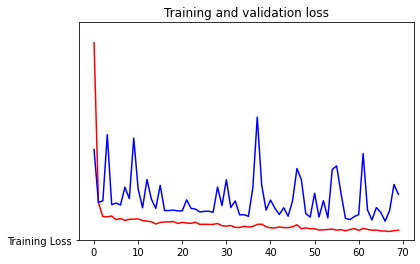

In [959]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_intc_tr=history_intc_tr.history['loss']
val_loss_intc_tr=history_intc_tr.history['val_loss']

epochs=range(len(loss_intc_tr)) 

plt.plot(epochs, loss_intc_tr, 'r', "Training Loss")
plt.plot(epochs, val_loss_intc_tr, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

MSE: 0.01583507512341328  RMSE: 0.12583749490280421 R^2 score: 0.7252868983591568 MAPE: 0.07508065740969208


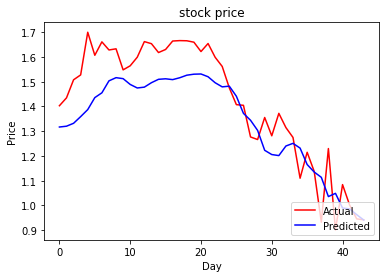

In [960]:
y_pred_intc_tr=making_y_pred(model_intc_tr,X_test_intc_tr)
mse_intc_tr,rmse_intc_tr,r_intc_tr,mape_intc_tr=Evalu(model_intc_tr,X_test_intc_tr,y_test_intc_tr,y_pred_intc_tr)
testset_plot(y_test_intc_tr,y_pred_intc_tr)

MSE: 0.0041794124308814915  RMSE: 0.06464837531509583 R^2 score: 0.7700565739665479 MAPE: 0.04934099591205629


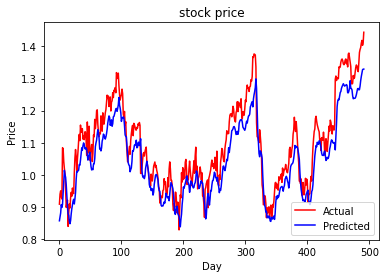

In [961]:
y_pred_intc_tr=making_y_pred(model_intc_tr,X_val_intc_tr)
mse_intc_tr,rmse_intc_tr,r_intc_tr,mape_intc_tr=Evalu(model_intc_tr,X_val_intc_tr,y_val_intc_tr,y_pred_intc_tr)
testset_plot(y_val_intc_tr,y_pred_intc_tr)

###### feature selection by correlation

In [962]:
model_intc_corr = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(5,kernel_size=2,input_shape=(10,5)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_intc_corr.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_intc_corr = model_intc_corr.fit(X_train_intc_corr,y_train_intc_corr,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_intc_corr, y_val_intc_corr),verbose = 1)

Epoch 1/70
32/32 [==============================] - 2s 55ms/step - loss: 0.0180 - val_loss: 0.0047
Epoch 2/70
32/32 [==============================] - 1s 21ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 3/70
32/32 [==============================] - 1s 21ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 4/70
32/32 [==============================] - 1s 22ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 5/70
32/32 [==============================] - 1s 21ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 6/70
32/32 [==============================] - 1s 21ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 7/70
32/32 [==============================] - 1s 21ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 8/70
32/32 [==============================] - 1s 21ms/step - loss: 9.4525e-04 - val_loss: 0.0016
Epoch 9/70
32/32 [==============================] - 1s 21ms/step - loss: 9.6298e-04 - val_loss: 0.0016
Epoch 10/70
32/32 [==============================] - 1s 21ms/step - loss: 9.4650e-04 - val_loss: 0.00

Text(0.5, 1.0, 'corraining and validation loss')

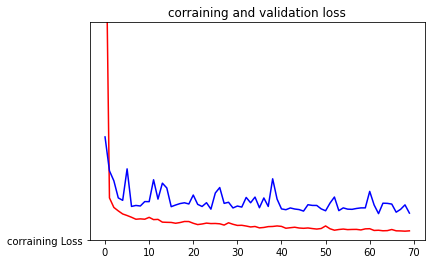

In [963]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_intc_corr=history_intc_corr.history['loss']
val_loss_intc_corr=history_intc_corr.history['val_loss']

epochs=range(len(loss_intc_corr)) 

plt.plot(epochs, loss_intc_corr, 'r', "corraining Loss")
plt.plot(epochs, val_loss_intc_corr, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('corraining and validation loss')

MSE: 0.014677347873840462  RMSE: 0.12115010472071604 R^2 score: 0.7453716053217416 MAPE: 0.07481847626557471


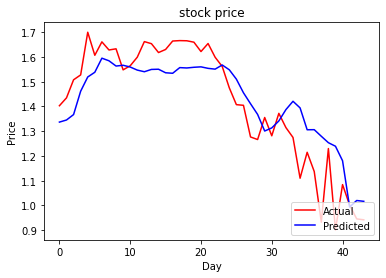

In [964]:
y_pred_intc_corr=making_y_pred(model_intc_corr,X_test_intc_corr)
mse_intc_corr,rmse_intc_corr,r_intc_corr,mape_intc_corr=Evalu(model_intc_corr,X_test_intc_corr,y_test_intc_corr,y_pred_intc_corr)
testset_plot(y_test_intc_corr,y_pred_intc_corr)

MSE: 0.0024552005124795525  RMSE: 0.04954997994429011 R^2 score: 0.8649194768941328 MAPE: 0.03648082854959684


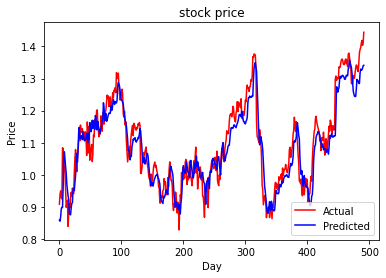

In [965]:
y_pred_intc_corr=making_y_pred(model_intc_corr,X_val_intc_corr)
mse_intc_corr,rmse_intc_corr,r_intc_corr,mape_intc_corr=Evalu(model_intc_corr,X_val_intc_corr,y_val_intc_corr,y_pred_intc_corr)
testset_plot(y_val_intc_corr,y_pred_intc_corr)

###### feature selection by svm-rfe

In [966]:
model_intc_svm = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(4,kernel_size=2,input_shape=(10,4)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_intc_svm.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_intc_svm = model_intc_svm.fit(X_train_intc_svm,y_train_intc_svm,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_intc_svm, y_val_intc_svm),verbose = 1)

Epoch 1/70
32/32 [==============================] - 2s 54ms/step - loss: 0.0198 - val_loss: 0.1217
Epoch 2/70
32/32 [==============================] - 1s 20ms/step - loss: 0.0084 - val_loss: 0.0562
Epoch 3/70
32/32 [==============================] - 1s 20ms/step - loss: 0.0047 - val_loss: 0.0411
Epoch 4/70
32/32 [==============================] - 1s 20ms/step - loss: 0.0036 - val_loss: 0.0246
Epoch 5/70
32/32 [==============================] - 1s 20ms/step - loss: 0.0023 - val_loss: 0.0137
Epoch 6/70
32/32 [==============================] - 1s 20ms/step - loss: 0.0017 - val_loss: 0.0132
Epoch 7/70
32/32 [==============================] - 1s 20ms/step - loss: 0.0012 - val_loss: 0.0056
Epoch 8/70
32/32 [==============================] - 1s 20ms/step - loss: 9.2993e-04 - val_loss: 0.0078
Epoch 9/70
32/32 [==============================] - 1s 20ms/step - loss: 0.0011 - val_loss: 0.0074
Epoch 10/70
32/32 [==============================] - 1s 20ms/step - loss: 8.9738e-04 - val_loss: 0.0029
E

Text(0.5, 1.0, 'svmaining and validation loss')

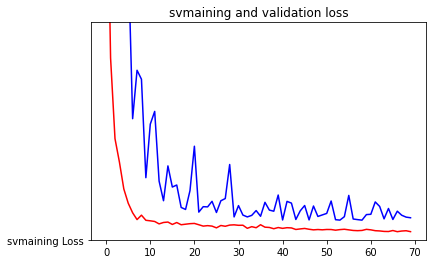

In [967]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_intc_svm=history_intc_svm.history['loss']
val_loss_intc_svm=history_intc_svm.history['val_loss']

epochs=range(len(loss_intc_svm)) 

plt.plot(epochs, loss_intc_svm, 'r', "svmaining Loss")
plt.plot(epochs, val_loss_intc_svm, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('svmaining and validation loss')

MSE: 0.00930185558434726  RMSE: 0.0964461278867496 R^2 score: 0.8386277565041053 MAPE: 0.05571089511293064


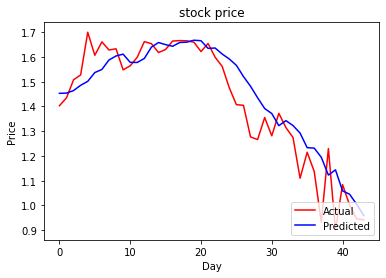

In [968]:
y_pred_intc_svm=making_y_pred(model_intc_svm,X_test_intc_svm)
mse_intc_svm,rmse_intc_svm,r_intc_svm,mape_intc_svm=Evalu(model_intc_svm,X_test_intc_svm,y_test_intc_svm,y_pred_intc_svm)
testset_plot(y_test_intc_svm,y_pred_intc_svm)

MSE: 0.002027366508773086  RMSE: 0.04502628686415398 R^2 score: 0.8884581006152488 MAPE: 0.03260025317709764


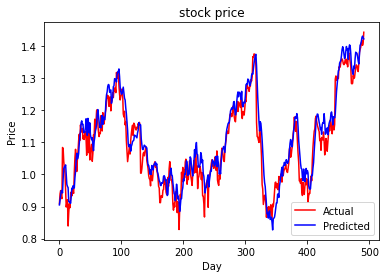

In [969]:
y_pred_intc_svm=making_y_pred(model_intc_svm,X_val_intc_svm)
mse_intc_svm,rmse_intc_svm,r_intc_svm,mape_intc_svm=Evalu(model_intc_svm,X_val_intc_svm,y_val_intc_svm,y_pred_intc_svm)
testset_plot(y_val_intc_svm,y_pred_intc_svm)

#### MSFT

In [ ]:
df_msft=pd.read_csv('MSFT_sentiment.csv',index_col=0)

In [970]:
#Traning:2010-01-04 to 2018-01-03, Validation: 2018-01-04 to 2020-01-02, testing: 2019-12-02

df_msft_picked_tr = df_msft[['Close','Open','High','Low','sentiment_score']] 
df_msft_picked_corr = df_msft[['Close','H-O','RSI','6 DAYS PSY','24 DAYS AR','sentiment_score']] 
df_msft_picked_svm = df_msft[['Close','6 DAYS WMS','RSI','7 DAYS STD DEV','sentiment_score']] 

windows_size=10

train_sc_tr,val_sc_tr,test_sc_tr=making_scaled_training_val_test_data(df_msft_picked_tr,6005,8020,8500,8730)
X_train_msft_tr,y_train_msft_tr,X_val_msft_tr,y_val_msft_tr=making_train_val(train_sc_tr,val_sc_tr,windows_size)
X_test_msft_tr,y_test_msft_tr=making_test(test_sc_tr,windows_size)

train_sc_corr,val_sc_corr,test_sc_corr=making_scaled_training_val_test_data(df_msft_picked_corr,6005,8020,8500,8730)
X_train_msft_corr,y_train_msft_corr,X_val_msft_corr,y_val_msft_corr=making_train_val(train_sc_corr,val_sc_corr,windows_size)
X_test_msft_corr,y_test_msft_corr=making_test(test_sc_corr,windows_size)

train_sc_svm,val_sc_svm,test_sc_svm=making_scaled_training_val_test_data(df_msft_picked_svm,6005,8020,8500,8730)
X_train_msft_svm,y_train_msft_svm,X_val_msft_svm,y_val_msft_svm=making_train_val(train_sc_svm,val_sc_svm,windows_size)
X_test_msft_svm,y_test_msft_svm=making_test(test_sc_svm,windows_size)

###### Traditional features

In [971]:
model_msft_tr = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(5,kernel_size=2,input_shape=(10,5)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_msft_tr.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_msft_tr = model_msft_tr.fit(X_train_msft_tr,y_train_msft_tr,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_msft_tr, y_val_msft_tr),verbose = 1)

Epoch 1/70
32/32 [==============================] - 2s 53ms/step - loss: 0.0115 - val_loss: 0.0060
Epoch 2/70
32/32 [==============================] - 1s 19ms/step - loss: 0.0012 - val_loss: 0.0030
Epoch 3/70
32/32 [==============================] - 1s 19ms/step - loss: 9.1754e-04 - val_loss: 0.0040
Epoch 4/70
32/32 [==============================] - 1s 19ms/step - loss: 8.6973e-04 - val_loss: 0.0069
Epoch 5/70
32/32 [==============================] - 1s 19ms/step - loss: 8.2124e-04 - val_loss: 0.0033
Epoch 6/70
32/32 [==============================] - 1s 18ms/step - loss: 7.4500e-04 - val_loss: 0.0063
Epoch 7/70
32/32 [==============================] - 1s 18ms/step - loss: 6.7549e-04 - val_loss: 0.0069
Epoch 8/70
32/32 [==============================] - 1s 18ms/step - loss: 6.6985e-04 - val_loss: 0.0049
Epoch 9/70
32/32 [==============================] - 1s 19ms/step - loss: 6.5992e-04 - val_loss: 0.0056
Epoch 10/70
32/32 [==============================] - 1s 18ms/step - loss: 6.6319e

In [972]:
model_msft_tr.summary()

Model: "sequential_198"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_314 (Conv1D)          (None, 9, 5)              55        
_________________________________________________________________
bidirectional_331 (Bidirecti (None, 9, 80)             14720     
_________________________________________________________________
bidirectional_332 (Bidirecti (None, 9, 80)             38720     
_________________________________________________________________
lstm_561 (LSTM)              (None, 40)                19360     
_________________________________________________________________
dropout_185 (Dropout)        (None, 40)                0         
_________________________________________________________________
dense_343 (Dense)            (None, 1)                 41        
Total params: 72,896
Trainable params: 72,896
Non-trainable params: 0
________________________________________________

Text(0.5, 1.0, 'Training and validation loss')

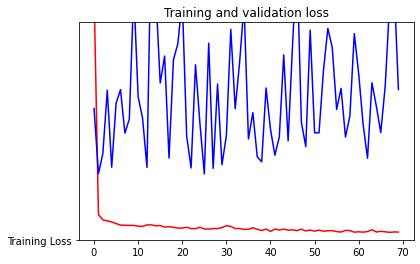

In [973]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_msft_tr=history_msft_tr.history['loss']
val_loss_msft_tr=history_msft_tr.history['val_loss']

epochs=range(len(loss_msft_tr)) 

plt.plot(epochs, loss_msft_tr, 'r', "Training Loss")
plt.plot(epochs, val_loss_msft_tr, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

MSE: 0.013823690363578918  RMSE: 0.1175741908905986 R^2 score: 0.809291786132982 MAPE: 0.054856081979962674


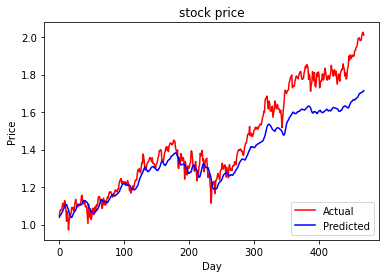

In [974]:
y_pred_msft_tr=making_y_pred(model_msft_tr,X_val_msft_tr)
mse_msft_tr,rmse_msft_tr,r_msft_tr,mape_msft_tr=Evalu(model_msft_tr,X_val_msft_tr,y_val_msft_tr,y_pred_msft_tr)
testset_plot(y_val_msft_tr,y_pred_msft_tr)

###### feature selection by correlation

In [975]:
model_msft_corr = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(6,kernel_size=2,input_shape=(10,6)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_msft_corr.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_msft_corr = model_msft_corr.fit(X_train_msft_corr,y_train_msft_corr,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_msft_corr, y_val_msft_corr),verbose = 1)

Epoch 1/70
32/32 [==============================] - 2s 52ms/step - loss: 0.0177 - val_loss: 0.0394
Epoch 2/70
32/32 [==============================] - 1s 18ms/step - loss: 0.0018 - val_loss: 0.0049
Epoch 3/70
32/32 [==============================] - 1s 18ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 4/70
32/32 [==============================] - 1s 18ms/step - loss: 8.6027e-04 - val_loss: 0.0065
Epoch 5/70
32/32 [==============================] - 1s 18ms/step - loss: 8.1548e-04 - val_loss: 0.0075
Epoch 6/70
32/32 [==============================] - 1s 18ms/step - loss: 7.2307e-04 - val_loss: 0.0034
Epoch 7/70
32/32 [==============================] - 1s 18ms/step - loss: 7.9931e-04 - val_loss: 0.0072
Epoch 8/70
32/32 [==============================] - 1s 17ms/step - loss: 7.4443e-04 - val_loss: 0.0066
Epoch 9/70
32/32 [==============================] - 1s 18ms/step - loss: 7.6366e-04 - val_loss: 0.0073
Epoch 10/70
32/32 [==============================] - 1s 18ms/step - loss: 6.8813e-04 

Text(0.5, 1.0, 'corraining and validation loss')

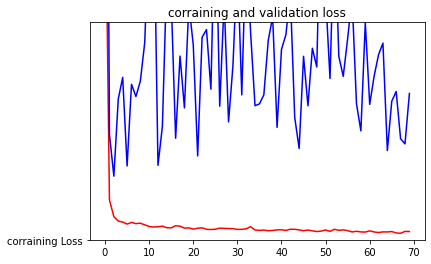

In [976]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_msft_corr=history_msft_corr.history['loss']
val_loss_msft_corr=history_msft_corr.history['val_loss']

epochs=range(len(loss_msft_corr)) 

plt.plot(epochs, loss_msft_corr, 'r', "corraining Loss")
plt.plot(epochs, val_loss_msft_corr, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('corraining and validation loss')

MSE: 0.013454794818322525  RMSE: 0.11599480513506855 R^2 score: 0.8143809778530671 MAPE: 0.053291119437196145


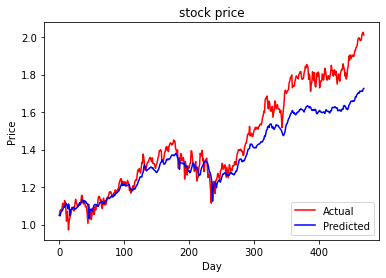

In [977]:
y_pred_msft_corr=making_y_pred(model_msft_corr,X_val_msft_corr)
mse_msft_corr,rmse_msft_corr,r_msft_corr,mape_msft_corr=Evalu(model_msft_corr,X_val_msft_corr,y_val_msft_corr,y_pred_msft_corr)
testset_plot(y_val_msft_corr,y_pred_msft_corr)

###### feature selection by svm-rfe

In [978]:
model_msft_svm = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(5,kernel_size=2,input_shape=(10,5)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_msft_svm.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_msft_svm = model_msft_svm.fit(X_train_msft_svm,y_train_msft_svm,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_msft_svm, y_val_msft_svm),verbose = 1)

Epoch 1/70
32/32 [==============================] - 2s 51ms/step - loss: 0.0237 - val_loss: 0.0132
Epoch 2/70
32/32 [==============================] - 1s 17ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 3/70
32/32 [==============================] - 1s 17ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 4/70
32/32 [==============================] - 1s 17ms/step - loss: 9.9152e-04 - val_loss: 0.0034
Epoch 5/70
32/32 [==============================] - 1s 17ms/step - loss: 9.0685e-04 - val_loss: 0.0110
Epoch 6/70
32/32 [==============================] - 1s 17ms/step - loss: 9.0257e-04 - val_loss: 0.0053
Epoch 7/70
32/32 [==============================] - 1s 17ms/step - loss: 7.4271e-04 - val_loss: 0.0058
Epoch 8/70
32/32 [==============================] - 1s 17ms/step - loss: 8.1377e-04 - val_loss: 0.0034
Epoch 9/70
32/32 [==============================] - 1s 17ms/step - loss: 8.0351e-04 - val_loss: 0.0026
Epoch 10/70
32/32 [==============================] - 1s 16ms/step - loss: 7.4405e-04 

Text(0.5, 1.0, 'svmaining and validation loss')

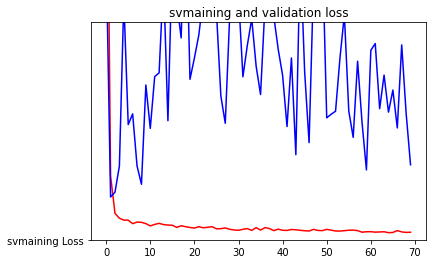

In [979]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_msft_svm=history_msft_svm.history['loss']
val_loss_msft_svm=history_msft_svm.history['val_loss']

epochs=range(len(loss_msft_svm)) 

plt.plot(epochs, loss_msft_svm, 'r', "svmaining Loss")
plt.plot(epochs, val_loss_msft_svm, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('svmaining and validation loss')

MSE: 0.006902758998037583  RMSE: 0.08308284418601462 R^2 score: 0.9047712438106564 MAPE: 0.03944367068625088


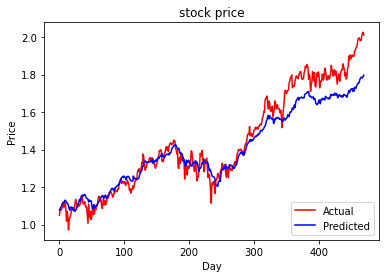

In [980]:
y_pred_msft_svm=making_y_pred(model_msft_svm,X_val_msft_svm)
mse_msft_svm,rmse_msft_svm,r_msft_svm,mape_msft_svm=Evalu(model_msft_svm,X_val_msft_svm,y_val_msft_svm,y_pred_msft_svm)
testset_plot(y_val_msft_svm,y_pred_msft_svm)

#### NVDA

In [ ]:
df_nvda=pd.read_csv('NVDA_sentiment.csv',index_col=0)

In [981]:
#Traning:2010-01-04 to 2018-01-03, Validation: 2018-01-04 to 2020-01-02, testing: 2019-09-20

df_nvda_picked_tr = df_nvda[['Close','Open','High','Low','sentiment_score']] 
df_nvda_picked_corr = df_nvda[['Close','H-L','7 DAYS STD DEV','RSI','sentiment_score']] 
df_nvda_picked_svm = df_nvda[['Close','6 DAYS WMS','MACD','20 DAYS EMA','sentiment_score']] 

windows_size=10

train_sc_tr,val_sc_tr,test_sc_tr=making_scaled_training_val_test_data(df_nvda_picked_tr,2755,4770,5200,5495)
X_train_nvda_tr,y_train_nvda_tr,X_val_nvda_tr,y_val_nvda_tr=making_train_val(train_sc_tr,val_sc_tr,windows_size)
X_test_nvda_tr,y_test_nvda_tr=making_test(test_sc_tr,windows_size)

train_sc_corr,val_sc_corr,test_sc_corr=making_scaled_training_val_test_data(df_nvda_picked_corr,2755,4770,5200,5495)
X_train_nvda_corr,y_train_nvda_corr,X_val_nvda_corr,y_val_nvda_corr=making_train_val(train_sc_corr,val_sc_corr,windows_size)
X_test_nvda_corr,y_test_nvda_corr=making_test(test_sc_corr,windows_size)

train_sc_svm,val_sc_svm,test_sc_svm=making_scaled_training_val_test_data(df_nvda_picked_svm,2755,4770,5200,5495)
X_train_nvda_svm,y_train_nvda_svm,X_val_nvda_svm,y_val_nvda_svm=making_train_val(train_sc_svm,val_sc_svm,windows_size)
X_test_nvda_svm,y_test_nvda_svm=making_test(test_sc_svm,windows_size)

###### Traditional features

In [982]:
model_nvda_tr = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(5,kernel_size=2,input_shape=(10,5)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_nvda_tr.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_nvda_tr = model_nvda_tr.fit(X_train_nvda_tr,y_train_nvda_tr,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_nvda_tr, y_val_nvda_tr),verbose = 1)

Epoch 1/70
32/32 [==============================] - 2s 50ms/step - loss: 0.0101 - val_loss: 0.0259
Epoch 2/70
32/32 [==============================] - 1s 16ms/step - loss: 0.0014 - val_loss: 0.0042
Epoch 3/70
32/32 [==============================] - 1s 16ms/step - loss: 6.9145e-04 - val_loss: 0.0019
Epoch 4/70
32/32 [==============================] - 1s 16ms/step - loss: 4.5234e-04 - val_loss: 0.0017
Epoch 5/70
32/32 [==============================] - 1s 16ms/step - loss: 3.9551e-04 - val_loss: 0.0015
Epoch 6/70
32/32 [==============================] - 0s 16ms/step - loss: 3.8681e-04 - val_loss: 0.0022
Epoch 7/70
32/32 [==============================] - 1s 16ms/step - loss: 4.5199e-04 - val_loss: 0.0016
Epoch 8/70
32/32 [==============================] - 0s 16ms/step - loss: 3.5636e-04 - val_loss: 0.0020
Epoch 9/70
32/32 [==============================] - 0s 15ms/step - loss: 3.0689e-04 - val_loss: 0.0018
Epoch 10/70
32/32 [==============================] - 0s 15ms/step - loss: 4.4484e

In [983]:
model_nvda_tr.summary()

Model: "sequential_201"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_317 (Conv1D)          (None, 9, 5)              55        
_________________________________________________________________
bidirectional_337 (Bidirecti (None, 9, 80)             14720     
_________________________________________________________________
bidirectional_338 (Bidirecti (None, 9, 80)             38720     
_________________________________________________________________
lstm_570 (LSTM)              (None, 40)                19360     
_________________________________________________________________
dropout_188 (Dropout)        (None, 40)                0         
_________________________________________________________________
dense_346 (Dense)            (None, 1)                 41        
Total params: 72,896
Trainable params: 72,896
Non-trainable params: 0
________________________________________________

Text(0.5, 1.0, 'Training and validation loss')

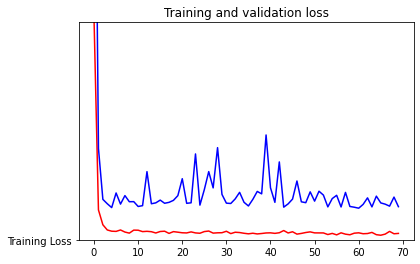

In [984]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_nvda_tr=history_nvda_tr.history['loss']
val_loss_nvda_tr=history_nvda_tr.history['val_loss']

epochs=range(len(loss_nvda_tr)) 

plt.plot(epochs, loss_nvda_tr, 'r', "Training Loss")
plt.plot(epochs, val_loss_nvda_tr, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('Training and validation loss')

MSE: 0.00047663217459297907  RMSE: 0.02183190725962757 R^2 score: 0.824344927461651 MAPE: 0.01860392182444638


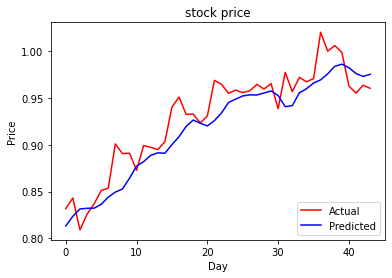

In [985]:
y_pred_nvda_tr=making_y_pred(model_nvda_tr,X_test_nvda_tr)
mse_nvda_tr,rmse_nvda_tr,r_nvda_tr,mape_nvda_tr=Evalu(model_nvda_tr,X_test_nvda_tr,y_test_nvda_tr,y_pred_nvda_tr)
testset_plot(y_test_nvda_tr,y_pred_nvda_tr)

MSE: 0.003048096346960123  RMSE: 0.05520956753100067 R^2 score: 0.9370629314289334 MAPE: 0.04609122435564523


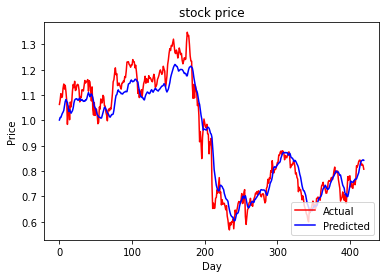

In [986]:
y_pred_nvda_tr=making_y_pred(model_nvda_tr,X_val_nvda_tr)
mse_nvda_tr,rmse_nvda_tr,r_nvda_tr,mape_nvda_tr=Evalu(model_nvda_tr,X_val_nvda_tr,y_val_nvda_tr,y_pred_nvda_tr)
testset_plot(y_val_nvda_tr,y_pred_nvda_tr)

###### feature selection by correlation

In [987]:
model_nvda_corr = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(5,kernel_size=2,input_shape=(10,5)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_nvda_corr.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_nvda_corr = model_nvda_corr.fit(X_train_nvda_corr,y_train_nvda_corr,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_nvda_corr, y_val_nvda_corr),verbose = 1)

Epoch 1/70
32/32 [==============================] - 2s 50ms/step - loss: 0.0097 - val_loss: 0.0703
Epoch 2/70
32/32 [==============================] - 1s 16ms/step - loss: 0.0019 - val_loss: 0.0122
Epoch 3/70
32/32 [==============================] - 1s 16ms/step - loss: 0.0013 - val_loss: 0.0071
Epoch 4/70
32/32 [==============================] - 1s 16ms/step - loss: 8.8623e-04 - val_loss: 0.0056
Epoch 5/70
32/32 [==============================] - 1s 16ms/step - loss: 6.3229e-04 - val_loss: 0.0045
Epoch 6/70
32/32 [==============================] - 1s 16ms/step - loss: 5.4274e-04 - val_loss: 0.0065
Epoch 7/70
32/32 [==============================] - 0s 16ms/step - loss: 4.8003e-04 - val_loss: 0.0050
Epoch 8/70
32/32 [==============================] - 1s 16ms/step - loss: 4.4179e-04 - val_loss: 0.0041
Epoch 9/70
32/32 [==============================] - 1s 16ms/step - loss: 5.0535e-04 - val_loss: 0.0106
Epoch 10/70
32/32 [==============================] - 1s 16ms/step - loss: 3.6925e-04 

Text(0.5, 1.0, 'corraining and validation loss')

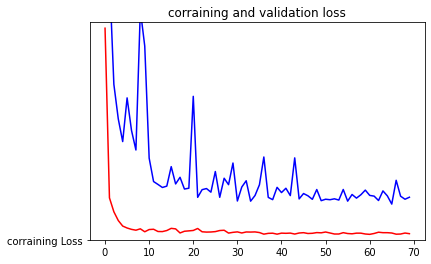

In [988]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_nvda_corr=history_nvda_corr.history['loss']
val_loss_nvda_corr=history_nvda_corr.history['val_loss']

epochs=range(len(loss_nvda_corr)) 

plt.plot(epochs, loss_nvda_corr, 'r', "corraining Loss")
plt.plot(epochs, val_loss_nvda_corr, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('corraining and validation loss')

MSE: 0.001421115110303009  RMSE: 0.03769768043663972 R^2 score: 0.47627103017376526 MAPE: 0.03460767523188816


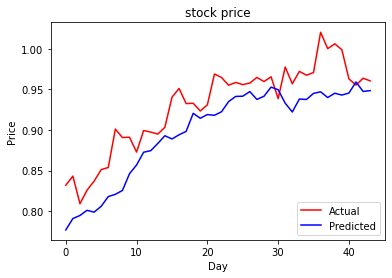

In [989]:
y_pred_nvda_corr=making_y_pred(model_nvda_corr,X_test_nvda_corr)
mse_nvda_corr,rmse_nvda_corr,r_nvda_corr,mape_nvda_corr=Evalu(model_nvda_corr,X_test_nvda_corr,y_test_nvda_corr,y_pred_nvda_corr)
testset_plot(y_test_nvda_corr,y_pred_nvda_corr)

MSE: 0.003914924092011282  RMSE: 0.06256935425598767 R^2 score: 0.919164679202098 MAPE: 0.0515883490736412


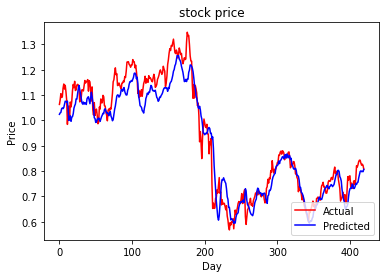

In [990]:
y_pred_nvda_corr=making_y_pred(model_nvda_corr,X_val_nvda_corr)
mse_nvda_corr,rmse_nvda_corr,r_nvda_corr,mape_nvda_corr=Evalu(model_nvda_corr,X_val_nvda_corr,y_val_nvda_corr,y_pred_nvda_corr)
testset_plot(y_val_nvda_corr,y_pred_nvda_corr)

###### feature selection by svm-rfe

In [991]:
model_nvda_svm = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(5,kernel_size=1,input_shape=(10,5)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_nvda_svm.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_nvda_svm = model_nvda_svm.fit(X_train_nvda_svm,y_train_nvda_svm,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_nvda_svm, y_val_nvda_svm),verbose = 1)

Epoch 1/70
32/32 [==============================] - 2s 58ms/step - loss: 0.0097 - val_loss: 0.0401
Epoch 2/70
32/32 [==============================] - 1s 24ms/step - loss: 0.0011 - val_loss: 0.0175
Epoch 3/70
32/32 [==============================] - 1s 24ms/step - loss: 6.9718e-04 - val_loss: 0.0160
Epoch 4/70
32/32 [==============================] - 1s 24ms/step - loss: 4.9971e-04 - val_loss: 0.0144
Epoch 5/70
32/32 [==============================] - 1s 24ms/step - loss: 4.9615e-04 - val_loss: 0.0071
Epoch 6/70
32/32 [==============================] - 1s 24ms/step - loss: 3.7357e-04 - val_loss: 0.0083
Epoch 7/70
32/32 [==============================] - 1s 24ms/step - loss: 4.5267e-04 - val_loss: 0.0072
Epoch 8/70
32/32 [==============================] - 1s 24ms/step - loss: 3.5942e-04 - val_loss: 0.0074
Epoch 9/70
32/32 [==============================] - 1s 24ms/step - loss: 3.6348e-04 - val_loss: 0.0079
Epoch 10/70
32/32 [==============================] - 1s 24ms/step - loss: 3.4538e

Text(0.5, 1.0, 'svmaining and validation loss')

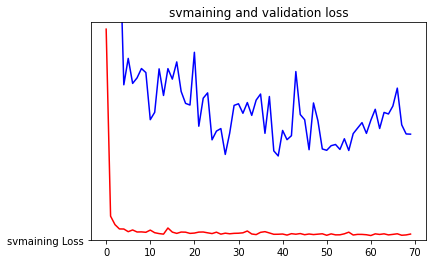

In [992]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss_nvda_svm=history_nvda_svm.history['loss']
val_loss_nvda_svm=history_nvda_svm.history['val_loss']

epochs=range(len(loss_nvda_svm)) 

plt.plot(epochs, loss_nvda_svm, 'r', "svmaining Loss")
plt.plot(epochs, val_loss_nvda_svm, 'b', "Validation Loss")
plt.ylim([0,0.01])

plt.title('svmaining and validation loss')

MSE: 0.0013039777988409886  RMSE: 0.036110632767108755 R^2 score: 0.519440090171402 MAPE: 0.03323690078129021


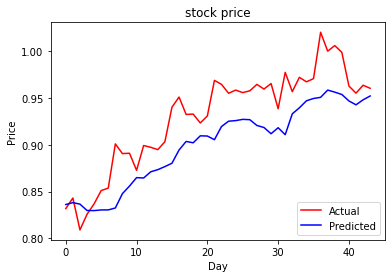

In [993]:
y_pred_nvda_svm=making_y_pred(model_nvda_svm,X_test_nvda_svm)
mse_nvda_svm,rmse_nvda_svm,r_nvda_svm,mape_nvda_svm=Evalu(model_nvda_svm,X_test_nvda_svm,y_test_nvda_svm,y_pred_nvda_svm)
testset_plot(y_test_nvda_svm,y_pred_nvda_svm)

MSE: 0.00971667366360624  RMSE: 0.09857318937523651 R^2 score: 0.7993702012539884 MAPE: 0.0873975210427993


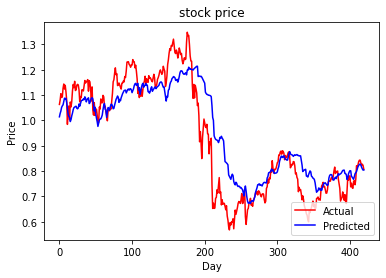

In [994]:
y_pred_nvda_svm=making_y_pred(model_nvda_svm,X_val_nvda_svm)
mse_nvda_svm,rmse_nvda_svm,r_nvda_svm,mape_nvda_svm=Evalu(model_nvda_svm,X_val_nvda_svm,y_val_nvda_svm,y_pred_nvda_svm)
testset_plot(y_val_nvda_svm,y_pred_nvda_svm)

### Conclusion

In [996]:
model_selection=pd.DataFrame(columns=(['Traditional','Corr','SVM-RFE']),
                     index=(['RMSE','MAPE']))

In [997]:
model_selection.iloc[0,0]=(0.06464837531509583   +0.1175741908905986    +0.05520956753100067  )/3 
model_selection.iloc[0,1]=(0.04954997994429011   +0.11599480513506855   +0.06256935425598767  ) /3
model_selection.iloc[0,2]=(0.04502628686415398   +0.08308284418601462   +0.09857318937523651   )/3
model_selection.iloc[1,0]=(0.04934099591205629   +0.054856081979962674  +0.04609122435564523   )/3 
model_selection.iloc[1,1]=(0.03648082854959684   +0.053291119437196145  +0.0515883490736412   )/3
model_selection.iloc[1,2]=(0.03260025317709764   +0.03944367068625088   +0.0873975210427993   )/3 

In [998]:
model_selection

Traditional       Corr    SVM-RFE
RMSE    0.079144   0.076038  0.0755608
MAPE   0.0500961  0.0471201  0.0531471

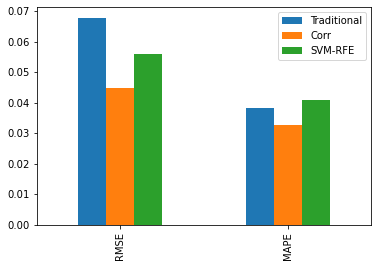

In [1020]:
sentiment_graph=model_selection.plot(kind='bar') #nvda

In [1019]:
model_without_sentiment

Traditional       Corr    SVM-RFE
RMSE   0.0706478    0.08092  0.0733776
MAPE   0.0432144  0.0529423  0.0476781

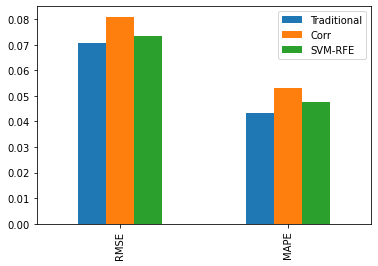

In [1021]:
without_sentiment_graph=model_without_sentiment.plot(kind='bar') #nvda

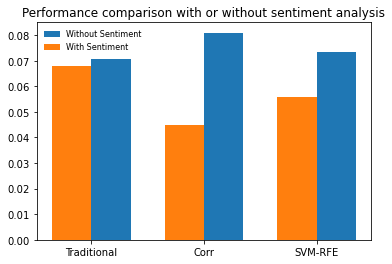

In [1108]:
index = np.arange(3)
bar_width = 0.35

fig, ax = plt.subplots()
without_sentiment = ax.bar(index+bar_width, model_without_sentiment.iloc[0,:],
                 bar_width, label="Without Sentiment")

sentiment = ax.bar(index, model_selection.iloc[0,:], bar_width,
                label="With Sentiment")

xlabel=model_selection.columns
xlabel[0]

ax.set_title('Performance comparison with or without sentiment analysis')
ax.set_xticks(index+bar_width/2)
ax.set_xticklabels(xlabel[index])
ax.legend(fontsize=8,fancybox=False, framealpha=0.0)

plt.show()

In [1100]:
model_selection

Traditional       Corr    SVM-RFE
RMSE   0.0678249  0.0448653  0.0559403
MAPE    0.038272  0.0327728  0.0409539

In [1202]:
a=model_without_sentiment.rename({'RMSE':'Without sentiment'})
b=model_selection.rename({'RMSE':'With sentiment'})
together=pd.concat([a,b])
together=together.drop(['MAPE'])

In [1203]:
together

Traditional       Corr    SVM-RFE
Without sentiment   0.0706478    0.08092  0.0733776
With sentiment      0.0678249  0.0448653  0.0559403

In [1209]:
together['ave']=(together['Traditional']+together['Corr']+together['SVM-RFE'])/(len(together.columns)-1)
together

Traditional       Corr    SVM-RFE        ave
Without sentiment   0.0706478    0.08092  0.0733776  0.0749818
With sentiment      0.0678249  0.0448653  0.0559403  0.0562101

In [1210]:
together=together.astype(float).round(5)

In [1211]:
together

Traditional     Corr  SVM-RFE      ave
Without sentiment      0.07065  0.08092  0.07338  0.07498
With sentiment         0.06782  0.04487  0.05594  0.05621

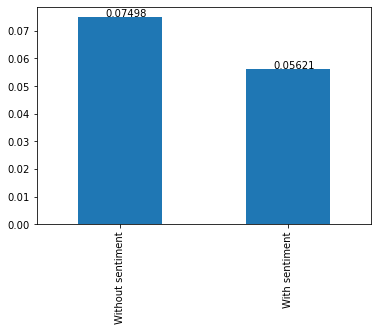

In [1212]:
ax=together['ave'].plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005+0.16, p.get_height() * 1.005))

# Optional

## feature selection with linear model prediction vs conv1d-lstm model prediction

In [1123]:
#Traning:2010-01-04 to 2018-01-03, Validation: 2018-01-04 to 2020-01-02, testing: 2020-01-03

df_intc_picked_tr = df_intc[['Close','Open','High','Low','Volume']]
df_intc_picked_corr = df_intc[['Close','H-O','7 DAYS STD DEV','Volume','MACD']]
df_intc_picked_svm = df_intc[['Close','6 DAYS WMS','MACD','21 DAYS MA']]
windows_size=10

train_sc_tr,val_sc_tr,test_sc_tr=making_scaled_training_val_test_data(df_intc_picked_tr,7519,9534,10036,10261)
X_train_intc_tr,y_train_intc_tr,X_val_intc_tr,y_val_intc_tr=making_train_val(train_sc_tr,val_sc_tr,windows_size)
X_test_intc_tr,y_test_intc_tr=making_test(test_sc_tr,windows_size)

train_sc_corr,val_sc_corr,test_sc_corr=making_scaled_training_val_test_data(df_intc_picked_corr,7519,9534,10036,10261)
X_train_intc_corr,y_train_intc_corr,X_val_intc_corr,y_val_intc_corr=making_train_val(train_sc_corr,val_sc_corr,windows_size)
X_test_intc_corr,y_test_intc_corr=making_test(test_sc_corr,windows_size)

train_sc_svm,val_sc_svm,test_sc_svm=making_scaled_training_val_test_data(df_intc_picked_svm,7519,9534,10036,10261)
X_train_intc_svm,y_train_intc_svm,X_val_intc_svm,y_val_intc_svm=making_train_val(train_sc_svm,val_sc_svm,windows_size)
X_test_intc_svm,y_test_intc_svm=making_test(test_sc_svm,windows_size)

In [1124]:
model_intc_tr = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[10, 5]),
    tf.keras.layers.Dense(1)
])
model_intc_tr.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_intc_tr = model_intc_tr.fit(X_train_intc_tr,y_train_intc_tr,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_intc_tr, y_val_intc_tr),verbose = 1)

Epoch 1/70
32/32 [==============================] - 0s 4ms/step - loss: 0.4631 - val_loss: 1.2771
Epoch 2/70
32/32 [==============================] - 0s 1ms/step - loss: 0.1144 - val_loss: 0.2001
Epoch 3/70
32/32 [==============================] - 0s 970us/step - loss: 0.0110 - val_loss: 0.0111
Epoch 4/70
32/32 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0037
Epoch 5/70
32/32 [==============================] - 0s 970us/step - loss: 0.0017 - val_loss: 0.0038
Epoch 6/70
32/32 [==============================] - 0s 970us/step - loss: 0.0017 - val_loss: 0.0040
Epoch 7/70
32/32 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0039
Epoch 8/70
32/32 [==============================] - 0s 907us/step - loss: 0.0017 - val_loss: 0.0040
Epoch 9/70
32/32 [==============================] - 0s 938us/step - loss: 0.0017 - val_loss: 0.0039
Epoch 10/70
32/32 [==============================] - 0s 907us/step - loss: 0.0017 - val_loss: 0.0040
Epoch 1

MSE: 0.02022741355557188  RMSE: 0.14222311188963585 R^2 score: 0.6490868863762345 MAPE: 0.08985193517403886


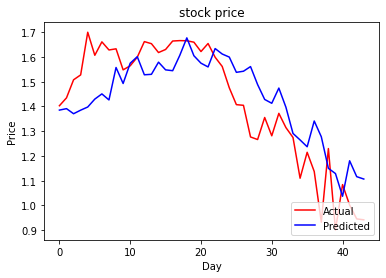

In [1125]:
y_pred_intc_tr=making_y_pred(model_intc_tr,X_test_intc_tr)
mse_intc_tr,rmse_intc_tr,r_intc_tr,mape_intc_tr=Evalu(model_intc_tr,X_test_intc_tr,y_test_intc_tr,y_pred_intc_tr)
testset_plot(y_test_intc_tr,y_pred_intc_tr)

In [1127]:
model_intc_corr = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[10, 5]),
    tf.keras.layers.Dense(1)
])
model_intc_corr.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_intc_corr = model_intc_corr.fit(X_train_intc_corr,y_train_intc_corr,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_intc_corr, y_val_intc_corr),verbose = 1)

Epoch 1/70
32/32 [==============================] - 0s 4ms/step - loss: 0.1412 - val_loss: 0.4621
Epoch 2/70
32/32 [==============================] - 0s 907us/step - loss: 0.0555 - val_loss: 0.1970
Epoch 3/70
32/32 [==============================] - 0s 907us/step - loss: 0.0372 - val_loss: 0.1304
Epoch 4/70
32/32 [==============================] - 0s 876us/step - loss: 0.0271 - val_loss: 0.0942
Epoch 5/70
32/32 [==============================] - 0s 844us/step - loss: 0.0195 - val_loss: 0.0673
Epoch 6/70
32/32 [==============================] - 0s 844us/step - loss: 0.0140 - val_loss: 0.0493
Epoch 7/70
32/32 [==============================] - 0s 907us/step - loss: 0.0102 - val_loss: 0.0373
Epoch 8/70
32/32 [==============================] - 0s 876us/step - loss: 0.0076 - val_loss: 0.0288
Epoch 9/70
32/32 [==============================] - 0s 970us/step - loss: 0.0059 - val_loss: 0.0234
Epoch 10/70
32/32 [==============================] - 0s 907us/step - loss: 0.0047 - val_loss: 0.0196
E

MSE: 0.014068831845577584  RMSE: 0.11861210665685684 R^2 score: 0.7559283803429786 MAPE: 0.07134743314475235


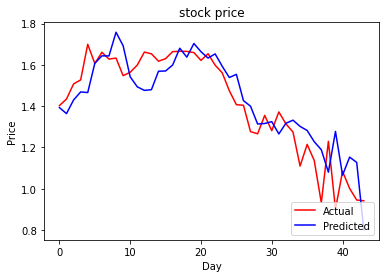

In [1128]:
y_pred_intc_corr=making_y_pred(model_intc_corr,X_test_intc_corr)
mse_intc_corr,rmse_intc_corr,r_intc_corr,mape_intc_corr=Evalu(model_intc_corr,X_test_intc_corr,y_test_intc_corr,y_pred_intc_corr)
testset_plot(y_test_intc_corr,y_pred_intc_corr)

In [1130]:
model_intc_svm = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[10, 4]),
    tf.keras.layers.Dense(1)
])
model_intc_svm.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_intc_svm = model_intc_svm.fit(X_train_intc_svm,y_train_intc_svm,epochs = 70 ,batch_size = 64 ,validation_data = (X_val_intc_svm, y_val_intc_svm),verbose = 1)

Epoch 1/70
32/32 [==============================] - 0s 4ms/step - loss: 0.0500 - val_loss: 0.0408
Epoch 2/70
32/32 [==============================] - 0s 907us/step - loss: 0.0212 - val_loss: 0.0315
Epoch 3/70
32/32 [==============================] - 0s 876us/step - loss: 0.0173 - val_loss: 0.0237
Epoch 4/70
32/32 [==============================] - 0s 876us/step - loss: 0.0143 - val_loss: 0.0192
Epoch 5/70
32/32 [==============================] - 0s 844us/step - loss: 0.0120 - val_loss: 0.0164
Epoch 6/70
32/32 [==============================] - 0s 876us/step - loss: 0.0103 - val_loss: 0.0143
Epoch 7/70
32/32 [==============================] - 0s 907us/step - loss: 0.0089 - val_loss: 0.0127
Epoch 8/70
32/32 [==============================] - 0s 876us/step - loss: 0.0078 - val_loss: 0.0114
Epoch 9/70
32/32 [==============================] - 0s 907us/step - loss: 0.0070 - val_loss: 0.0104
Epoch 10/70
32/32 [==============================] - 0s 907us/step - loss: 0.0063 - val_loss: 0.0096
E

MSE: 0.019773363402031167  RMSE: 0.14061779191137644 R^2 score: 0.6569639267443754 MAPE: 0.08935024563447895


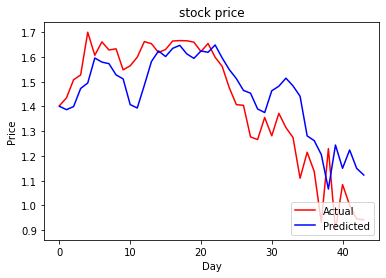

In [1131]:
y_pred_intc_svm=making_y_pred(model_intc_svm,X_test_intc_svm)
mse_intc_svm,rmse_intc_svm,r_intc_svm,mape_intc_svm=Evalu(model_intc_svm,X_test_intc_svm,y_test_intc_svm,y_pred_intc_svm)
testset_plot(y_test_intc_svm,y_pred_intc_svm)

In [1134]:
model_intc_tr = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(5,kernel_size=2,input_shape=(10,5)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_intc_tr.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_intc_tr = model_intc_tr.fit(X_train_intc_tr,y_train_intc_tr,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_intc_tr, y_val_intc_tr),verbose = 1)

Epoch 1/100
32/32 [==============================] - 2s 51ms/step - loss: 0.0227 - val_loss: 0.0025
Epoch 2/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 3/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 4/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 5/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 6/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 7/100
32/32 [==============================] - 0s 14ms/step - loss: 9.4366e-04 - val_loss: 0.0042
Epoch 8/100
32/32 [==============================] - 0s 14ms/step - loss: 9.7889e-04 - val_loss: 0.0024
Epoch 9/100
32/32 [==============================] - 0s 14ms/step - loss: 8.6284e-04 - val_loss: 0.0021
Epoch 10/100
32/32 [==============================] - 0s 15ms/step - loss: 9.8774e-04 - 

32/32 [==============================] - 0s 14ms/step - loss: 3.7621e-04 - val_loss: 0.0020
Epoch 80/100
32/32 [==============================] - 0s 15ms/step - loss: 3.9061e-04 - val_loss: 7.9224e-04
Epoch 81/100
32/32 [==============================] - 0s 14ms/step - loss: 3.6344e-04 - val_loss: 7.7103e-04
Epoch 82/100
32/32 [==============================] - 0s 15ms/step - loss: 3.7039e-04 - val_loss: 0.0011
Epoch 83/100
32/32 [==============================] - 0s 14ms/step - loss: 3.4523e-04 - val_loss: 0.0013
Epoch 84/100
32/32 [==============================] - 0s 15ms/step - loss: 3.6806e-04 - val_loss: 0.0015
Epoch 85/100
32/32 [==============================] - 0s 15ms/step - loss: 3.7486e-04 - val_loss: 0.0015
Epoch 86/100
32/32 [==============================] - 0s 14ms/step - loss: 3.4174e-04 - val_loss: 8.2309e-04
Epoch 87/100
32/32 [==============================] - 0s 14ms/step - loss: 3.4483e-04 - val_loss: 7.2098e-04
Epoch 88/100
32/32 [==============================] 

MSE: 0.024028822010953025  RMSE: 0.15501232857728778 R^2 score: 0.5831385596873756 MAPE: 0.09318693242227093


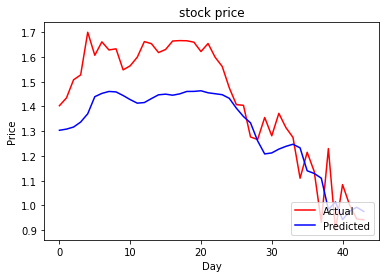

In [1135]:
y_pred_intc_tr=making_y_pred(model_intc_tr,X_test_intc_tr)
mse_intc_tr,rmse_intc_tr,r_intc_tr,mape_intc_tr=Evalu(model_intc_tr,X_test_intc_tr,y_test_intc_tr,y_pred_intc_tr)
testset_plot(y_test_intc_tr,y_pred_intc_tr)

In [1136]:
model_intc_corr = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(5,kernel_size=2,input_shape=(10,5)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_intc_corr.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_intc_corr = model_intc_corr.fit(X_train_intc_corr,y_train_intc_corr,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_intc_corr, y_val_intc_corr),verbose = 1)

Epoch 1/100
32/32 [==============================] - 2s 50ms/step - loss: 0.0296 - val_loss: 0.1486
Epoch 2/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0076 - val_loss: 0.0470
Epoch 3/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0031 - val_loss: 0.0248
Epoch 4/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0016 - val_loss: 0.0151
Epoch 5/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0013 - val_loss: 0.0072
Epoch 6/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0012 - val_loss: 0.0057
Epoch 7/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0011 - val_loss: 0.0072
Epoch 8/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0010 - val_loss: 0.0050
Epoch 9/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0011 - val_loss: 0.0068
Epoch 10/100
32/32 [==============================] - 0s 14ms/step - loss: 9.9289e-04 - val_loss: 0.

32/32 [==============================] - 0s 14ms/step - loss: 4.6883e-04 - val_loss: 0.0042
Epoch 80/100
32/32 [==============================] - 0s 14ms/step - loss: 4.6121e-04 - val_loss: 0.0057
Epoch 81/100
32/32 [==============================] - 0s 14ms/step - loss: 4.1371e-04 - val_loss: 0.0044
Epoch 82/100
32/32 [==============================] - 0s 14ms/step - loss: 4.3086e-04 - val_loss: 0.0035
Epoch 83/100
32/32 [==============================] - 0s 14ms/step - loss: 4.1203e-04 - val_loss: 0.0041
Epoch 84/100
32/32 [==============================] - 0s 14ms/step - loss: 4.6823e-04 - val_loss: 0.0038
Epoch 85/100
32/32 [==============================] - 0s 14ms/step - loss: 4.4304e-04 - val_loss: 0.0032
Epoch 86/100
32/32 [==============================] - 0s 14ms/step - loss: 4.6791e-04 - val_loss: 0.0035
Epoch 87/100
32/32 [==============================] - 0s 14ms/step - loss: 4.6171e-04 - val_loss: 0.0056
Epoch 88/100
32/32 [==============================] - 0s 14ms/step -

MSE: 0.07965614711159207  RMSE: 0.2822342061331193 R^2 score: -0.38190612088917675 MAPE: 0.1743238892361431


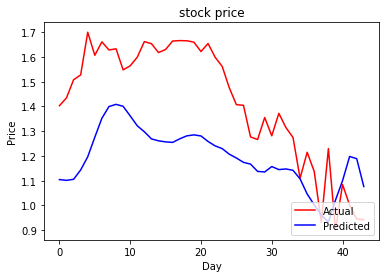

In [1137]:
y_pred_intc_corr=making_y_pred(model_intc_corr,X_test_intc_corr)
mse_intc_corr,rmse_intc_corr,r_intc_corr,mape_intc_corr=Evalu(model_intc_corr,X_test_intc_corr,y_test_intc_corr,y_pred_intc_corr)
testset_plot(y_test_intc_corr,y_pred_intc_corr)

In [1138]:
model_intc_svm = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(4,kernel_size=2,input_shape=(10,4)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6,return_sequences = True,
               activation = 'relu')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    
])
model_intc_svm.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = tf.keras.losses.Huber())

history_intc_svm = model_intc_svm.fit(X_train_intc_svm,y_train_intc_svm,epochs = 100 ,batch_size = 64 ,validation_data = (X_val_intc_svm, y_val_intc_svm),verbose = 1)

Epoch 1/100
32/32 [==============================] - 2s 50ms/step - loss: 0.0189 - val_loss: 0.0121
Epoch 2/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 3/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0014 - val_loss: 0.0033
Epoch 4/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 5/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 6/100
32/32 [==============================] - 0s 14ms/step - loss: 9.9454e-04 - val_loss: 0.0033
Epoch 7/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 0.0042
Epoch 8/100
32/32 [==============================] - 0s 13ms/step - loss: 9.6391e-04 - val_loss: 0.0027
Epoch 9/100
32/32 [==============================] - 0s 13ms/step - loss: 9.3829e-04 - val_loss: 0.0025
Epoch 10/100
32/32 [==============================] - 0s 14ms/step - loss: 9.3600e-04 - 

32/32 [==============================] - 0s 13ms/step - loss: 3.7208e-04 - val_loss: 0.0011
Epoch 80/100
32/32 [==============================] - 0s 14ms/step - loss: 3.5960e-04 - val_loss: 0.0013
Epoch 81/100
32/32 [==============================] - 0s 14ms/step - loss: 3.8567e-04 - val_loss: 0.0013
Epoch 82/100
32/32 [==============================] - 0s 14ms/step - loss: 4.1286e-04 - val_loss: 0.0012
Epoch 83/100
32/32 [==============================] - 0s 14ms/step - loss: 3.6068e-04 - val_loss: 0.0011
Epoch 84/100
32/32 [==============================] - 0s 14ms/step - loss: 3.8491e-04 - val_loss: 0.0025
Epoch 85/100
32/32 [==============================] - 0s 14ms/step - loss: 4.1722e-04 - val_loss: 0.0011
Epoch 86/100
32/32 [==============================] - 0s 13ms/step - loss: 3.3999e-04 - val_loss: 0.0013
Epoch 87/100
32/32 [==============================] - 0s 13ms/step - loss: 3.6070e-04 - val_loss: 0.0014
Epoch 88/100
32/32 [==============================] - 0s 14ms/step -

MSE: 0.018658230068888945  RMSE: 0.13659513193700917 R^2 score: 0.6763096977181831 MAPE: 0.08567239795361187


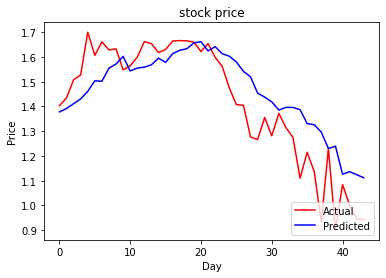

In [1139]:
y_pred_intc_svm=making_y_pred(model_intc_svm,X_test_intc_svm)
mse_intc_svm,rmse_intc_svm,r_intc_svm,mape_intc_svm=Evalu(model_intc_svm,X_test_intc_svm,y_test_intc_svm,y_pred_intc_svm)
testset_plot(y_test_intc_svm,y_pred_intc_svm)

# Conclusion: There have been improvement with developing LSTM model and Sentiment analysis based stock price prediction is a promising area to study. 